# train

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from rl_env_inc import TrajComp
from rl_brain import PolicyGradient
from rl_ppo import PPO
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def run_online(env, RL, ratio, elist): # Validation
    eva = []
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            action = RL.pro_choose_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return eva
        
def run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio): #Training
    check = 999999
    tra_av_errs = []#放的是每50回合训练集上的平均误差
    val_av_errs = []#放的是每50回合验证集上的平均误差
    for r in range(Round):
        env.shuffle()
        episode = 0
        for i in range(0, traj_amount, show_time):
            train_ep_errs = []
            start_t = time.time()
            for _ in tqdm(range(show_time), desc="[{}/{}]".format(min(i+show_time,traj_amount),traj_amount),ncols=100):
                buffer_size = int(ratio*len(env.ori_traj_set[episode]))
                # extreme cases
                if buffer_size < 3:
                    episode += 1
                    continue
                steps, state = env.reset(episode, buffer_size)#初始化状态值，返回轨迹点数和有序列表前k个状态值
                for index in range(buffer_size, steps):#从第一次缓存外第一个点遍历到最后一个点
                    if index == steps - 1:#如果已经是轨迹最后一个点
                        done = True
                    else:
                        done = False
                    action = RL.pro_choose_action(state)#状态输出到神经网络输出动作的概率分布，按概率采样一个动作
                    new_state, reward = env.step(episode, action, index, done, 'T') #'T' means Training, and 'V' means Validation                   
                    RL.store_transition(state, action, reward)
                    if done:
                        RL.learn()#回合结束开始策略梯度算法学习参数
                        break
                    state = new_state
                train_e = env.output(episode, 'T') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
                train_ep_errs.append(train_e)
                episode += 1
            
            val_ep_errs = run_online(env, RL, ratio, [i for i in range(traj_amount, traj_amount + valid_amount)])
            val_av_err = sum(val_ep_errs)/len(val_ep_errs)
            val_av_errs.append(val_av_err)
            tra_av_err = sum(train_ep_errs)/len(train_ep_errs)
            tra_av_errs.append(tra_av_err)
            print('round {} episode {}: Training error: {}, Validation error: {}'.format(r, episode, tra_av_err, val_av_err))
            if val_av_err < check:
                check = val_av_err
                RL.save('./save/'+ str(val_av_err) + '_ratio_' + str(ratio) + '_' + env.label + '/trained_model.ckpt')
                print('Save model with error {}'.format(val_av_err))
            print('==>current best model is {} with ratio {}'.format(check, ratio))
            print('It costs {}s'.format(time.time()-start_t))
    return tra_av_errs, val_av_errs

# def run_ppo(env, RL, Round, traj_amount, valid_amount, show_time, ratio, batch_size):
#     check = 999999
#     tra_av_errs = []#放的是每50回合训练集上的平均误差
#     val_av_errs = []#放的是每50回合验证集上的平均误差
#     for r in range(Round):
#         env.shuffle()
#         episode = 0
#         for i in range(0, traj_amount, show_time):
#             train_ep_errs = []
#             start_t = time.time()
#             for _ in tqdm(range(show_time), desc="[{}/{}]".format(min(i+show_time,traj_amount),traj_amount),ncols=100):
#                 buffer_size = int(ratio*len(env.ori_traj_set[episode]))
#                 # extreme cases
#                 if buffer_size < 3:
#                     episode += 1
#                     continue
#                 steps, state = env.reset(episode, buffer_size)#初始化状态值，返回轨迹点数和有序列表前k个状态值
#                 for index in range(buffer_size, steps):#从第一次缓存外第一个点遍历到最后一个点
#                     if index == steps - 1:#如果已经是轨迹最后一个点
#                         done = True
#                     else:
#                         done = False
#                     action1 = RL.pro_choose_action(state)
#                     action, logp = RL.pro(state)#状态输出到神经网络输出动作的概率分布，按概率采样一个动作
#                     new_state, reward = env.step(episode, action, index, done, 'T') #'T' means Training, and 'V' means Validation                   
#                     RL.store_transition(state, action, reward, logp)
#                     if done or (index % batch_size == 0):
#                         RL.learn()#回合结束开始PPO算法学习参数
#                     if (index / batch_size) % 3 == 0:
#                         RL.empty_buffer()
#                     if done:
#                         break
#                     state = new_state
#                 train_e = env.output(episode, 'T') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
#                 train_ep_errs.append(train_e)
#                 episode += 1
            
#             val_ep_errs = run_online(env, RL, ratio, [i for i in range(traj_amount, traj_amount + valid_amount)])
#             val_av_err = sum(val_ep_errs)/len(val_ep_errs)
#             val_av_errs.append(val_av_err)
#             tra_av_err = sum(train_ep_errs)/len(train_ep_errs)
#             tra_av_errs.append(tra_av_err)
#             print('round {} episode {}: Training error: {}, Validation error: {}'.format(r, episode, tra_av_err, val_av_err))
#             if val_av_err < check:
#                 check = val_av_err
#                 RL.save('./save/'+ str(val_av_err) + '_ratio_' + str(ratio) + '_' + env.label +'_ppo'+ '/trained_model.ckpt')
#                 print('Save model with error {}'.format(val_av_err))
#             print('==>current best model is {} with ratio {}'.format(check, ratio))
#             print('It costs {}s'.format(time.time()-start_t))

def train(traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, label):
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_train_data(traj_path, traj_amount, valid_amount)
    env.set_error_type(label)
    RL = PolicyGradient(env.n_features, env.n_actions)
    start = time.time()
    tra_av_errs, val_av_errs = run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio)
    print("Training elapsed time = %s", float(time.time() - start))
    with open('errors_records.txt', 'a') as f:
        f.write('\nTraining errors and validation errors (' + label + ')\n')
        for i in range(len(tra_av_errs)):
            f.write(str(tra_av_errs[i])+' ')
        f.write('\n')
        for i in range(len(val_av_errs)):
            f.write(str(val_av_errs[i])+' ')
    plt.figure()
    plt.title("Average errors of training and validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, tra_av_errs, "r", label="training" )
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.figure()
    plt.title("Average errors of validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.show()

def retrain(model_path, traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, label):
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_train_data(traj_path, traj_amount, valid_amount)
    env.set_error_type(label)
    RL = PolicyGradient(env.n_features, env.n_actions)
    RL.load(model_path)
    start = time.time()
    tra_av_errs, val_av_errs = run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio)
    print("Training elapsed time = %s", float(time.time() - start))
    with open('errors_records.txt', 'a') as f:
        f.write('\nTraining errors and validation errors (' + label + ')\n')
        for i in range(len(tra_av_errs)):
            f.write(str(tra_av_errs[i])+' ')
        f.write('\n')
        for i in range(len(val_av_errs)):
            f.write(str(val_av_errs[i])+' ')
    plt.figure()
    plt.title("Average errors of training and validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, tra_av_errs, "r", label="training" )
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.figure()
    plt.title("Average errors of validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.show()
    
# def train_ppo(traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, label, batch_size):
#     traj_path = '../trajData/Geolife_out/'
#     env = TrajComp(a_size, s_size)
#     env.load_train_data(traj_path, traj_amount, valid_amount)
#     env.set_error_type(label)
#     RL = PPO(env.n_features, env.n_actions)
#     start = time.time()
#     tra_av_errs, val_av_errs = run_ppo(env, RL, Round, traj_amount, valid_amount, show_time, ratio, batch_size)
#     print("Training elapsed time = %s", float(time.time() - start))
#     with open('errors_records.txt', 'a') as f:
#         f.write('\nTraining errors and validation errors (' + label + ')\n')
#         for i in range(len(tra_av_errs)):
#             f.write(str(tra_av_errs[i])+' ')
#         f.write('\n')
#         for i in range(len(val_av_errs)):
#             f.write(str(val_av_errs[i])+' ')
#     plt.figure()
#     plt.title("Average errors of training and validation:")
#     plt.xlabel("training process / "+str(show_time)+" episodes")
#     plt.ylabel(label+" error")
#     x = range(len(tra_av_errs))
#     plt.plot(x, tra_av_errs, "r", label="training" )
#     plt.plot(x, val_av_errs, "b", label="validation")
#     plt.legend()
#     plt.figure()
#     plt.title("Average errors of validation:")
#     plt.xlabel("training process / "+str(show_time)+" episodes")
#     plt.ylabel(label+" error")
#     x = range(len(tra_av_errs))
#     plt.plot(x, val_av_errs, "b", label="validation")
#     plt.legend()
#     plt.show() 

# evaluate

In [3]:
from rl_env_inc import TrajComp
from rl_brain import PolicyGradient
import data_utils as F
import time

def evaluate(env, RL, ratio, elist): # Evaluation
    eva = []
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            action = RL.quick_time_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return sum(eva)/len(eva)

def test(model_path, amount, ratio, a_size, s_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_test_data(traj_path, amount)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    for _ in range(3):
        start = time.time()
        effectiveness = evaluate(env, rl, ratio, range(amount))
        print("Effectiveness: {:.4f}".format(effectiveness))
        print("Training elapsed time = {:.4f}s".format(float(time.time() - start)))   

def test_err(model_path, amount, ratio, a_size, s_size):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_test_data(traj_path, amount)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    for _ in range(3):
        errs = []
        t = []
        for type in ['sed','ped','dad','sad']:
            env.set_error_type(type)
            st = time.time()
            err = evaluate(env, rl, ratio, range(amount))
            t.append(time.time()-st)
            errs.append(err)
        print("Effectiveness of different errors: sed:{:.4f}, ped:{:.4f}, dad:{:.4f}, sad:{:.4f}"\
              .format(errs[0],errs[1],errs[2],errs[3]))
        print("Testing elapsed time = {:.4f}s, {:.4f}s, {:.4f}s, {:.4f}s".format(t[0],t[1],t[2],t[3]))
        
def test_ratio(model_path, amount, a_size, s_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_test_data(traj_path, amount)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    for _ in range(3):
        errs = []
        t = []
        for r in [0.1,0.2,0.3,0.4,0.5]:
            env.set_error_type(label)
            st = time.time()
            err = evaluate(env, rl, r, range(amount))
            t.append(time.time()-st)
            errs.append(err)
        print("Effectiveness of different ratios: 0.1:{:.4f}, 0.2:{:.4f}, 0.3:{:.4f}, 0.4:{:.4f}, 0.5:{:.4f}"\
              .format(errs[0],errs[1],errs[2],errs[3],errs[4]))
        print("Testing elapsed time = {:.4f}s, {:.4f}s, {:.4f}s, {:.4f}s, {:.4f}s".format(t[0],t[1],t[2],t[3],t[4]))

def test_one_sample(model_path, index, ratio, a_size, s_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_one_sample(traj_path, index)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    
    net_time = 0
    step_time = 0
    start_ = time.time()
    eva = []
    buffer_size = int(ratio*len(env.ori_traj_set[0]))
    if buffer_size < 3:
        return
    steps, observation = env.reset(0, buffer_size)
    for index in range(buffer_size, steps):
        if index == steps - 1:
            done = True
        else:
            done = False
        start = time.time()
        action = rl.quick_time_action(observation)
        net_time += float(time.time()-start)
        start = time.time()
        observation_, _ = env.step(0, action, index, done, 'V') #'T' means Training, and 'V' means Validation
        step_time += float(time.time()-start)
        observation = observation_
    eva=env.output(0, 'V') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    print("Effectiveness: %e" %eva)
    print("Training elapsed time = %s", float(time.time() - start_))
    print("net_time:",net_time)
    print("step_time:",step_time)   

## train and test

======loading train data======
It cost 1.5040996074676514s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 0 episode 100: Training error: 123.25179880815935, Validation error: 110.3749575489907

Save model with error 110.3749575489907
==>current best model is 110.3749575489907 with ratio 0.1
It costs 249.13402318954468s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


round 0 episode 200: Training error: 72.03158400184417, Validation error: 117.15049575975013
==>current best model is 110.3749575489907 with ratio 0.1
It costs 287.5537486076355s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


round 1 episode 100: Training error: 104.04410970789915, Validation error: 104.930451338449
Save model with error 104.930451338449
==>current best model is 104.930451338449 with ratio 0.1
It costs 302.78211665153503s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


round 1 episode 200: Training error: 79.19021638701116, Validation error: 103.3529458243053
Save model with error 103.3529458243053
==>current best model is 103.3529458243053 with ratio 0.1
It costs 243.14200615882874s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 2 episode 100: Training error: 109.13812601775747, Validation error: 100.16469148956871
Save model with error 100.16469148956871
==>current best model is 100.16469148956871 with ratio 0.1
It costs 226.77899384498596s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


round 2 episode 200: Training error: 60.94011599457914, Validation error: 101.27490454352716
==>current best model is 100.16469148956871 with ratio 0.1
It costs 276.9046239852905s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


round 3 episode 100: Training error: 77.36043701835196, Validation error: 106.37204934276322
==>current best model is 100.16469148956871 with ratio 0.1
It costs 261.2022018432617s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 3 episode 200: Training error: 103.0912813724958, Validation error: 96.66739876303708
Save model with error 96.66739876303708
==>current best model is 96.66739876303708 with ratio 0.1
It costs 247.71865582466125s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


round 4 episode 100: Training error: 81.69331887573392, Validation error: 89.40700562080426
Save model with error 89.40700562080426
==>current best model is 89.40700562080426 with ratio 0.1
It costs 251.64089512825012s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


round 4 episode 200: Training error: 91.25617316256776, Validation error: 91.57962088067342
==>current best model is 89.40700562080426 with ratio 0.1
It costs 271.17185950279236s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 5 episode 100: Training error: 81.96460129365687, Validation error: 107.83734446599972
==>current best model is 89.40700562080426 with ratio 0.1
It costs 241.7808735370636s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


round 5 episode 200: Training error: 87.80888126804946, Validation error: 93.61558441928665
==>current best model is 89.40700562080426 with ratio 0.1
It costs 261.4194960594177s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 6 episode 100: Training error: 69.05693463523507, Validation error: 97.92708828072625
==>current best model is 89.40700562080426 with ratio 0.1
It costs 251.82083702087402s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 6 episode 200: Training error: 105.9043654678819, Validation error: 96.77784649834705
==>current best model is 89.40700562080426 with ratio 0.1
It costs 249.60208320617676s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 7 episode 100: Training error: 101.25681952158214, Validation error: 97.71458722278244
==>current best model is 89.40700562080426 with ratio 0.1
It costs 241.2962200641632s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 7 episode 200: Training error: 65.53335279470427, Validation error: 95.03652324086048
==>current best model is 89.40700562080426 with ratio 0.1
It costs 264.54921317100525s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


round 8 episode 100: Training error: 93.57084112075637, Validation error: 97.35237629266143
==>current best model is 89.40700562080426 with ratio 0.1
It costs 259.8366332054138s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 8 episode 200: Training error: 77.08734839733526, Validation error: 98.30458671193406
==>current best model is 89.40700562080426 with ratio 0.1
It costs 261.3286213874817s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


round 9 episode 100: Training error: 73.83910726350172, Validation error: 87.13907433975223
Save model with error 87.13907433975223
==>current best model is 87.13907433975223 with ratio 0.1
It costs 281.45265769958496s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


round 9 episode 200: Training error: 94.67873013453242, Validation error: 92.34523714640089
==>current best model is 87.13907433975223 with ratio 0.1
It costs 284.9433777332306s
Training elapsed time = %s 5216.062173604965


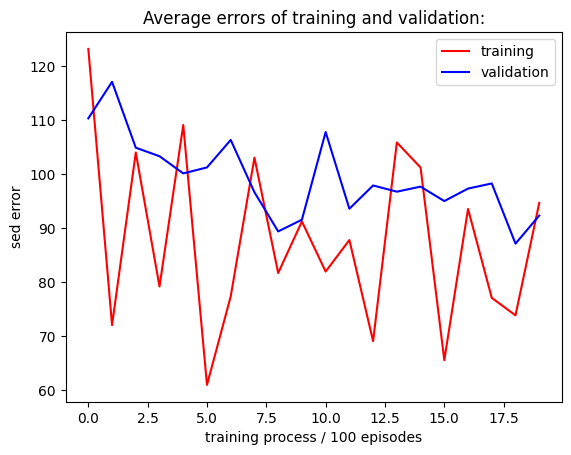

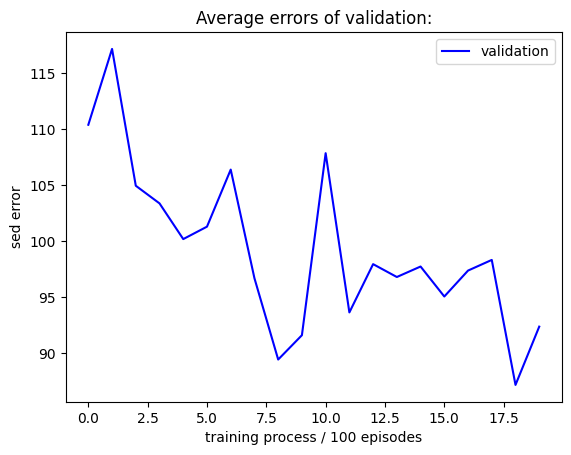

In [4]:
train(traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 11.220471858978271s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 0 episode 100: Training error: 59.52099703674142, Validation error: 66.61728257168153
Save model with error 66.61728257168153
==>current best model is 66.61728257168153 with ratio 0.1
It costs 205.00640058517456s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 0 episode 200: Training error: 27.26335706204733, Validation error: 59.51813798114052
Save model with error 59.51813798114052
==>current best model is 59.51813798114052 with ratio 0.1
It costs 203.31144094467163s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 1 episode 100: Training error: 47.63062710131066, Validation error: 64.88926813011852
==>current best model is 59.51813798114052 with ratio 0.1
It costs 186.5139844417572s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 1 episode 200: Training error: 34.4617259344491, Validation error: 64.27520383842094
==>current best model is 59.51813798114052 with ratio 0.1
It costs 219.1535186767578s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 2 episode 100: Training error: 52.2784109336837, Validation error: 63.958495553548616
==>current best model is 59.51813798114052 with ratio 0.1
It costs 204.10931825637817s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 2 episode 200: Training error: 29.513024969283816, Validation error: 62.192370396440246
==>current best model is 59.51813798114052 with ratio 0.1
It costs 199.6717300415039s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 3 episode 100: Training error: 45.81273819512597, Validation error: 59.89949622744692
==>current best model is 59.51813798114052 with ratio 0.1
It costs 196.0101444721222s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 3 episode 200: Training error: 31.961637058794054, Validation error: 60.836092444229756
==>current best model is 59.51813798114052 with ratio 0.1
It costs 208.01330733299255s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 4 episode 100: Training error: 32.30654671278222, Validation error: 61.17773704730587
==>current best model is 59.51813798114052 with ratio 0.1
It costs 193.59709358215332s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 4 episode 200: Training error: 50.35182683876512, Validation error: 62.125107681562
==>current best model is 59.51813798114052 with ratio 0.1
It costs 207.49300932884216s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 5 episode 100: Training error: 26.73695984236571, Validation error: 61.724987966492606
==>current best model is 59.51813798114052 with ratio 0.1
It costs 213.58951115608215s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 5 episode 200: Training error: 42.33396298794202, Validation error: 56.11928403785755
Save model with error 56.11928403785755
==>current best model is 56.11928403785755 with ratio 0.1
It costs 196.55830311775208s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 6 episode 100: Training error: 46.50996295400618, Validation error: 60.905585619099824
==>current best model is 56.11928403785755 with ratio 0.1
It costs 207.92413687705994s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 6 episode 200: Training error: 27.719224214150362, Validation error: 57.958293602416575
==>current best model is 56.11928403785755 with ratio 0.1
It costs 205.88167595863342s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 7 episode 100: Training error: 23.237824997481557, Validation error: 54.33374949898779
Save model with error 54.33374949898779
==>current best model is 54.33374949898779 with ratio 0.1
It costs 212.85788559913635s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 7 episode 200: Training error: 39.37185604912699, Validation error: 50.23541968180118
Save model with error 50.23541968180118
==>current best model is 50.23541968180118 with ratio 0.1
It costs 194.78222346305847s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 8 episode 100: Training error: 34.51369911841971, Validation error: 54.639366963962324
==>current best model is 50.23541968180118 with ratio 0.1
It costs 198.90019464492798s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 8 episode 200: Training error: 26.121233737733746, Validation error: 59.98160462046313
==>current best model is 50.23541968180118 with ratio 0.1
It costs 210.2274408340454s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 9 episode 100: Training error: 34.47723567504616, Validation error: 41.38291702112352
Save model with error 41.38291702112352
==>current best model is 41.38291702112352 with ratio 0.1
It costs 204.7871720790863s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


round 9 episode 200: Training error: 29.446198825293415, Validation error: 46.36345352110415
==>current best model is 41.38291702112352 with ratio 0.1
It costs 225.81935143470764s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 10 episode 100: Training error: 34.86518742829466, Validation error: 53.07430991728571
==>current best model is 41.38291702112352 with ratio 0.1
It costs 208.01978540420532s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 10 episode 200: Training error: 27.47106221195733, Validation error: 46.30712844206901
==>current best model is 41.38291702112352 with ratio 0.1
It costs 223.76140475273132s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 11 episode 100: Training error: 32.809929674513334, Validation error: 54.84432213450517
==>current best model is 41.38291702112352 with ratio 0.1
It costs 197.57160711288452s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 11 episode 200: Training error: 25.50496391428571, Validation error: 53.97088843560547
==>current best model is 41.38291702112352 with ratio 0.1
It costs 228.89509081840515s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 12 episode 100: Training error: 23.771837891369717, Validation error: 50.66915356384701
==>current best model is 41.38291702112352 with ratio 0.1
It costs 240.60807538032532s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


round 12 episode 200: Training error: 40.167322606843086, Validation error: 47.22025551728349
==>current best model is 41.38291702112352 with ratio 0.1
It costs 210.18089270591736s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


round 13 episode 100: Training error: 19.981585649226908, Validation error: 46.37051776855539
==>current best model is 41.38291702112352 with ratio 0.1
It costs 219.99626994132996s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 13 episode 200: Training error: 36.39339895173835, Validation error: 47.9251778026143
==>current best model is 41.38291702112352 with ratio 0.1
It costs 257.08955788612366s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 14 episode 100: Training error: 39.97689544035408, Validation error: 48.08856532860572
==>current best model is 41.38291702112352 with ratio 0.1
It costs 206.83248233795166s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 14 episode 200: Training error: 26.40939857540224, Validation error: 36.67478285506465
Save model with error 36.67478285506465
==>current best model is 36.67478285506465 with ratio 0.1
It costs 211.66641235351562s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


round 15 episode 100: Training error: 29.3177893391971, Validation error: 43.75340594683785
==>current best model is 36.67478285506465 with ratio 0.1
It costs 193.96942710876465s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 15 episode 200: Training error: 29.342110214466985, Validation error: 43.977536642635044
==>current best model is 36.67478285506465 with ratio 0.1
It costs 213.0161681175232s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 16 episode 100: Training error: 27.604789785424465, Validation error: 43.13981736072548
==>current best model is 36.67478285506465 with ratio 0.1
It costs 225.5335521697998s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


round 16 episode 200: Training error: 29.675801162440465, Validation error: 46.13201572066671
==>current best model is 36.67478285506465 with ratio 0.1
It costs 184.0747640132904s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


round 17 episode 100: Training error: 24.29155670878658, Validation error: 38.8021189657007
==>current best model is 36.67478285506465 with ratio 0.1
It costs 189.02717852592468s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 17 episode 200: Training error: 36.095882299571876, Validation error: 42.66907264280368
==>current best model is 36.67478285506465 with ratio 0.1
It costs 218.1768877506256s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 18 episode 100: Training error: 22.034048986310133, Validation error: 46.598507412745086
==>current best model is 36.67478285506465 with ratio 0.1
It costs 220.25919842720032s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


round 18 episode 200: Training error: 42.9551351934849, Validation error: 41.83622925825719
==>current best model is 36.67478285506465 with ratio 0.1
It costs 214.79635548591614s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 19 episode 100: Training error: 26.594665523504403, Validation error: 37.74698270470437
==>current best model is 36.67478285506465 with ratio 0.1
It costs 234.51264333724976s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 19 episode 200: Training error: 37.45614460946247, Validation error: 35.82961256221557
Save model with error 35.82961256221557
==>current best model is 35.82961256221557 with ratio 0.1
It costs 242.02011370658875s
Training elapsed time = %s 8434.220355510712


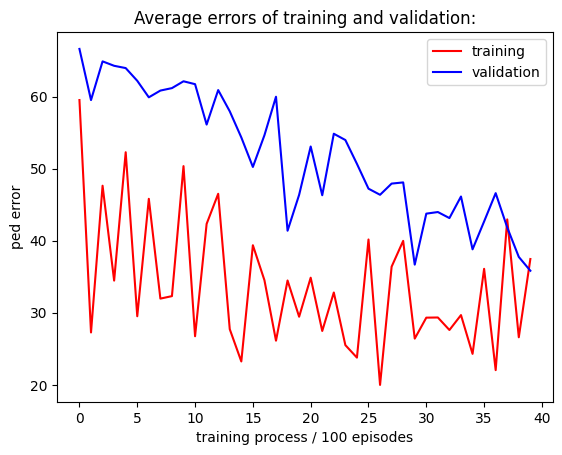

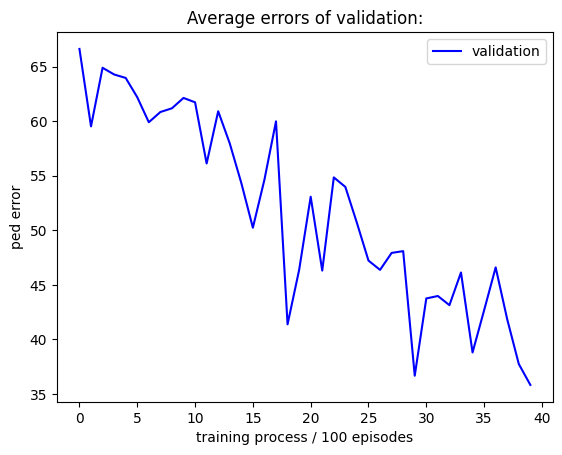

In [5]:
train(traj_amount=200, valid_amount=70, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======loading train data======
It cost 5.430909633636475s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


round 0 episode 100: Training error: 7.390569606370809, Validation error: 7.715912190204002
Save model with error 7.715912190204002
==>current best model is 7.715912190204002 with ratio 0.1
It costs 295.19722604751587s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


round 0 episode 200: Training error: 7.177813007801937, Validation error: 7.812335258568997
==>current best model is 7.715912190204002 with ratio 0.1
It costs 274.1161389350891s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 1 episode 100: Training error: 7.118518958146297, Validation error: 7.649351659223904
Save model with error 7.649351659223904
==>current best model is 7.649351659223904 with ratio 0.1
It costs 320.3056273460388s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


round 1 episode 200: Training error: 7.524662018637958, Validation error: 7.608962983077059
Save model with error 7.608962983077059
==>current best model is 7.608962983077059 with ratio 0.1
It costs 283.7864887714386s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 2 episode 100: Training error: 6.718978370017384, Validation error: 7.339158929546219
Save model with error 7.339158929546219
==>current best model is 7.339158929546219 with ratio 0.1
It costs 274.6095666885376s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 2 episode 200: Training error: 7.915472714113738, Validation error: 7.593689507550962
==>current best model is 7.339158929546219 with ratio 0.1
It costs 275.2599940299988s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]


round 3 episode 100: Training error: 7.130767542937795, Validation error: 6.763785943367619
Save model with error 6.763785943367619
==>current best model is 6.763785943367619 with ratio 0.1
It costs 315.68857407569885s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 3 episode 200: Training error: 7.098042168671511, Validation error: 7.872747592703617
==>current best model is 6.763785943367619 with ratio 0.1
It costs 265.09082412719727s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 4 episode 100: Training error: 6.849340406903545, Validation error: 7.590206325093527
==>current best model is 6.763785943367619 with ratio 0.1
It costs 272.74906063079834s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


round 4 episode 200: Training error: 7.429208516047297, Validation error: 7.579859710652876
==>current best model is 6.763785943367619 with ratio 0.1
It costs 272.8565123081207s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 5 episode 100: Training error: 6.938452681863068, Validation error: 7.572624344730639
==>current best model is 6.763785943367619 with ratio 0.1
It costs 270.37313890457153s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


round 5 episode 200: Training error: 7.437626696932835, Validation error: 7.7081203694576885
==>current best model is 6.763785943367619 with ratio 0.1
It costs 279.5628170967102s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


round 6 episode 100: Training error: 7.825118798715551, Validation error: 7.64246869156405
==>current best model is 6.763785943367619 with ratio 0.1
It costs 296.44070959091187s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 6 episode 200: Training error: 6.71999083963654, Validation error: 7.59530639848024
==>current best model is 6.763785943367619 with ratio 0.1
It costs 243.85324597358704s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


round 7 episode 100: Training error: 7.194281807621293, Validation error: 7.752368729413149
==>current best model is 6.763785943367619 with ratio 0.1
It costs 260.49248242378235s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


round 7 episode 200: Training error: 7.365228441990371, Validation error: 7.622876137536113
==>current best model is 6.763785943367619 with ratio 0.1
It costs 264.6814646720886s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.77s/it]


round 8 episode 100: Training error: 6.372303192741397, Validation error: 7.685101544743065
==>current best model is 6.763785943367619 with ratio 0.1
It costs 297.8024628162384s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


round 8 episode 200: Training error: 8.21181359773503, Validation error: 7.433416825067264
==>current best model is 6.763785943367619 with ratio 0.1
It costs 234.4980661869049s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 9 episode 100: Training error: 7.6758996421526, Validation error: 7.625656103992269
==>current best model is 6.763785943367619 with ratio 0.1
It costs 258.09866881370544s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


round 9 episode 200: Training error: 6.853364958942047, Validation error: 7.42442111229009
==>current best model is 6.763785943367619 with ratio 0.1
It costs 273.9768445491791s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


round 10 episode 100: Training error: 7.705292210942296, Validation error: 7.63443577490908
==>current best model is 6.763785943367619 with ratio 0.1
It costs 255.51214027404785s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 10 episode 200: Training error: 6.801421565781373, Validation error: 7.617433303133829
==>current best model is 6.763785943367619 with ratio 0.1
It costs 252.2234547138214s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 11 episode 100: Training error: 6.79123061150779, Validation error: 7.451627641481452
==>current best model is 6.763785943367619 with ratio 0.1
It costs 228.38212656974792s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 11 episode 200: Training error: 7.49889395043406, Validation error: 7.703347065629381
==>current best model is 6.763785943367619 with ratio 0.1
It costs 275.53561449050903s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


round 12 episode 100: Training error: 6.6994711302131, Validation error: 7.582566530024863
==>current best model is 6.763785943367619 with ratio 0.1
It costs 267.34750056266785s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 12 episode 200: Training error: 7.410416598747175, Validation error: 7.641508295522791
==>current best model is 6.763785943367619 with ratio 0.1
It costs 238.47464084625244s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 13 episode 100: Training error: 7.479714559161667, Validation error: 7.470112526618352
==>current best model is 6.763785943367619 with ratio 0.1
It costs 241.92768120765686s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


round 13 episode 200: Training error: 6.756370543344471, Validation error: 7.699143898598038
==>current best model is 6.763785943367619 with ratio 0.1
It costs 268.32399439811707s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 14 episode 100: Training error: 6.991151622265573, Validation error: 7.3782131493814305
==>current best model is 6.763785943367619 with ratio 0.1
It costs 275.39341497421265s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 14 episode 200: Training error: 7.302424723958141, Validation error: 7.683436301355359
==>current best model is 6.763785943367619 with ratio 0.1
It costs 228.5224130153656s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


round 15 episode 100: Training error: 7.524288510976138, Validation error: 7.501186192318073
==>current best model is 6.763785943367619 with ratio 0.1
It costs 257.29258251190186s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 15 episode 200: Training error: 6.629472302524632, Validation error: 7.556965843043078
==>current best model is 6.763785943367619 with ratio 0.1
It costs 244.27541160583496s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 16 episode 100: Training error: 7.892632442756355, Validation error: 7.586138812469689
==>current best model is 6.763785943367619 with ratio 0.1
It costs 250.06875348091125s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


round 16 episode 200: Training error: 6.507173539913734, Validation error: 7.371426306592025
==>current best model is 6.763785943367619 with ratio 0.1
It costs 255.97164225578308s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 17 episode 100: Training error: 7.27786817116714, Validation error: 7.587124311505655
==>current best model is 6.763785943367619 with ratio 0.1
It costs 258.16313099861145s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


round 17 episode 200: Training error: 7.280128440307666, Validation error: 7.628728799742365
==>current best model is 6.763785943367619 with ratio 0.1
It costs 245.14496684074402s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 18 episode 100: Training error: 7.997704189898806, Validation error: 7.659354976363133
==>current best model is 6.763785943367619 with ratio 0.1
It costs 242.89932107925415s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


round 18 episode 200: Training error: 6.2677287337123095, Validation error: 7.575052143005452
==>current best model is 6.763785943367619 with ratio 0.1
It costs 263.143372297287s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 19 episode 100: Training error: 7.054451791370908, Validation error: 7.450503980218177
==>current best model is 6.763785943367619 with ratio 0.1
It costs 246.96523594856262s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


round 19 episode 200: Training error: 7.266665198788522, Validation error: 7.7390493199382275
==>current best model is 6.763785943367619 with ratio 0.1
It costs 262.2208979129791s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 20 episode 100: Training error: 6.9421074546351225, Validation error: 7.5124613486586975
==>current best model is 6.763785943367619 with ratio 0.1
It costs 237.440194606781s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


round 20 episode 200: Training error: 7.516595281443255, Validation error: 7.679989819893324
==>current best model is 6.763785943367619 with ratio 0.1
It costs 269.81510186195374s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


round 21 episode 100: Training error: 7.287848847280506, Validation error: 7.509581355593829
==>current best model is 6.763785943367619 with ratio 0.1
It costs 266.6870017051697s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 21 episode 200: Training error: 7.061206509439007, Validation error: 7.6322630480297935
==>current best model is 6.763785943367619 with ratio 0.1
It costs 239.90635585784912s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 22 episode 100: Training error: 7.140751952776667, Validation error: 7.658452717280238
==>current best model is 6.763785943367619 with ratio 0.1
It costs 227.3132643699646s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


round 22 episode 200: Training error: 7.092897624584696, Validation error: 7.753559788457817
==>current best model is 6.763785943367619 with ratio 0.1
It costs 282.34119272232056s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 23 episode 100: Training error: 7.708942463102057, Validation error: 7.579525486835629
==>current best model is 6.763785943367619 with ratio 0.1
It costs 242.96105003356934s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 23 episode 200: Training error: 6.626303430204343, Validation error: 7.4560616141064395
==>current best model is 6.763785943367619 with ratio 0.1
It costs 266.74792885780334s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


round 24 episode 100: Training error: 7.452794964659493, Validation error: 7.606197260880138
==>current best model is 6.763785943367619 with ratio 0.1
It costs 269.90641260147095s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 24 episode 200: Training error: 6.749478102858949, Validation error: 7.503326535175513
==>current best model is 6.763785943367619 with ratio 0.1
It costs 239.66287994384766s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


round 25 episode 100: Training error: 7.629125696583469, Validation error: 7.565962250612568
==>current best model is 6.763785943367619 with ratio 0.1
It costs 255.49109625816345s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


round 25 episode 200: Training error: 6.631063643069986, Validation error: 7.60288215080161
==>current best model is 6.763785943367619 with ratio 0.1
It costs 252.84948229789734s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 26 episode 100: Training error: 7.1191897029872075, Validation error: 7.495867605176493
==>current best model is 6.763785943367619 with ratio 0.1
It costs 250.80766701698303s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 26 episode 200: Training error: 7.236484553906803, Validation error: 7.567826935200121
==>current best model is 6.763785943367619 with ratio 0.1
It costs 254.15681767463684s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 27 episode 100: Training error: 7.310089409166416, Validation error: 7.7252640750127854
==>current best model is 6.763785943367619 with ratio 0.1
It costs 251.8221206665039s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 27 episode 200: Training error: 6.798304080423453, Validation error: 7.346376367868913
==>current best model is 6.763785943367619 with ratio 0.1
It costs 261.8155677318573s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 28 episode 100: Training error: 7.117943507594272, Validation error: 7.612215436789164
==>current best model is 6.763785943367619 with ratio 0.1
It costs 254.7601978778839s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 28 episode 200: Training error: 7.133638203217096, Validation error: 7.532501103338836
==>current best model is 6.763785943367619 with ratio 0.1
It costs 253.51732540130615s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 29 episode 100: Training error: 6.631524808852356, Validation error: 7.557582431622596
==>current best model is 6.763785943367619 with ratio 0.1
It costs 260.5357780456543s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 29 episode 200: Training error: 7.752132355616554, Validation error: 7.416151990906016
==>current best model is 6.763785943367619 with ratio 0.1
It costs 245.70268058776855s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 30 episode 100: Training error: 7.100981361702123, Validation error: 7.643143070681778
==>current best model is 6.763785943367619 with ratio 0.1
It costs 240.07599902153015s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 30 episode 200: Training error: 7.118430128412619, Validation error: 7.440817271156479
==>current best model is 6.763785943367619 with ratio 0.1
It costs 268.2156436443329s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 31 episode 100: Training error: 7.632848468196784, Validation error: 7.49319239626361
==>current best model is 6.763785943367619 with ratio 0.1
It costs 258.93272948265076s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


round 31 episode 200: Training error: 6.71879385178503, Validation error: 7.675360963072127
==>current best model is 6.763785943367619 with ratio 0.1
It costs 253.69102454185486s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


round 32 episode 100: Training error: 7.12625281126386, Validation error: 7.406280841760614
==>current best model is 6.763785943367619 with ratio 0.1
It costs 257.57967615127563s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 32 episode 200: Training error: 7.189365832875206, Validation error: 7.4923740189415815
==>current best model is 6.763785943367619 with ratio 0.1
It costs 251.7170214653015s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 33 episode 100: Training error: 7.956194871562763, Validation error: 7.36496514897432
==>current best model is 6.763785943367619 with ratio 0.1
It costs 241.0476713180542s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


round 33 episode 200: Training error: 6.310694946493713, Validation error: 7.37269784292669
==>current best model is 6.763785943367619 with ratio 0.1
It costs 267.7022249698639s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 34 episode 100: Training error: 6.85193992150996, Validation error: 7.596484171377366
==>current best model is 6.763785943367619 with ratio 0.1
It costs 267.27464270591736s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


round 34 episode 200: Training error: 7.517181046279794, Validation error: 7.428544412187205
==>current best model is 6.763785943367619 with ratio 0.1
It costs 245.85386848449707s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 35 episode 100: Training error: 6.539341110566415, Validation error: 7.49034634634394
==>current best model is 6.763785943367619 with ratio 0.1
It costs 239.00496554374695s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


round 35 episode 200: Training error: 7.4683221632354995, Validation error: 7.578104115946402
==>current best model is 6.763785943367619 with ratio 0.1
It costs 270.1809117794037s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


round 36 episode 100: Training error: 6.651280867218794, Validation error: 7.527059908780041
==>current best model is 6.763785943367619 with ratio 0.1
It costs 274.2338230609894s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


round 36 episode 200: Training error: 7.508268455828393, Validation error: 7.655196715046358
==>current best model is 6.763785943367619 with ratio 0.1
It costs 238.61918187141418s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


round 37 episode 100: Training error: 6.678094959253287, Validation error: 7.496793803775474
==>current best model is 6.763785943367619 with ratio 0.1
It costs 274.60731053352356s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 37 episode 200: Training error: 7.433375354657178, Validation error: 7.49264030273376
==>current best model is 6.763785943367619 with ratio 0.1
It costs 235.04215836524963s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 38 episode 100: Training error: 6.88115736412494, Validation error: 7.485543145913513
==>current best model is 6.763785943367619 with ratio 0.1
It costs 254.27840900421143s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 38 episode 200: Training error: 7.268146047513567, Validation error: 7.496105450452108
==>current best model is 6.763785943367619 with ratio 0.1
It costs 257.9024803638458s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 39 episode 100: Training error: 7.812063881269021, Validation error: 7.541078281815199
==>current best model is 6.763785943367619 with ratio 0.1
It costs 257.0113251209259s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 39 episode 200: Training error: 6.060986629209159, Validation error: 7.400353532510141
==>current best model is 6.763785943367619 with ratio 0.1
It costs 248.432550907135s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 40 episode 100: Training error: 7.371734230408528, Validation error: 7.477479861828891
==>current best model is 6.763785943367619 with ratio 0.1
It costs 263.05737352371216s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 40 episode 200: Training error: 6.5708126446634285, Validation error: 7.498533616080751
==>current best model is 6.763785943367619 with ratio 0.1
It costs 243.7920949459076s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


round 41 episode 100: Training error: 7.693108592231953, Validation error: 7.419995359532015
==>current best model is 6.763785943367619 with ratio 0.1
It costs 242.06333899497986s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


round 41 episode 200: Training error: 6.5426068409328835, Validation error: 7.514534931280135
==>current best model is 6.763785943367619 with ratio 0.1
It costs 266.0309090614319s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


round 42 episode 100: Training error: 7.07888083045654, Validation error: 7.702827551153095
==>current best model is 6.763785943367619 with ratio 0.1
It costs 270.7837665081024s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 42 episode 200: Training error: 6.706275045554959, Validation error: 6.358052233561846
Save model with error 6.358052233561846
==>current best model is 6.358052233561846 with ratio 0.1
It costs 233.57108402252197s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 43 episode 100: Training error: 7.157102036502422, Validation error: 6.429639157093747
==>current best model is 6.358052233561846 with ratio 0.1
It costs 245.46381044387817s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 43 episode 200: Training error: 6.952925368040098, Validation error: 7.457638052936855
==>current best model is 6.358052233561846 with ratio 0.1
It costs 261.83322525024414s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


round 44 episode 100: Training error: 6.793719369563286, Validation error: 6.375537456345069
==>current best model is 6.358052233561846 with ratio 0.1
It costs 245.73222374916077s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 44 episode 200: Training error: 7.606461240437752, Validation error: 7.517494462385712
==>current best model is 6.358052233561846 with ratio 0.1
It costs 261.4520261287689s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


round 45 episode 100: Training error: 7.568693439968505, Validation error: 7.408747462640227
==>current best model is 6.358052233561846 with ratio 0.1
It costs 258.01107716560364s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 45 episode 200: Training error: 6.6795040535921615, Validation error: 6.247985267739242
Save model with error 6.247985267739242
==>current best model is 6.247985267739242 with ratio 0.1
It costs 248.51791644096375s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 46 episode 100: Training error: 7.051448533763565, Validation error: 7.35418681291317
==>current best model is 6.247985267739242 with ratio 0.1
It costs 250.55470943450928s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 46 episode 200: Training error: 6.566541306327775, Validation error: 7.044006765699362
==>current best model is 6.247985267739242 with ratio 0.1
It costs 259.54441356658936s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 47 episode 100: Training error: 7.0743401636128995, Validation error: 6.295854270815441
==>current best model is 6.247985267739242 with ratio 0.1
It costs 254.92509388923645s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


round 47 episode 200: Training error: 6.949495144374321, Validation error: 6.23633519644921
Save model with error 6.23633519644921
==>current best model is 6.23633519644921 with ratio 0.1
It costs 253.77159428596497s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 48 episode 100: Training error: 7.312335087745879, Validation error: 6.215516284177037
Save model with error 6.215516284177037
==>current best model is 6.215516284177037 with ratio 0.1
It costs 205.91885495185852s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


round 48 episode 200: Training error: 6.796698099761987, Validation error: 7.248076424977713
==>current best model is 6.215516284177037 with ratio 0.1
It costs 303.70405316352844s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 49 episode 100: Training error: 7.07913213046166, Validation error: 6.113351518848044
Save model with error 6.113351518848044
==>current best model is 6.113351518848044 with ratio 0.1
It costs 250.83288073539734s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 49 episode 200: Training error: 6.699671074619221, Validation error: 6.134896206365385
==>current best model is 6.113351518848044 with ratio 0.1
It costs 252.45788884162903s
Training elapsed time = %s 25844.904799699783


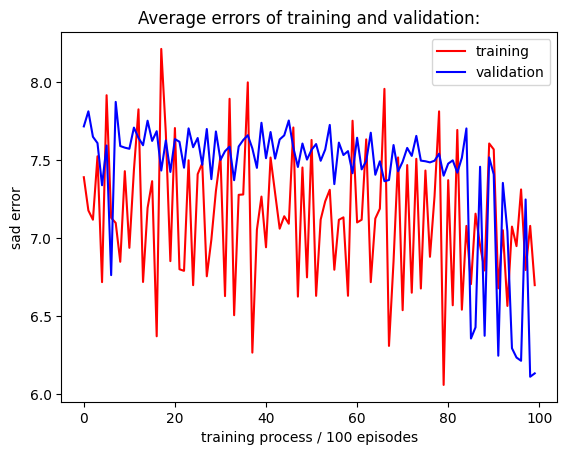

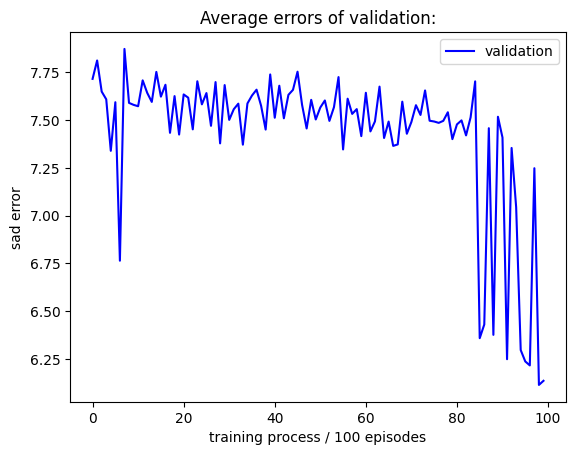

In [7]:
train(traj_amount=200, valid_amount=70, Round=50, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sad')

In [ ]:
train_ppo(traj_amount=100, valid_amount=50, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed', batch_size=8)

======loading train data======
It cost 3.5165841579437256s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




[100/100]:   0%|                                                            | 0/100 [00:00<?, ?it/s]

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.


D:\BiShe\my_code\tensorflow1版本\online-rlts\rl_ppo.py:112: RuntimeWarning: invalid value encountered in true_divide
  discounted_ep_rs /= np.std(discounted_ep_rs)
[100/100]:   0%|                                                            | 0/100 [03:33<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "F:\Anaconda\envs\tensorflow1_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\asus\AppData\Local\Temp\ipykernel_1480\2384401650.py", line 1, in <module>
    train_ppo(traj_amount=100, valid_amount=50, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed', batch_size=16)
  File "C:\Users\asus\AppData\Local\Temp\ipykernel_1480\2335372005.py", line 163, in train_ppo
    tra_av_errs, val_av_errs = run_ppo(env, RL, Round, traj_amount, valid_amount, show_time, ratio, batch_size)
  File "C:\Users\asus\AppData\Local\Temp\ipykernel_1480\2335372005.py", line 95, in run_ppo
    action1 = RL.pro_choose_action(state)
  File "D:\BiShe\my_code\tensorflow1版本\online-rlts\rl_ppo.py", line 58, in pro_choose_action
    action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel())  # select action w.r.t the actions prob
  File "mtra

======loading train data======
ERROR! Session/line number was not unique in database. History logging moved to new session 324
It cost 3.726935386657715s.


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 0 episode 100: Training error: 134.01094455900886, Validation error: 58.0717512054923



Save model with error 58.0717512054923
==>current best model is 58.0717512054923 with ratio 0.1
It costs 217.0690279006958s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 1 episode 100: Training error: 129.71836633615962, Validation error: 61.45864095150348
==>current best model is 58.0717512054923 with ratio 0.1
It costs 213.3197684288025s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


round 2 episode 100: Training error: 126.88684618828893, Validation error: 59.590747616230104
==>current best model is 58.0717512054923 with ratio 0.1
It costs 217.30619049072266s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


round 3 episode 100: Training error: 127.22273285826823, Validation error: 55.58550629659836
Save model with error 55.58550629659836
==>current best model is 55.58550629659836 with ratio 0.1
It costs 215.03188276290894s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 4 episode 100: Training error: 125.75802632309477, Validation error: 54.19318713336558
Save model with error 54.19318713336558
==>current best model is 54.19318713336558 with ratio 0.1
It costs 215.42112016677856s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 5 episode 100: Training error: 121.61344427917582, Validation error: 54.15733534010812
Save model with error 54.15733534010812
==>current best model is 54.15733534010812 with ratio 0.1
It costs 213.14025783538818s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 6 episode 100: Training error: 123.95706440333572, Validation error: 59.654693118064316
==>current best model is 54.15733534010812 with ratio 0.1
It costs 216.49847793579102s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


round 7 episode 100: Training error: 120.78773018840653, Validation error: 52.10649915902146
Save model with error 52.10649915902146
==>current best model is 52.10649915902146 with ratio 0.1
It costs 216.94701838493347s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


round 8 episode 100: Training error: 122.81042947078869, Validation error: 48.92567019287236
Save model with error 48.92567019287236
==>current best model is 48.92567019287236 with ratio 0.1
It costs 214.21153950691223s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 9 episode 100: Training error: 118.63097642298193, Validation error: 51.75407034443814
==>current best model is 48.92567019287236 with ratio 0.1
It costs 216.24325513839722s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


round 10 episode 100: Training error: 120.2977255106405, Validation error: 50.973152048751274
==>current best model is 48.92567019287236 with ratio 0.1
It costs 215.07356214523315s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


round 11 episode 100: Training error: 121.92390344886113, Validation error: 47.69834008961567
Save model with error 47.69834008961567
==>current best model is 47.69834008961567 with ratio 0.1
It costs 216.20976543426514s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 12 episode 100: Training error: 118.2592623167318, Validation error: 51.620027216205145
==>current best model is 47.69834008961567 with ratio 0.1
It costs 214.78847861289978s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 13 episode 100: Training error: 118.64250781267452, Validation error: 50.744267080753225
==>current best model is 47.69834008961567 with ratio 0.1
It costs 213.48509335517883s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 14 episode 100: Training error: 118.47799741881798, Validation error: 48.03181007612853
==>current best model is 47.69834008961567 with ratio 0.1
It costs 214.20398831367493s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 15 episode 100: Training error: 123.25314299679789, Validation error: 47.889429617605884
==>current best model is 47.69834008961567 with ratio 0.1
It costs 215.0702302455902s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 16 episode 100: Training error: 112.48211096304068, Validation error: 52.20629670169153
==>current best model is 47.69834008961567 with ratio 0.1
It costs 212.35623788833618s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


round 17 episode 100: Training error: 126.02035361616618, Validation error: 46.67083432399366
Save model with error 46.67083432399366
==>current best model is 46.67083432399366 with ratio 0.1
It costs 215.77400064468384s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 18 episode 100: Training error: 127.46286789976084, Validation error: 48.47266545859176
==>current best model is 46.67083432399366 with ratio 0.1
It costs 212.73703122138977s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


round 19 episode 100: Training error: 119.09986119851055, Validation error: 47.621363428496615
==>current best model is 46.67083432399366 with ratio 0.1
It costs 210.1325113773346s
Training elapsed time = %s 4295.0216562747955


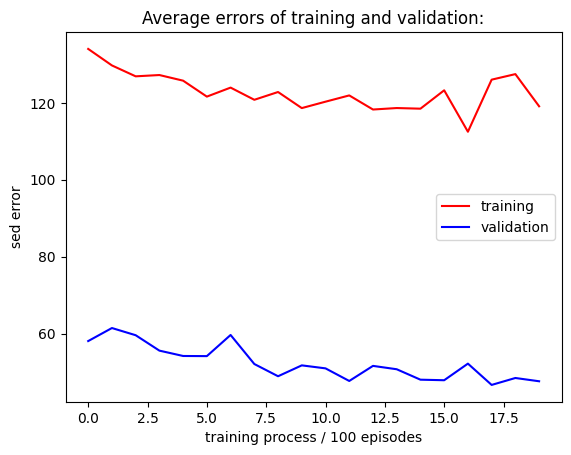

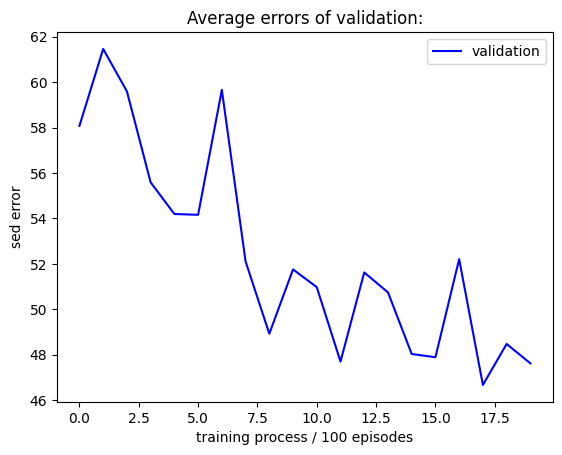

In [4]:
train(traj_amount=100, valid_amount=50, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 7.422472238540649s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


round 0 episode 100: Training error: 2.0288635648826774, Validation error: 1.5921051008002112

Save model with error 1.5921051008002112
==>current best model is 1.5921051008002112 with ratio 0.1
It costs 221.28523564338684s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


round 1 episode 100: Training error: 2.00307985871118, Validation error: 1.6152225652980001
==>current best model is 1.5921051008002112 with ratio 0.1
It costs 213.89143252372742s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


round 2 episode 100: Training error: 2.0027564100852415, Validation error: 1.6163332925398695
==>current best model is 1.5921051008002112 with ratio 0.1
It costs 219.39615964889526s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 3 episode 100: Training error: 2.01010227324776, Validation error: 1.541622600196632
Save model with error 1.541622600196632
==>current best model is 1.541622600196632 with ratio 0.1
It costs 154.361882686615s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 4 episode 100: Training error: 2.001293879715163, Validation error: 1.564563321954381
==>current best model is 1.541622600196632 with ratio 0.1
It costs 162.31433606147766s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 5 episode 100: Training error: 2.0025677834950106, Validation error: 1.564454615256324
==>current best model is 1.541622600196632 with ratio 0.1
It costs 156.86051535606384s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 6 episode 100: Training error: 1.995033643866282, Validation error: 1.6163714879602833
==>current best model is 1.541622600196632 with ratio 0.1
It costs 153.38963794708252s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 7 episode 100: Training error: 2.0029848742385337, Validation error: 1.597654594177443
==>current best model is 1.541622600196632 with ratio 0.1
It costs 153.13265776634216s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 8 episode 100: Training error: 2.012832895764865, Validation error: 1.5811154291960658
==>current best model is 1.541622600196632 with ratio 0.1
It costs 154.11219310760498s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 9 episode 100: Training error: 2.0302609928261406, Validation error: 1.5563042957842717
==>current best model is 1.541622600196632 with ratio 0.1
It costs 151.92136120796204s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 10 episode 100: Training error: 1.9985604941486854, Validation error: 1.555590013458694
==>current best model is 1.541622600196632 with ratio 0.1
It costs 151.41075015068054s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 11 episode 100: Training error: 1.9508144288229103, Validation error: 1.547887133135933
==>current best model is 1.541622600196632 with ratio 0.1
It costs 153.87754797935486s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 12 episode 100: Training error: 1.981299832411369, Validation error: 1.6081803870138764
==>current best model is 1.541622600196632 with ratio 0.1
It costs 152.29274773597717s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 13 episode 100: Training error: 1.9914845648835944, Validation error: 1.5641989414296438
==>current best model is 1.541622600196632 with ratio 0.1
It costs 151.72167778015137s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 14 episode 100: Training error: 1.9938758390317384, Validation error: 1.5614878572282456
==>current best model is 1.541622600196632 with ratio 0.1
It costs 159.22020816802979s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 15 episode 100: Training error: 1.9787954518361925, Validation error: 1.5657910241370894
==>current best model is 1.541622600196632 with ratio 0.1
It costs 154.39877891540527s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 16 episode 100: Training error: 1.985495773458902, Validation error: 1.5801280829209046
==>current best model is 1.541622600196632 with ratio 0.1
It costs 161.471910238266s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 17 episode 100: Training error: 1.9999914945170416, Validation error: 1.5575772368773466
==>current best model is 1.541622600196632 with ratio 0.1
It costs 152.7708134651184s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 18 episode 100: Training error: 1.9839591616709047, Validation error: 1.5609888988902363
==>current best model is 1.541622600196632 with ratio 0.1
It costs 154.49156856536865s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 19 episode 100: Training error: 2.030396370008256, Validation error: 1.577736704896233
==>current best model is 1.541622600196632 with ratio 0.1
It costs 162.60479259490967s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 20 episode 100: Training error: 1.9893430016155833, Validation error: 1.549351713858144
==>current best model is 1.541622600196632 with ratio 0.1
It costs 157.93829083442688s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 21 episode 100: Training error: 1.995539960491067, Validation error: 1.536000775515557
Save model with error 1.536000775515557
==>current best model is 1.536000775515557 with ratio 0.1
It costs 157.18203496932983s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 22 episode 100: Training error: 1.9603900601625623, Validation error: 1.5857718410626456
==>current best model is 1.536000775515557 with ratio 0.1
It costs 161.75143694877625s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 23 episode 100: Training error: 2.0161941538759276, Validation error: 1.5802345365276276
==>current best model is 1.536000775515557 with ratio 0.1
It costs 147.68833422660828s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 24 episode 100: Training error: 1.9789768984704224, Validation error: 1.573874882907079
==>current best model is 1.536000775515557 with ratio 0.1
It costs 146.09243607521057s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


round 25 episode 100: Training error: 1.971489141968754, Validation error: 1.543357956895862
==>current best model is 1.536000775515557 with ratio 0.1
It costs 143.04276275634766s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 26 episode 100: Training error: 1.9743843551667886, Validation error: 1.555805879570404
==>current best model is 1.536000775515557 with ratio 0.1
It costs 143.17988085746765s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 27 episode 100: Training error: 1.9788518403553002, Validation error: 1.5779983132657134
==>current best model is 1.536000775515557 with ratio 0.1
It costs 141.7755389213562s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 28 episode 100: Training error: 1.9677745860202176, Validation error: 1.5649364591153165
==>current best model is 1.536000775515557 with ratio 0.1
It costs 139.0150969028473s


[100/100]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


round 29 episode 100: Training error: 2.003357820014749, Validation error: 1.5198487086012347
Save model with error 1.5198487086012347
==>current best model is 1.5198487086012347 with ratio 0.1
It costs 144.06324815750122s
Training elapsed time = %s 4776.656387805939


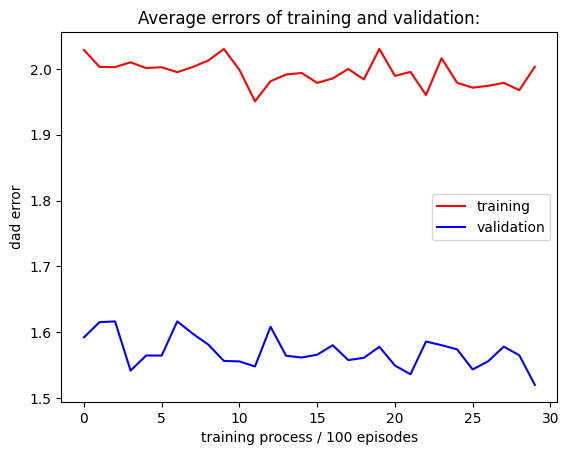

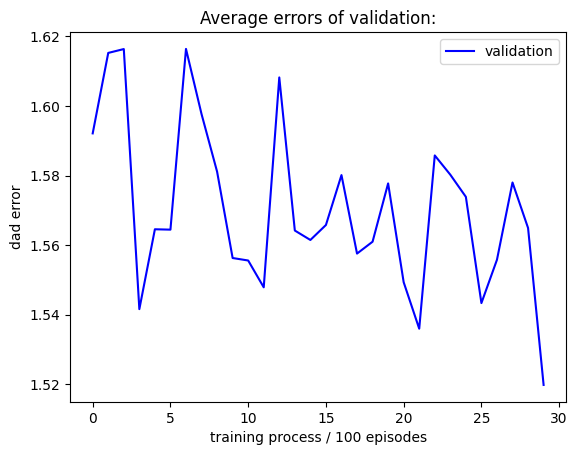

In [4]:
train(traj_amount=100, valid_amount=50, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======loading train data======
It cost 11.085381984710693s.


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:29<00:00,  1.05s/it]


round 0 episode 200: Training error: 1.8546911505993526, Validation error: 1.7240121206463506
Save model with error 1.7240121206463506
==>current best model is 1.7240121206463506 with ratio 0.1
It costs 304.5886266231537s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:23<00:00,  1.02s/it]


round 1 episode 200: Training error: 1.862749159533277, Validation error: 1.68498619335149
Save model with error 1.68498619335149
==>current best model is 1.68498619335149 with ratio 0.1
It costs 300.9882550239563s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:24<00:00,  1.02s/it]


round 2 episode 200: Training error: 1.8454085144131744, Validation error: 1.7204526976525545
==>current best model is 1.68498619335149 with ratio 0.1
It costs 300.636518239975s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:38<00:00,  1.09s/it]


round 3 episode 200: Training error: 1.8668124615269142, Validation error: 1.7143551852911578
==>current best model is 1.68498619335149 with ratio 0.1
It costs 314.1528763771057s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:25<00:00,  1.03s/it]


round 4 episode 200: Training error: 1.851053066498023, Validation error: 1.7414714286820476
==>current best model is 1.68498619335149 with ratio 0.1
It costs 301.0886583328247s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:27<00:00,  1.04s/it]


round 5 episode 200: Training error: 1.848349478422636, Validation error: 1.724411241088434
==>current best model is 1.68498619335149 with ratio 0.1
It costs 302.14454770088196s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:24<00:00,  1.02s/it]


round 6 episode 200: Training error: 1.8536449747134986, Validation error: 1.7280909866230765
==>current best model is 1.68498619335149 with ratio 0.1
It costs 299.3107445240021s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:22<00:00,  1.01s/it]


round 7 episode 200: Training error: 1.8446654595134497, Validation error: 1.7471368378392778
==>current best model is 1.68498619335149 with ratio 0.1
It costs 298.2280135154724s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:40<00:00,  1.10s/it]


round 8 episode 200: Training error: 1.8742982936711468, Validation error: 1.7376385489660526
==>current best model is 1.68498619335149 with ratio 0.1
It costs 327.95000171661377s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:49<00:00,  1.15s/it]


round 9 episode 200: Training error: 1.8532266687936925, Validation error: 1.6775752353487186
Save model with error 1.6775752353487186
==>current best model is 1.6775752353487186 with ratio 0.1
It costs 333.00833439826965s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:51<00:00,  1.16s/it]


round 10 episode 200: Training error: 1.8364883021060603, Validation error: 1.6565620164111
Save model with error 1.6565620164111
==>current best model is 1.6565620164111 with ratio 0.1
It costs 340.9993269443512s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:39<00:00,  1.10s/it]


round 11 episode 200: Training error: 1.8145361533120614, Validation error: 1.6520586058023277
Save model with error 1.6520586058023277
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 316.8099057674408s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:39<00:00,  1.10s/it]


round 12 episode 200: Training error: 1.8235247962877283, Validation error: 1.691489031147
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 315.0392324924469s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:59<00:00,  1.20s/it]


round 13 episode 200: Training error: 1.8145956766972065, Validation error: 1.6693875596676244
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 343.456725358963s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:39<00:00,  1.10s/it]


round 14 episode 200: Training error: 1.8125001938782825, Validation error: 1.6790255318614322
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 319.6063711643219s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:28<00:00,  1.04s/it]


round 15 episode 200: Training error: 1.8037041199606492, Validation error: 1.6765100318412378
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 301.9625828266144s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:31<00:00,  1.06s/it]


round 16 episode 200: Training error: 1.7943909725155256, Validation error: 1.6683694675029237
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 324.2560031414032s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:35<00:00,  1.08s/it]


round 17 episode 200: Training error: 1.7869383919227984, Validation error: 1.65850705169018
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 320.9061152935028s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:42<00:00,  1.11s/it]


round 18 episode 200: Training error: 1.8394317523619632, Validation error: 1.6548759328828895
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 321.90055990219116s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:31<00:00,  1.06s/it]


round 19 episode 200: Training error: 1.789738889257143, Validation error: 1.6731399569988417
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 306.9926857948303s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:23<00:00,  1.02s/it]


round 20 episode 200: Training error: 1.7908503690935753, Validation error: 1.6587866439123367
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 296.944447517395s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:22<00:00,  1.01s/it]


round 21 episode 200: Training error: 1.7797718811442467, Validation error: 1.6566588281917731
==>current best model is 1.6520586058023277 with ratio 0.1
It costs 303.2750642299652s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:20<00:00,  1.00s/it]


round 22 episode 200: Training error: 1.7837667464740607, Validation error: 1.6284660610211141
Save model with error 1.6284660610211141
==>current best model is 1.6284660610211141 with ratio 0.1
It costs 302.48103046417236s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:36<00:00,  1.08s/it]


round 23 episode 200: Training error: 1.7818679768365326, Validation error: 1.6827709247963518
==>current best model is 1.6284660610211141 with ratio 0.1
It costs 314.0223150253296s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:34<00:00,  1.07s/it]


round 24 episode 200: Training error: 1.7813941648829228, Validation error: 1.647640461955697
==>current best model is 1.6284660610211141 with ratio 0.1
It costs 316.8943045139313s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:29<00:00,  1.05s/it]


round 25 episode 200: Training error: 1.7962718883522064, Validation error: 1.6490694518515254
==>current best model is 1.6284660610211141 with ratio 0.1
It costs 308.1291103363037s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:34<00:00,  1.07s/it]


round 26 episode 200: Training error: 1.7976431226556875, Validation error: 1.6559008732626133
==>current best model is 1.6284660610211141 with ratio 0.1
It costs 317.85607647895813s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:47<00:00,  1.14s/it]


round 27 episode 200: Training error: 1.784697346917692, Validation error: 1.6876440046105823
==>current best model is 1.6284660610211141 with ratio 0.1
It costs 331.004102230072s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:39<00:00,  1.10s/it]


round 28 episode 200: Training error: 1.7847395115460762, Validation error: 1.6560845459047295
==>current best model is 1.6284660610211141 with ratio 0.1
It costs 319.71748995780945s


[200/200]: 100%|██████████████████████████████████████████████████| 200/200 [03:41<00:00,  1.11s/it]


round 29 episode 200: Training error: 1.7834568231316394, Validation error: 1.6601465388509398
==>current best model is 1.6284660610211141 with ratio 0.1
It costs 335.1431038379669s
Training elapsed time = %s 9439.495588064194


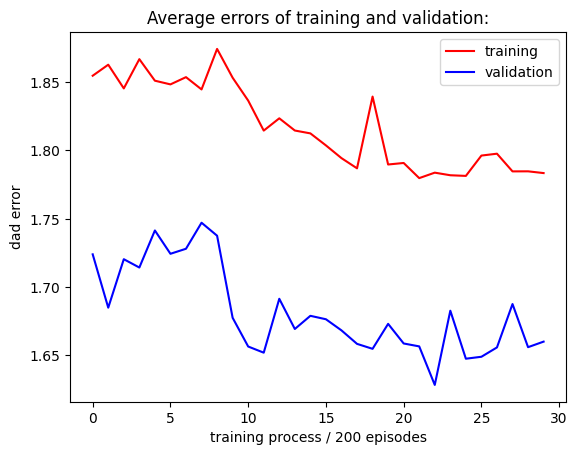

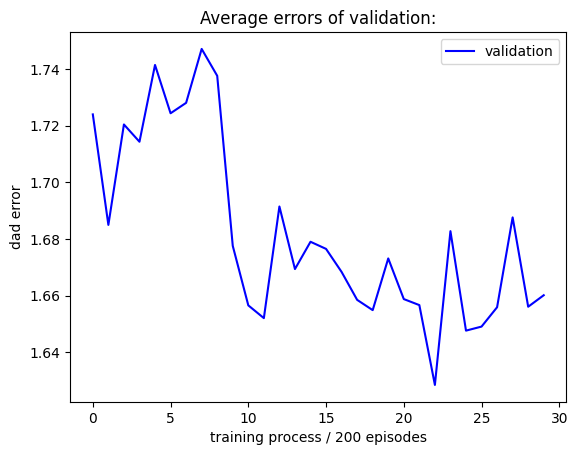

In [5]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=200, ratio=0.1, a_size=3, s_size=3, label='dad')

======loading train data======
It cost 12.847028493881226s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


round 0 episode 100: Training error: 94.29336399414758, Validation error: 98.36548565838876
Save model with error 98.36548565838876
==>current best model is 98.36548565838876 with ratio 0.1
It costs 284.38856840133667s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 0 episode 200: Training error: 78.9131169681578, Validation error: 95.05123068539531
Save model with error 95.05123068539531
==>current best model is 95.05123068539531 with ratio 0.1
It costs 272.18636322021484s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 1 episode 100: Training error: 115.46603940145789, Validation error: 99.59878746921893
==>current best model is 95.05123068539531 with ratio 0.1
It costs 270.84588718414307s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


round 1 episode 200: Training error: 53.766624485559824, Validation error: 89.015895369525
Save model with error 89.015895369525
==>current best model is 89.015895369525 with ratio 0.1
It costs 284.55315709114075s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 2 episode 100: Training error: 86.47558039717447, Validation error: 96.11326663428916
==>current best model is 89.015895369525 with ratio 0.1
It costs 289.7811839580536s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 2 episode 200: Training error: 81.34084060693571, Validation error: 114.6685109127186
==>current best model is 89.015895369525 with ratio 0.1
It costs 265.4457414150238s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 3 episode 100: Training error: 118.49272085447626, Validation error: 96.1239636853757
==>current best model is 89.015895369525 with ratio 0.1
It costs 266.33965158462524s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 3 episode 200: Training error: 61.2753907415494, Validation error: 92.33698931149536
==>current best model is 89.015895369525 with ratio 0.1
It costs 292.2832429409027s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


round 4 episode 100: Training error: 101.55913325905432, Validation error: 93.01671658464716
==>current best model is 89.015895369525 with ratio 0.1
It costs 279.3288288116455s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


round 4 episode 200: Training error: 69.95310942920509, Validation error: 97.8041757986887
==>current best model is 89.015895369525 with ratio 0.1
It costs 277.7271285057068s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


round 5 episode 100: Training error: 90.3637953168803, Validation error: 95.59595557058962
==>current best model is 89.015895369525 with ratio 0.1
It costs 285.17988777160645s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


round 5 episode 200: Training error: 82.89845734380003, Validation error: 89.08632337831712
==>current best model is 89.015895369525 with ratio 0.1
It costs 269.9940493106842s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


round 6 episode 100: Training error: 97.72704858474326, Validation error: 92.28177512357323
==>current best model is 89.015895369525 with ratio 0.1
It costs 268.59309673309326s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


round 6 episode 200: Training error: 70.44004981755755, Validation error: 85.80294417228927
Save model with error 85.80294417228927
==>current best model is 85.80294417228927 with ratio 0.1
It costs 282.76653027534485s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


round 7 episode 100: Training error: 61.057118982935506, Validation error: 85.4801790685195
Save model with error 85.4801790685195
==>current best model is 85.4801790685195 with ratio 0.1
It costs 301.1835746765137s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


round 7 episode 200: Training error: 109.2198012245346, Validation error: 86.96148796094107
==>current best model is 85.4801790685195 with ratio 0.1
It costs 254.9029221534729s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


round 8 episode 100: Training error: 89.15091812605398, Validation error: 87.22766956721519
==>current best model is 85.4801790685195 with ratio 0.1
It costs 294.8911588191986s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 8 episode 200: Training error: 78.88022007601715, Validation error: 97.89378616276115
==>current best model is 85.4801790685195 with ratio 0.1
It costs 261.67385840415955s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


round 9 episode 100: Training error: 66.95784363065957, Validation error: 92.69203670876227
==>current best model is 85.4801790685195 with ratio 0.1
It costs 271.5418224334717s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 9 episode 200: Training error: 102.26447847995078, Validation error: 91.41355808890948
==>current best model is 85.4801790685195 with ratio 0.1
It costs 282.04707050323486s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 10 episode 100: Training error: 120.94217434312583, Validation error: 88.01643938885681
==>current best model is 85.4801790685195 with ratio 0.1
It costs 262.8842599391937s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 10 episode 200: Training error: 44.11891787522946, Validation error: 94.22569419469237
==>current best model is 85.4801790685195 with ratio 0.1
It costs 290.2930963039398s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


round 11 episode 100: Training error: 64.57915687031874, Validation error: 87.66410044930252
==>current best model is 85.4801790685195 with ratio 0.1
It costs 293.27977323532104s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 11 episode 200: Training error: 100.37738793880045, Validation error: 92.93063853671823
==>current best model is 85.4801790685195 with ratio 0.1
It costs 268.49020862579346s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


round 12 episode 100: Training error: 57.055793557813125, Validation error: 91.9214324404615
==>current best model is 85.4801790685195 with ratio 0.1
It costs 300.4790759086609s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 12 episode 200: Training error: 107.54295749377188, Validation error: 88.75707172596786
==>current best model is 85.4801790685195 with ratio 0.1
It costs 255.739595413208s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.84s/it]


round 13 episode 100: Training error: 100.15254879036208, Validation error: 85.96902510832813
==>current best model is 85.4801790685195 with ratio 0.1
It costs 317.12703919410706s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 13 episode 200: Training error: 69.10320393719823, Validation error: 101.73697758290609
==>current best model is 85.4801790685195 with ratio 0.1
It costs 243.72659015655518s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 14 episode 100: Training error: 72.98045789307687, Validation error: 92.87456649387383
==>current best model is 85.4801790685195 with ratio 0.1
It costs 276.4903700351715s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


round 14 episode 200: Training error: 95.5385166643172, Validation error: 92.05970454853293
==>current best model is 85.4801790685195 with ratio 0.1
It costs 282.0809578895569s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 15 episode 100: Training error: 82.69453930968459, Validation error: 94.42897498967713
==>current best model is 85.4801790685195 with ratio 0.1
It costs 257.02530884742737s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


round 15 episode 200: Training error: 90.6503077287603, Validation error: 93.45046236058536
==>current best model is 85.4801790685195 with ratio 0.1
It costs 298.2071249485016s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 16 episode 100: Training error: 86.83696405912765, Validation error: 97.55170163381285
==>current best model is 85.4801790685195 with ratio 0.1
It costs 267.218013048172s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


round 16 episode 200: Training error: 81.835881315148, Validation error: 86.26214463239623
==>current best model is 85.4801790685195 with ratio 0.1
It costs 299.0122630596161s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


round 17 episode 100: Training error: 105.87433733644617, Validation error: 88.07330402267296
==>current best model is 85.4801790685195 with ratio 0.1
It costs 309.6317312717438s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 17 episode 200: Training error: 65.96912519016517, Validation error: 89.26269638693016
==>current best model is 85.4801790685195 with ratio 0.1
It costs 256.1125383377075s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 18 episode 100: Training error: 72.53649781639136, Validation error: 91.42195956682865
==>current best model is 85.4801790685195 with ratio 0.1
It costs 268.3190176486969s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


round 18 episode 200: Training error: 97.06543597549626, Validation error: 95.06037952610167
==>current best model is 85.4801790685195 with ratio 0.1
It costs 290.77141976356506s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


round 19 episode 100: Training error: 70.15933270850353, Validation error: 91.81074907132424
==>current best model is 85.4801790685195 with ratio 0.1
It costs 289.3419051170349s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 19 episode 200: Training error: 96.75065890467137, Validation error: 88.55109980256131
==>current best model is 85.4801790685195 with ratio 0.1
It costs 270.4642765522003s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


round 20 episode 100: Training error: 96.11340077675874, Validation error: 91.80871843414016
==>current best model is 85.4801790685195 with ratio 0.1
It costs 277.7096724510193s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 20 episode 200: Training error: 69.94701664241899, Validation error: 85.79980479467459
==>current best model is 85.4801790685195 with ratio 0.1
It costs 282.8650367259979s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


round 21 episode 100: Training error: 103.28996430301972, Validation error: 88.48537147926666
==>current best model is 85.4801790685195 with ratio 0.1
It costs 292.9744358062744s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 21 episode 200: Training error: 70.71816804553644, Validation error: 83.20056183876117
Save model with error 83.20056183876117
==>current best model is 83.20056183876117 with ratio 0.1
It costs 269.6381621360779s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 22 episode 100: Training error: 64.62468976961341, Validation error: 87.42586500558986
==>current best model is 83.20056183876117 with ratio 0.1
It costs 275.2408015727997s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


round 22 episode 200: Training error: 99.89054380907757, Validation error: 89.32743088186193
==>current best model is 83.20056183876117 with ratio 0.1
It costs 285.3338043689728s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 23 episode 100: Training error: 58.18448046705544, Validation error: 87.90572762637593
==>current best model is 83.20056183876117 with ratio 0.1
It costs 263.69023275375366s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


round 23 episode 200: Training error: 106.7309732215501, Validation error: 91.39928198806639
==>current best model is 83.20056183876117 with ratio 0.1
It costs 300.6613209247589s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


round 24 episode 100: Training error: 92.49964903696478, Validation error: 91.38525273219584
==>current best model is 83.20056183876117 with ratio 0.1
It costs 297.8352241516113s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


round 24 episode 200: Training error: 73.33590569900731, Validation error: 85.47522810110172
==>current best model is 83.20056183876117 with ratio 0.1
It costs 264.79794096946716s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/it]


round 25 episode 100: Training error: 70.75937801637016, Validation error: 89.75865164799832
==>current best model is 83.20056183876117 with ratio 0.1
It costs 303.22002625465393s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 25 episode 200: Training error: 101.55121439819952, Validation error: 86.52898345416055
==>current best model is 83.20056183876117 with ratio 0.1
It costs 259.2960789203644s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 26 episode 100: Training error: 91.53686389639859, Validation error: 83.96616649169776
==>current best model is 83.20056183876117 with ratio 0.1
It costs 277.2460460662842s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


round 26 episode 200: Training error: 80.9739228184776, Validation error: 84.71220523051491
==>current best model is 83.20056183876117 with ratio 0.1
It costs 290.64677691459656s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 27 episode 100: Training error: 75.12446423498642, Validation error: 93.12879631977204
==>current best model is 83.20056183876117 with ratio 0.1
It costs 283.26986145973206s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


round 27 episode 200: Training error: 95.15358457762223, Validation error: 87.53600855204397
==>current best model is 83.20056183876117 with ratio 0.1
It costs 279.32219767570496s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


round 28 episode 100: Training error: 47.53128180163777, Validation error: 85.73314230221642
==>current best model is 83.20056183876117 with ratio 0.1
It costs 297.0002269744873s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 28 episode 200: Training error: 116.55322992066247, Validation error: 87.59204412396002
==>current best model is 83.20056183876117 with ratio 0.1
It costs 263.1185736656189s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 29 episode 100: Training error: 84.3752324771219, Validation error: 93.29113272233876
==>current best model is 83.20056183876117 with ratio 0.1
It costs 270.27996015548706s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


round 29 episode 200: Training error: 88.9699340636156, Validation error: 85.74131095183205
==>current best model is 83.20056183876117 with ratio 0.1
It costs 290.0206615924835s
Training elapsed time = %s 16776.52070403099


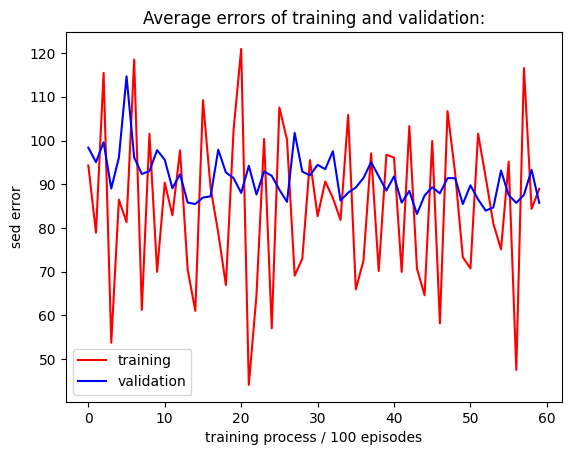

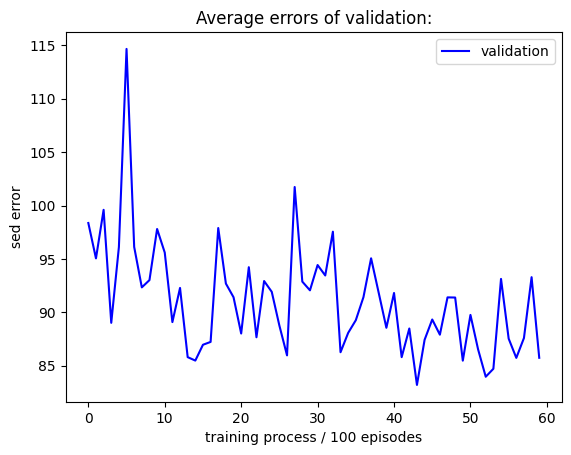

In [6]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed')#main

======loading train data======
It cost 12.812937021255493s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 0 episode 100: Training error: 32.65489665089061, Validation error: 55.99690124282555
Save model with error 55.99690124282555
==>current best model is 55.99690124282555 with ratio 0.1
It costs 249.2934491634369s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


round 0 episode 200: Training error: 42.165007326285505, Validation error: 59.61459695342126
==>current best model is 55.99690124282555 with ratio 0.1
It costs 283.80893445014954s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 1 episode 100: Training error: 27.51249232705395, Validation error: 57.75312249081681
==>current best model is 55.99690124282555 with ratio 0.1
It costs 256.59962153434753s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 1 episode 200: Training error: 36.49223060572973, Validation error: 57.8524883692545
==>current best model is 55.99690124282555 with ratio 0.1
It costs 279.209748506546s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 2 episode 100: Training error: 23.894689846667944, Validation error: 52.00629906990472
Save model with error 52.00629906990472
==>current best model is 52.00629906990472 with ratio 0.1
It costs 258.8736803531647s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


round 2 episode 200: Training error: 38.36816325015509, Validation error: 47.89014631417289
Save model with error 47.89014631417289
==>current best model is 47.89014631417289 with ratio 0.1
It costs 280.94322443008423s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


round 3 episode 100: Training error: 23.27478779876735, Validation error: 54.41767899172732
==>current best model is 47.89014631417289 with ratio 0.1
It costs 274.0319790840149s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 3 episode 200: Training error: 41.76903559613223, Validation error: 58.65272043773374
==>current best model is 47.89014631417289 with ratio 0.1
It costs 252.69983291625977s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 4 episode 100: Training error: 35.23988021053379, Validation error: 51.8720832473345
==>current best model is 47.89014631417289 with ratio 0.1
It costs 287.4208679199219s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 4 episode 200: Training error: 34.56430883314091, Validation error: 55.97295967692888
==>current best model is 47.89014631417289 with ratio 0.1
It costs 244.00457382202148s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 5 episode 100: Training error: 35.92575820187674, Validation error: 52.59513607826133
==>current best model is 47.89014631417289 with ratio 0.1
It costs 259.3664939403534s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 5 episode 200: Training error: 28.675905230613694, Validation error: 42.31418455226933
Save model with error 42.31418455226933
==>current best model is 42.31418455226933 with ratio 0.1
It costs 273.3621380329132s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 6 episode 100: Training error: 29.103996517263504, Validation error: 42.233022229007815
Save model with error 42.233022229007815
==>current best model is 42.233022229007815 with ratio 0.1
It costs 243.71665954589844s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 6 episode 200: Training error: 38.73962043866472, Validation error: 55.52339711387508
==>current best model is 42.233022229007815 with ratio 0.1
It costs 257.50079464912415s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


round 7 episode 100: Training error: 21.329950092894155, Validation error: 43.1346501094776
==>current best model is 42.233022229007815 with ratio 0.1
It costs 257.42056131362915s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 7 episode 200: Training error: 38.37558387620702, Validation error: 54.1504269734457
==>current best model is 42.233022229007815 with ratio 0.1
It costs 242.25877904891968s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 8 episode 100: Training error: 37.35205160340718, Validation error: 59.48299914086964
==>current best model is 42.233022229007815 with ratio 0.1
It costs 261.69521856307983s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 8 episode 200: Training error: 24.788171656135777, Validation error: 40.07383110599839
Save model with error 40.07383110599839
==>current best model is 40.07383110599839 with ratio 0.1
It costs 245.38764214515686s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 9 episode 100: Training error: 31.15743932065955, Validation error: 40.63992573911139
==>current best model is 40.07383110599839 with ratio 0.1
It costs 245.48646998405457s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 9 episode 200: Training error: 33.51193576124205, Validation error: 54.570802687234995
==>current best model is 40.07383110599839 with ratio 0.1
It costs 253.2108416557312s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 10 episode 100: Training error: 31.11187021969527, Validation error: 47.34143556248152
==>current best model is 40.07383110599839 with ratio 0.1
It costs 250.08892273902893s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 10 episode 200: Training error: 25.127279565528525, Validation error: 44.368138417003465
==>current best model is 40.07383110599839 with ratio 0.1
It costs 251.77582240104675s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 11 episode 100: Training error: 26.35839056391144, Validation error: 46.30124719733496
==>current best model is 40.07383110599839 with ratio 0.1
It costs 257.4269552230835s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


round 11 episode 200: Training error: 36.37820725509152, Validation error: 53.1879582800719
==>current best model is 40.07383110599839 with ratio 0.1
It costs 250.58676528930664s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


round 12 episode 100: Training error: 21.517294737971785, Validation error: 55.34553648296157
==>current best model is 40.07383110599839 with ratio 0.1
It costs 262.7083833217621s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


round 12 episode 200: Training error: 43.102672294762584, Validation error: 43.74021599112118
==>current best model is 40.07383110599839 with ratio 0.1
It costs 243.44898915290833s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


round 13 episode 100: Training error: 29.728687913278627, Validation error: 54.874028509201416
==>current best model is 40.07383110599839 with ratio 0.1
It costs 262.1997821331024s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 13 episode 200: Training error: 30.00941849996367, Validation error: 49.050021044229126
==>current best model is 40.07383110599839 with ratio 0.1
It costs 245.62161803245544s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 14 episode 100: Training error: 22.678325101567225, Validation error: 52.71565731295524
==>current best model is 40.07383110599839 with ratio 0.1
It costs 257.6060905456543s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 14 episode 200: Training error: 37.53969446823575, Validation error: 41.831638897499424
==>current best model is 40.07383110599839 with ratio 0.1
It costs 253.41569828987122s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


round 15 episode 100: Training error: 28.549921813825744, Validation error: 47.422513612905284
==>current best model is 40.07383110599839 with ratio 0.1
It costs 236.29455089569092s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


round 15 episode 200: Training error: 36.194794998056494, Validation error: 45.82414986574394
==>current best model is 40.07383110599839 with ratio 0.1
It costs 277.8174104690552s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 16 episode 100: Training error: 31.159677012448793, Validation error: 43.77001787336284
==>current best model is 40.07383110599839 with ratio 0.1
It costs 231.30325031280518s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


round 16 episode 200: Training error: 26.827971058087588, Validation error: 50.12943656413651
==>current best model is 40.07383110599839 with ratio 0.1
It costs 269.37047386169434s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


round 17 episode 100: Training error: 37.145468126795194, Validation error: 48.681007231704335
==>current best model is 40.07383110599839 with ratio 0.1
It costs 250.3143105506897s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 17 episode 200: Training error: 27.39027999340361, Validation error: 47.000147133026985
==>current best model is 40.07383110599839 with ratio 0.1
It costs 252.30094027519226s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 18 episode 100: Training error: 24.40830250466477, Validation error: 46.092381018843625
==>current best model is 40.07383110599839 with ratio 0.1
It costs 240.55876278877258s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


round 18 episode 200: Training error: 35.58815945351028, Validation error: 36.10096245802341
Save model with error 36.10096245802341
==>current best model is 36.10096245802341 with ratio 0.1
It costs 271.4701569080353s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 19 episode 100: Training error: 25.194445542009586, Validation error: 47.411958937187855
==>current best model is 36.10096245802341 with ratio 0.1
It costs 228.95508670806885s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


round 19 episode 200: Training error: 40.531817519582276, Validation error: 48.59169964891237
==>current best model is 36.10096245802341 with ratio 0.1
It costs 293.6481647491455s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 20 episode 100: Training error: 28.61728219853602, Validation error: 42.16946541116147
==>current best model is 36.10096245802341 with ratio 0.1
It costs 260.15413069725037s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 20 episode 200: Training error: 26.032770237548096, Validation error: 50.44643042054744
==>current best model is 36.10096245802341 with ratio 0.1
It costs 263.44166564941406s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 21 episode 100: Training error: 19.71927900329778, Validation error: 43.52889770929843
==>current best model is 36.10096245802341 with ratio 0.1
It costs 251.1922287940979s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


round 21 episode 200: Training error: 46.31898351311526, Validation error: 61.47351293062559
==>current best model is 36.10096245802341 with ratio 0.1
It costs 272.71064376831055s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 22 episode 100: Training error: 40.067151167326536, Validation error: 53.381672927046935
==>current best model is 36.10096245802341 with ratio 0.1
It costs 276.8028316497803s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 22 episode 200: Training error: 23.823376552213073, Validation error: 39.865245927930744
==>current best model is 36.10096245802341 with ratio 0.1
It costs 251.48911666870117s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


round 23 episode 100: Training error: 23.964323028354958, Validation error: 50.2806824811562
==>current best model is 36.10096245802341 with ratio 0.1
It costs 282.026002407074s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 23 episode 200: Training error: 33.697739430460985, Validation error: 44.472220624857236
==>current best model is 36.10096245802341 with ratio 0.1
It costs 252.2221760749817s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 24 episode 100: Training error: 33.459880727339055, Validation error: 45.08230638802885
==>current best model is 36.10096245802341 with ratio 0.1
It costs 278.7449462413788s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 24 episode 200: Training error: 21.59893786448888, Validation error: 53.56771216901101
==>current best model is 36.10096245802341 with ratio 0.1
It costs 257.984655380249s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


round 25 episode 100: Training error: 36.36816969411111, Validation error: 40.081597644535464
==>current best model is 36.10096245802341 with ratio 0.1
It costs 286.50109362602234s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 25 episode 200: Training error: 25.021809664751668, Validation error: 42.26507368740817
==>current best model is 36.10096245802341 with ratio 0.1
It costs 249.37018752098083s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


round 26 episode 100: Training error: 27.980095919532197, Validation error: 45.624594036537104
==>current best model is 36.10096245802341 with ratio 0.1
It costs 258.05574560165405s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


round 26 episode 200: Training error: 26.957284553171576, Validation error: 41.267863279581796
==>current best model is 36.10096245802341 with ratio 0.1
It costs 284.44076323509216s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 27 episode 100: Training error: 32.12045597299956, Validation error: 41.95001549267065
==>current best model is 36.10096245802341 with ratio 0.1
It costs 266.96022486686707s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 27 episode 200: Training error: 33.12146391769696, Validation error: 40.91751270369775
==>current best model is 36.10096245802341 with ratio 0.1
It costs 271.45561718940735s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


round 28 episode 100: Training error: 41.74770393683567, Validation error: 46.56460927126391
==>current best model is 36.10096245802341 with ratio 0.1
It costs 279.3317759037018s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 28 episode 200: Training error: 22.938781682966624, Validation error: 45.68007760498904
==>current best model is 36.10096245802341 with ratio 0.1
It costs 247.5158076286316s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


round 29 episode 100: Training error: 53.389620111060054, Validation error: 39.78118323112624
==>current best model is 36.10096245802341 with ratio 0.1
It costs 260.69953513145447s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 29 episode 200: Training error: 29.222271792393013, Validation error: 48.67320986697772
==>current best model is 36.10096245802341 with ratio 0.1
It costs 249.65517020225525s
Training elapsed time = %s 15593.964941978455


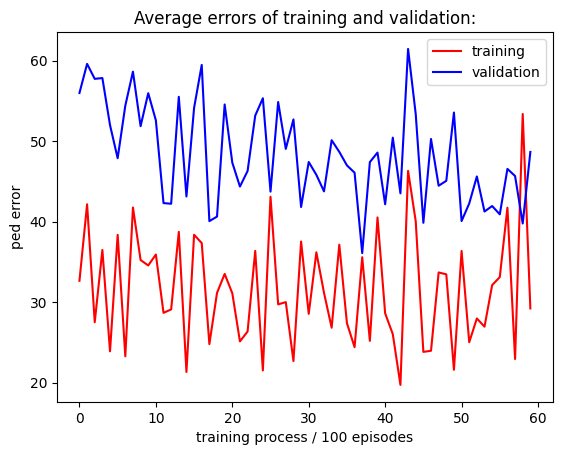

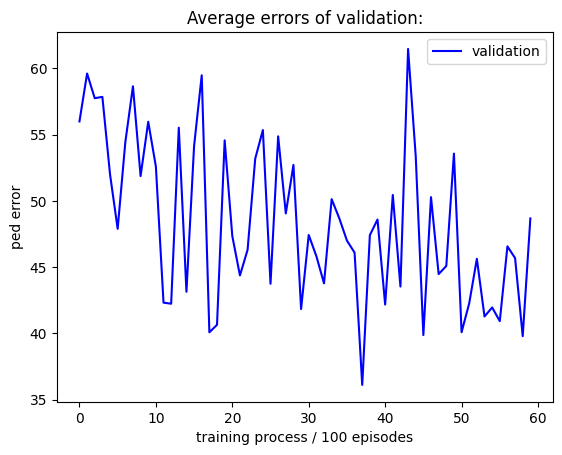

In [5]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, label='ped')#main

======loading train data======
It cost 5.292125940322876s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 0 episode 100: Training error: 1.8466543041154155, Validation error: 1.7504910231591613
Save model with error 1.7504910231591613
==>current best model is 1.7504910231591613 with ratio 0.1
It costs 205.6940095424652s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 0 episode 200: Training error: 1.914479250092146, Validation error: 1.7236672010758183
Save model with error 1.7236672010758183
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 224.2907543182373s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 1 episode 100: Training error: 1.9674996783587018, Validation error: 1.758498357627056
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 206.14514827728271s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 1 episode 200: Training error: 1.8123658964948768, Validation error: 1.748866993865067
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 202.70535969734192s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 2 episode 100: Training error: 1.8804229782744877, Validation error: 1.7563605733411236
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 216.8160183429718s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


round 2 episode 200: Training error: 1.8564472171547732, Validation error: 1.7463816503591727
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 188.97895860671997s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 3 episode 100: Training error: 1.903933168164745, Validation error: 1.7344566901672056
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 221.814843416214s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 3 episode 200: Training error: 1.8350575015191937, Validation error: 1.7437652766037282
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 186.31456995010376s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


round 4 episode 100: Training error: 1.7908406615391672, Validation error: 1.7466237298202867
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 194.2491295337677s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


round 4 episode 200: Training error: 1.9655847045514836, Validation error: 1.729219830487701
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 213.73562908172607s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 5 episode 100: Training error: 1.9116852993652993, Validation error: 1.761319428356969
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 206.40185356140137s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 5 episode 200: Training error: 1.8274949127687983, Validation error: 1.7575084900539795
==>current best model is 1.7236672010758183 with ratio 0.1
It costs 208.88300442695618s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 6 episode 100: Training error: 1.8144848664106386, Validation error: 1.7101663959353164
Save model with error 1.7101663959353164
==>current best model is 1.7101663959353164 with ratio 0.1
It costs 205.7650923728943s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 6 episode 200: Training error: 1.9353336323740198, Validation error: 1.7192489347622313
==>current best model is 1.7101663959353164 with ratio 0.1
It costs 204.1893904209137s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 7 episode 100: Training error: 1.8922484706306657, Validation error: 1.729791763359956
==>current best model is 1.7101663959353164 with ratio 0.1
It costs 224.51125526428223s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 7 episode 200: Training error: 1.8345000154440154, Validation error: 1.6791617069457123
Save model with error 1.6791617069457123
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 188.43677806854248s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 8 episode 100: Training error: 1.7697921495506708, Validation error: 1.6984886039258307
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 205.54918694496155s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 8 episode 200: Training error: 1.9686369481086265, Validation error: 1.7037593559922501
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 209.62860941886902s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 9 episode 100: Training error: 1.8610590162301133, Validation error: 1.7285943843389722
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 187.1913423538208s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 9 episode 200: Training error: 1.8441811482047696, Validation error: 1.7136353614138358
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 222.63710021972656s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 10 episode 100: Training error: 1.9465785289244208, Validation error: 1.7375037349718065
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 196.7132978439331s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 10 episode 200: Training error: 1.8011563168360478, Validation error: 1.7649151666911231
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 217.67510056495667s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 11 episode 100: Training error: 1.8163442131617233, Validation error: 1.7750102289131173
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 206.10134744644165s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 11 episode 200: Training error: 1.9194758357080002, Validation error: 1.7132177058380875
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 202.99190497398376s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 12 episode 100: Training error: 1.9526421740315067, Validation error: 1.7646273279936193
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 195.39980721473694s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 12 episode 200: Training error: 1.782038064418033, Validation error: 1.7326025105721146
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 217.3651397228241s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 13 episode 100: Training error: 1.8586792176196143, Validation error: 1.7143553199861299
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 199.59861207008362s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 13 episode 200: Training error: 1.8423689875187963, Validation error: 1.7332285340515137
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 212.7380530834198s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 14 episode 100: Training error: 1.7512588750699984, Validation error: 1.7004644485845568
==>current best model is 1.6791617069457123 with ratio 0.1
It costs 204.08439922332764s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 14 episode 200: Training error: 1.8828365772585607, Validation error: 1.6767067126296018
Save model with error 1.6767067126296018
==>current best model is 1.6767067126296018 with ratio 0.1
It costs 215.1180284023285s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 15 episode 100: Training error: 1.8125527981825078, Validation error: 1.6963433576079727
==>current best model is 1.6767067126296018 with ratio 0.1
It costs 210.0859739780426s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 15 episode 200: Training error: 1.9045088100755416, Validation error: 1.7257008178031386
==>current best model is 1.6767067126296018 with ratio 0.1
It costs 208.32527875900269s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 16 episode 100: Training error: 1.8250207874279107, Validation error: 1.705230608853814
==>current best model is 1.6767067126296018 with ratio 0.1
It costs 207.76683020591736s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 16 episode 200: Training error: 1.8163832446611565, Validation error: 1.6805070313073665
==>current best model is 1.6767067126296018 with ratio 0.1
It costs 224.06050968170166s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 17 episode 100: Training error: 1.9216207096305302, Validation error: 1.7038347446838256
==>current best model is 1.6767067126296018 with ratio 0.1
It costs 209.12914943695068s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 17 episode 200: Training error: 1.7388147220114, Validation error: 1.676202651260655
Save model with error 1.676202651260655
==>current best model is 1.676202651260655 with ratio 0.1
It costs 205.2991077899933s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 18 episode 100: Training error: 1.7975458876351869, Validation error: 1.6809908294868863
==>current best model is 1.676202651260655 with ratio 0.1
It costs 234.8324408531189s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


round 18 episode 200: Training error: 1.8601247689365996, Validation error: 1.6796026541453797
==>current best model is 1.676202651260655 with ratio 0.1
It costs 173.7165949344635s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 19 episode 100: Training error: 1.8709769498655395, Validation error: 1.6728833587145016
Save model with error 1.6728833587145016
==>current best model is 1.6728833587145016 with ratio 0.1
It costs 219.43084740638733s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 19 episode 200: Training error: 1.7988897261377865, Validation error: 1.7128646436439787
==>current best model is 1.6728833587145016 with ratio 0.1
It costs 199.78350281715393s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


round 20 episode 100: Training error: 1.8765362627201887, Validation error: 1.6948969334750597
==>current best model is 1.6728833587145016 with ratio 0.1
It costs 248.1486110687256s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


round 20 episode 200: Training error: 1.791554918562579, Validation error: 1.7247810531266619
==>current best model is 1.6728833587145016 with ratio 0.1
It costs 182.88649654388428s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 21 episode 100: Training error: 1.9812173641295123, Validation error: 1.6850134181863206
==>current best model is 1.6728833587145016 with ratio 0.1
It costs 206.64241456985474s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


round 21 episode 200: Training error: 1.7239231125990826, Validation error: 1.7121001992529794
==>current best model is 1.6728833587145016 with ratio 0.1
It costs 213.3765366077423s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 22 episode 100: Training error: 1.7796720121597438, Validation error: 1.6681822643605466
Save model with error 1.6681822643605466
==>current best model is 1.6681822643605466 with ratio 0.1
It costs 213.9053008556366s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 22 episode 200: Training error: 1.905502316615225, Validation error: 1.6422185233413111
Save model with error 1.6422185233413111
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 242.25041604042053s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 23 episode 100: Training error: 1.961500081276645, Validation error: 1.6520791970818618
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 203.31456637382507s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 23 episode 200: Training error: 1.7226780949987435, Validation error: 1.6956269111938205
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 226.75863313674927s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


round 24 episode 100: Training error: 1.8804945221043567, Validation error: 1.710331593570091
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 243.355815410614s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 24 episode 200: Training error: 1.7815600870458732, Validation error: 1.6645245584741841
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 180.09561204910278s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


round 25 episode 100: Training error: 1.788636238548257, Validation error: 1.677690379246035
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 217.82417130470276s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 25 episode 200: Training error: 1.8533860587078284, Validation error: 1.6715533411702397
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 206.1505627632141s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 26 episode 100: Training error: 1.9434729275193539, Validation error: 1.6525766750202275
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 237.15541577339172s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 26 episode 200: Training error: 1.7111606278401041, Validation error: 1.7049845988351398
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 186.06397533416748s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 27 episode 100: Training error: 1.7367747156508813, Validation error: 1.6758230093248934
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 210.16454434394836s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 27 episode 200: Training error: 1.889827195624727, Validation error: 1.6566480715023515
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 202.99982380867004s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 28 episode 100: Training error: 1.862960789161513, Validation error: 1.683669100029274
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 201.44380235671997s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 28 episode 200: Training error: 1.7521808013951081, Validation error: 1.6800074020459965
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 202.23638939857483s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 29 episode 100: Training error: 1.7194229507807006, Validation error: 1.6496010606178626
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 212.26550459861755s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 29 episode 200: Training error: 1.8522695677577952, Validation error: 1.6677306073348284
==>current best model is 1.6422185233413111 with ratio 0.1
It costs 192.1085057258606s
Training elapsed time = %s 12513.307569742203


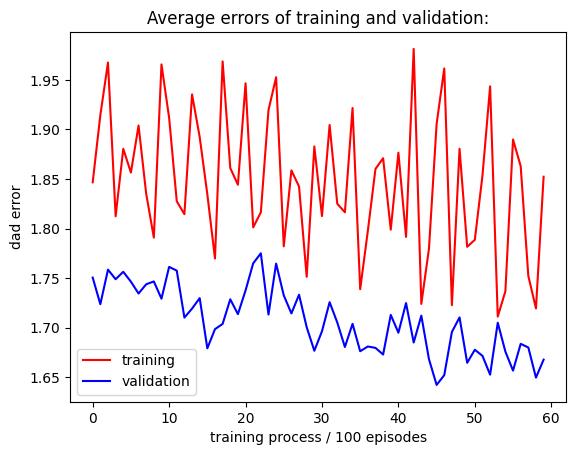

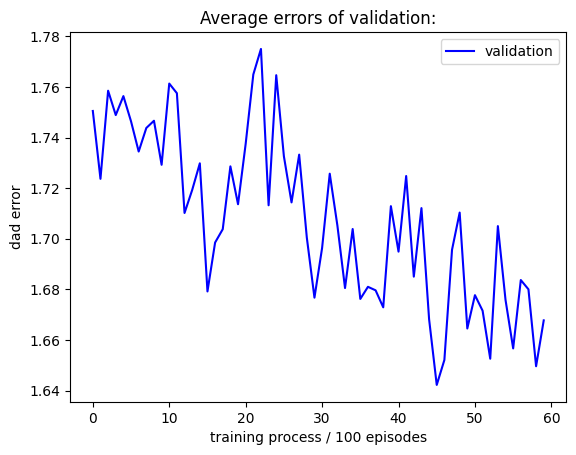

In [6]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, label='dad')#main

======loading train data======
It cost 8.807528972625732s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:19<00:00,  1.99s/it]


round 0 episode 100: Training error: 7.844771761538689, Validation error: 7.5039446072794105
Save model with error 7.5039446072794105
==>current best model is 7.5039446072794105 with ratio 0.1
It costs 360.00785064697266s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


round 0 episode 200: Training error: 6.329419747429929, Validation error: 7.75331396410629
==>current best model is 7.5039446072794105 with ratio 0.1
It costs 345.79334449768066s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.02s/it]


round 1 episode 100: Training error: 7.759458877362203, Validation error: 6.767643949210239
Save model with error 6.767643949210239
==>current best model is 6.767643949210239 with ratio 0.1
It costs 358.83309149742126s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:09<00:00,  1.90s/it]


round 1 episode 200: Training error: 7.19348381639428, Validation error: 7.605908715247189
==>current best model is 6.767643949210239 with ratio 0.1
It costs 346.9370279312134s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


round 2 episode 100: Training error: 7.326707925345337, Validation error: 7.802580456861243
==>current best model is 6.767643949210239 with ratio 0.1
It costs 326.1883816719055s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:28<00:00,  2.08s/it]


round 2 episode 200: Training error: 6.65314053764404, Validation error: 6.558265827504068
Save model with error 6.558265827504068
==>current best model is 6.558265827504068 with ratio 0.1
It costs 365.77732586860657s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.91s/it]


round 3 episode 100: Training error: 6.890418740745292, Validation error: 6.358637614676948
Save model with error 6.358637614676948
==>current best model is 6.358637614676948 with ratio 0.1
It costs 347.3841598033905s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]


round 3 episode 200: Training error: 7.11258623332165, Validation error: 6.325892185757587
Save model with error 6.325892185757587
==>current best model is 6.325892185757587 with ratio 0.1
It costs 348.5002670288086s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.01s/it]


round 4 episode 100: Training error: 7.644057025679559, Validation error: 6.549089480929631
==>current best model is 6.325892185757587 with ratio 0.1
It costs 358.3431875705719s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.77s/it]


round 4 episode 200: Training error: 6.269058481056861, Validation error: 6.543710324681648
==>current best model is 6.325892185757587 with ratio 0.1
It costs 332.44680643081665s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


round 5 episode 100: Training error: 6.830959352668146, Validation error: 6.242692273861831
Save model with error 6.242692273861831
==>current best model is 6.242692273861831 with ratio 0.1
It costs 310.7912061214447s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.32s/it]


round 5 episode 200: Training error: 7.0543590739709945, Validation error: 7.732816938536534
==>current best model is 6.242692273861831 with ratio 0.1
It costs 388.8046956062317s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.80s/it]


round 6 episode 100: Training error: 7.152410249254666, Validation error: 6.2858811816531475
==>current best model is 6.242692273861831 with ratio 0.1
It costs 334.8760221004486s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.01s/it]


round 6 episode 200: Training error: 6.4705239599120095, Validation error: 6.201842742298201
Save model with error 6.201842742298201
==>current best model is 6.201842742298201 with ratio 0.1
It costs 357.91940331459045s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.98s/it]


round 7 episode 100: Training error: 7.064440006563225, Validation error: 7.384369559869724
==>current best model is 6.201842742298201 with ratio 0.1
It costs 352.7202396392822s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.80s/it]


round 7 episode 200: Training error: 6.627673419718906, Validation error: 6.318648187165799
==>current best model is 6.201842742298201 with ratio 0.1
It costs 333.3661584854126s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


round 8 episode 100: Training error: 6.537246280862961, Validation error: 6.237350144029939
==>current best model is 6.201842742298201 with ratio 0.1
It costs 321.5826201438904s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:27<00:00,  2.07s/it]


round 8 episode 200: Training error: 7.107813719548341, Validation error: 7.31029712244065
==>current best model is 6.201842742298201 with ratio 0.1
It costs 360.8856029510498s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.83s/it]


round 9 episode 100: Training error: 6.828738046005871, Validation error: 6.383006898756575
==>current best model is 6.201842742298201 with ratio 0.1
It costs 336.4849419593811s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:16<00:00,  1.96s/it]


round 9 episode 200: Training error: 6.737486911274541, Validation error: 6.211735380468612
==>current best model is 6.201842742298201 with ratio 0.1
It costs 351.7315173149109s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.83s/it]


round 10 episode 100: Training error: 6.660854836955533, Validation error: 6.202128423698303
==>current best model is 6.201842742298201 with ratio 0.1
It costs 337.1748023033142s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:15<00:00,  1.96s/it]


round 10 episode 200: Training error: 7.029285240187395, Validation error: 6.173963789486921
Save model with error 6.173963789486921
==>current best model is 6.173963789486921 with ratio 0.1
It costs 354.3297584056854s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.25s/it]


round 11 episode 100: Training error: 5.993260509265139, Validation error: 6.193836302877828
==>current best model is 6.173963789486921 with ratio 0.1
It costs 380.2141468524933s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


round 11 episode 200: Training error: 7.523064549751097, Validation error: 6.169586216736129
Save model with error 6.169586216736129
==>current best model is 6.169586216736129 with ratio 0.1
It costs 310.6952497959137s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]


round 12 episode 100: Training error: 7.2230304495993405, Validation error: 6.285141268627489
==>current best model is 6.169586216736129 with ratio 0.1
It costs 344.2893533706665s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:09<00:00,  1.89s/it]


round 12 episode 200: Training error: 6.350674433240827, Validation error: 6.192900581541091
==>current best model is 6.169586216736129 with ratio 0.1
It costs 344.29363536834717s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.75s/it]


round 13 episode 100: Training error: 6.64982471622817, Validation error: 6.12439007436741
Save model with error 6.12439007436741
==>current best model is 6.12439007436741 with ratio 0.1
It costs 330.49686551094055s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.05s/it]


round 13 episode 200: Training error: 6.9084215288394235, Validation error: 6.291580482806229
==>current best model is 6.12439007436741 with ratio 0.1
It costs 360.094562292099s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:19<00:00,  1.99s/it]


round 14 episode 100: Training error: 7.075640450451525, Validation error: 6.411562215203372
==>current best model is 6.12439007436741 with ratio 0.1
It costs 354.3349258899689s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.83s/it]


round 14 episode 200: Training error: 6.587809197875224, Validation error: 6.327315071896195
==>current best model is 6.12439007436741 with ratio 0.1
It costs 339.38009309768677s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.05s/it]


round 15 episode 100: Training error: 5.750328500456699, Validation error: 6.229204679022529
==>current best model is 6.12439007436741 with ratio 0.1
It costs 358.4449019432068s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


round 15 episode 200: Training error: 7.725658315844129, Validation error: 6.473847474444136
==>current best model is 6.12439007436741 with ratio 0.1
It costs 328.1092896461487s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:41<00:00,  2.22s/it]


round 16 episode 100: Training error: 6.717681700681852, Validation error: 6.314810131320383
==>current best model is 6.12439007436741 with ratio 0.1
It costs 376.9013247489929s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


round 16 episode 200: Training error: 6.642034550046072, Validation error: 6.20940130623939
==>current best model is 6.12439007436741 with ratio 0.1
It costs 316.50173234939575s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]


round 17 episode 100: Training error: 6.980155134370482, Validation error: 6.283541968968217
==>current best model is 6.12439007436741 with ratio 0.1
It costs 336.0018277168274s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/it]


round 17 episode 200: Training error: 6.6176326747043355, Validation error: 6.264719738812969
==>current best model is 6.12439007436741 with ratio 0.1
It costs 357.7412829399109s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:45<00:00,  2.26s/it]


round 18 episode 100: Training error: 5.932610692102008, Validation error: 6.318179289175144
==>current best model is 6.12439007436741 with ratio 0.1
It costs 379.2320394515991s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 18 episode 200: Training error: 7.638915955476003, Validation error: 6.318290522490372
==>current best model is 6.12439007436741 with ratio 0.1
It costs 313.95653319358826s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:45<00:00,  2.26s/it]


round 19 episode 100: Training error: 7.12897339416958, Validation error: 6.206494236431203
==>current best model is 6.12439007436741 with ratio 0.1
It costs 378.7812821865082s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 19 episode 200: Training error: 6.532812691738014, Validation error: 6.321083036928173
==>current best model is 6.12439007436741 with ratio 0.1
It costs 314.14812707901s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:37<00:00,  2.18s/it]


round 20 episode 100: Training error: 7.5689988794131144, Validation error: 6.324540421693813
==>current best model is 6.12439007436741 with ratio 0.1
It costs 372.41730785369873s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


round 20 episode 200: Training error: 6.094649865590144, Validation error: 6.330636460414557
==>current best model is 6.12439007436741 with ratio 0.1
It costs 324.9778082370758s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it]


round 21 episode 100: Training error: 6.456310835523235, Validation error: 6.336830594603515
==>current best model is 6.12439007436741 with ratio 0.1
It costs 329.9972538948059s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.15s/it]


round 21 episode 200: Training error: 7.250383767368341, Validation error: 6.368564153309357
==>current best model is 6.12439007436741 with ratio 0.1
It costs 368.03223419189453s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


round 22 episode 100: Training error: 6.9243831182776185, Validation error: 6.301246769684806
==>current best model is 6.12439007436741 with ratio 0.1
It costs 329.0224099159241s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.09s/it]


round 22 episode 200: Training error: 6.6276104453637075, Validation error: 6.279942810570157
==>current best model is 6.12439007436741 with ratio 0.1
It costs 362.42760133743286s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.26s/it]


round 23 episode 100: Training error: 7.052268921141096, Validation error: 6.311314251619837
==>current best model is 6.12439007436741 with ratio 0.1
It costs 379.43449354171753s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


round 23 episode 200: Training error: 6.5817212742792695, Validation error: 6.256039876571894
==>current best model is 6.12439007436741 with ratio 0.1
It costs 318.13617420196533s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.02s/it]


round 24 episode 100: Training error: 6.36742174083296, Validation error: 6.352721846057301
==>current best model is 6.12439007436741 with ratio 0.1
It costs 355.5743980407715s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


round 24 episode 200: Training error: 7.289746274155755, Validation error: 6.257368612796473
==>current best model is 6.12439007436741 with ratio 0.1
It costs 339.08278584480286s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.09s/it]


round 25 episode 100: Training error: 6.822270887566135, Validation error: 6.306262237590323
==>current best model is 6.12439007436741 with ratio 0.1
It costs 361.93380331993103s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]


round 25 episode 200: Training error: 6.917936346604814, Validation error: 6.329055203638146
==>current best model is 6.12439007436741 with ratio 0.1
It costs 333.192711353302s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


round 26 episode 100: Training error: 6.910434437962876, Validation error: 6.309204537989895
==>current best model is 6.12439007436741 with ratio 0.1
It costs 328.61531043052673s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:38<00:00,  2.18s/it]


round 26 episode 200: Training error: 6.801461329623617, Validation error: 6.322402642768543
==>current best model is 6.12439007436741 with ratio 0.1
It costs 371.9474937915802s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


round 27 episode 100: Training error: 7.170254933195761, Validation error: 6.245917013942538
==>current best model is 6.12439007436741 with ratio 0.1
It costs 323.8976969718933s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.20s/it]


round 27 episode 200: Training error: 6.501221696830412, Validation error: 6.302424798463567
==>current best model is 6.12439007436741 with ratio 0.1
It costs 372.71712493896484s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.01s/it]


round 28 episode 100: Training error: 7.004237560527499, Validation error: 6.3017784950763485
==>current best model is 6.12439007436741 with ratio 0.1
It costs 355.3222076892853s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.86s/it]


round 28 episode 200: Training error: 6.708389922442566, Validation error: 6.356989813809587
==>current best model is 6.12439007436741 with ratio 0.1
It costs 341.538437128067s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.23s/it]


round 29 episode 100: Training error: 6.5067466011147665, Validation error: 6.279562351859873
==>current best model is 6.12439007436741 with ratio 0.1
It costs 376.2085566520691s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


round 29 episode 200: Training error: 7.188130445728961, Validation error: 6.347483689157006
==>current best model is 6.12439007436741 with ratio 0.1
It costs 318.7040824890137s
Training elapsed time = %s 20817.68348789215


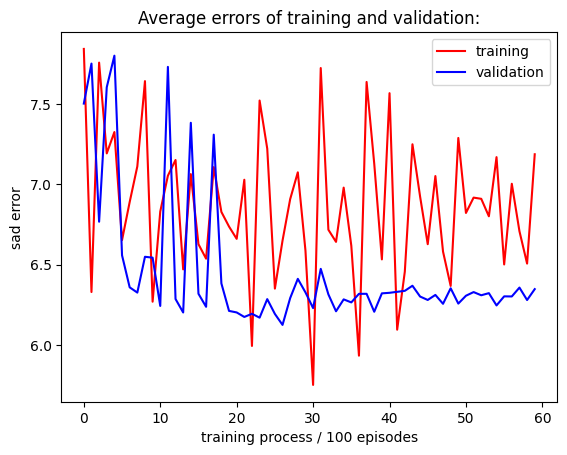

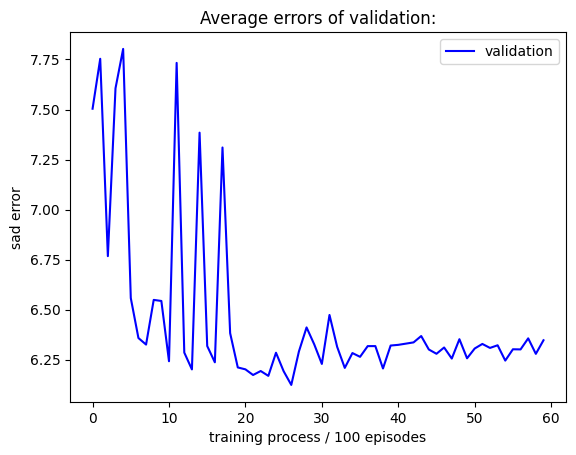

In [7]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sad')#main

======loading train data======
It cost 12.663264989852905s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 0 episode 100: Training error: 20.248454886241323, Validation error: 29.821957702225134
Save model with error 29.821957702225134
==>current best model is 29.821957702225134 with ratio 0.2
It costs 250.2459990978241s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 0 episode 200: Training error: 29.521253267045058, Validation error: 33.08788531822716
==>current best model is 29.821957702225134 with ratio 0.2
It costs 252.76288652420044s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


round 1 episode 100: Training error: 22.53709205291276, Validation error: 31.518235708730767
==>current best model is 29.821957702225134 with ratio 0.2
It costs 235.60343265533447s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


round 1 episode 200: Training error: 26.838708753860455, Validation error: 33.21985439428608
==>current best model is 29.821957702225134 with ratio 0.2
It costs 265.4517035484314s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


round 2 episode 100: Training error: 25.77056143526041, Validation error: 26.76784742044991
Save model with error 26.76784742044991
==>current best model is 26.76784742044991 with ratio 0.2
It costs 251.87113404273987s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 2 episode 200: Training error: 26.227186485768662, Validation error: 28.407091734987237
==>current best model is 26.76784742044991 with ratio 0.2
It costs 256.2769932746887s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


round 3 episode 100: Training error: 27.863263564820333, Validation error: 31.03560003920756
==>current best model is 26.76784742044991 with ratio 0.2
It costs 283.9857783317566s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 3 episode 200: Training error: 24.133157745531012, Validation error: 31.493885648980857
==>current best model is 26.76784742044991 with ratio 0.2
It costs 217.1874098777771s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 4 episode 100: Training error: 17.35154912860894, Validation error: 30.714959801913682
==>current best model is 26.76784742044991 with ratio 0.2
It costs 239.00005388259888s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


round 4 episode 200: Training error: 32.1992307562724, Validation error: 30.330707293872813
==>current best model is 26.76784742044991 with ratio 0.2
It costs 264.6254827976227s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 5 episode 100: Training error: 27.73970018936411, Validation error: 29.73195777891344
==>current best model is 26.76784742044991 with ratio 0.2
It costs 250.1958303451538s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 5 episode 200: Training error: 22.533222281821125, Validation error: 28.678490888295688
==>current best model is 26.76784742044991 with ratio 0.2
It costs 250.07676124572754s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


round 6 episode 100: Training error: 29.649023399619473, Validation error: 31.128704254816473
==>current best model is 26.76784742044991 with ratio 0.2
It costs 240.1704442501068s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


round 6 episode 200: Training error: 20.915022552281034, Validation error: 29.814126536793218
==>current best model is 26.76784742044991 with ratio 0.2
It costs 260.18257546424866s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 7 episode 100: Training error: 18.672504089922004, Validation error: 29.473259836851014
==>current best model is 26.76784742044991 with ratio 0.2
It costs 234.7856810092926s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


round 7 episode 200: Training error: 26.42006924438634, Validation error: 27.75757278534673
==>current best model is 26.76784742044991 with ratio 0.2
It costs 267.8284332752228s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 8 episode 100: Training error: 21.981798870173193, Validation error: 27.216734946996176
==>current best model is 26.76784742044991 with ratio 0.2
It costs 243.5765883922577s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


round 8 episode 200: Training error: 26.959013199690606, Validation error: 28.291759966960715
==>current best model is 26.76784742044991 with ratio 0.2
It costs 258.78454422950745s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


round 9 episode 100: Training error: 18.440207644734738, Validation error: 27.3601527163888
==>current best model is 26.76784742044991 with ratio 0.2
It costs 287.75101685523987s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


round 9 episode 200: Training error: 26.43112292079386, Validation error: 27.60978261317182
==>current best model is 26.76784742044991 with ratio 0.2
It costs 215.60609889030457s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


round 10 episode 100: Training error: 23.473402475733984, Validation error: 26.281460835539452
Save model with error 26.281460835539452
==>current best model is 26.281460835539452 with ratio 0.2
It costs 273.2132239341736s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 10 episode 200: Training error: 22.524679159845167, Validation error: 27.24697232320419
==>current best model is 26.281460835539452 with ratio 0.2
It costs 224.3782479763031s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 11 episode 100: Training error: 27.029000186920108, Validation error: 28.29697273735683
==>current best model is 26.281460835539452 with ratio 0.2
It costs 235.72432398796082s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 11 episode 200: Training error: 19.56763746510001, Validation error: 28.666771671592674
==>current best model is 26.281460835539452 with ratio 0.2
It costs 262.5166358947754s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 12 episode 100: Training error: 16.529258842078374, Validation error: 26.44860697996613
==>current best model is 26.281460835539452 with ratio 0.2
It costs 278.4387118816376s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 12 episode 200: Training error: 29.366286013951967, Validation error: 28.76493097239021
==>current best model is 26.281460835539452 with ratio 0.2
It costs 220.37218356132507s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 13 episode 100: Training error: 27.993233608051497, Validation error: 27.077006943297384
==>current best model is 26.281460835539452 with ratio 0.2
It costs 231.03202748298645s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


round 13 episode 200: Training error: 15.575266711839722, Validation error: 25.977245062497808
Save model with error 25.977245062497808
==>current best model is 25.977245062497808 with ratio 0.2
It costs 265.0077483654022s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 14 episode 100: Training error: 19.305119409650292, Validation error: 26.436136849194817
==>current best model is 25.977245062497808 with ratio 0.2
It costs 255.9040207862854s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 14 episode 200: Training error: 27.724865922463845, Validation error: 28.439914741452338
==>current best model is 25.977245062497808 with ratio 0.2
It costs 243.2179238796234s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


round 15 episode 100: Training error: 18.801471589770742, Validation error: 29.825284101924307
==>current best model is 25.977245062497808 with ratio 0.2
It costs 251.193026304245s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 15 episode 200: Training error: 28.69635483742944, Validation error: 29.13839103165918
==>current best model is 25.977245062497808 with ratio 0.2
It costs 249.07261633872986s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 16 episode 100: Training error: 17.945481359896256, Validation error: 28.357680004426296
==>current best model is 25.977245062497808 with ratio 0.2
It costs 231.39611959457397s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


round 16 episode 200: Training error: 28.152513937785315, Validation error: 29.58695585724966
==>current best model is 25.977245062497808 with ratio 0.2
It costs 271.140109539032s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 17 episode 100: Training error: 30.861302479531506, Validation error: 29.119984233614705
==>current best model is 25.977245062497808 with ratio 0.2
It costs 254.14244318008423s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 17 episode 200: Training error: 15.717827392481567, Validation error: 29.04274538737889
==>current best model is 25.977245062497808 with ratio 0.2
It costs 245.77735710144043s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 18 episode 100: Training error: 28.02023686660138, Validation error: 27.197896542357647
==>current best model is 25.977245062497808 with ratio 0.2
It costs 221.7140290737152s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


round 18 episode 200: Training error: 19.453849589620248, Validation error: 29.312615989686524
==>current best model is 25.977245062497808 with ratio 0.2
It costs 275.7495062351227s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 19 episode 100: Training error: 16.910894208401853, Validation error: 26.837599148238077
==>current best model is 25.977245062497808 with ratio 0.2
It costs 250.36024641990662s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 19 episode 200: Training error: 28.617216029532266, Validation error: 25.731742772284015
Save model with error 25.731742772284015
==>current best model is 25.731742772284015 with ratio 0.2
It costs 250.96228122711182s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 20 episode 100: Training error: 22.335419986976152, Validation error: 26.008929748285325
==>current best model is 25.731742772284015 with ratio 0.2
It costs 246.9983103275299s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 20 episode 200: Training error: 24.48752540955768, Validation error: 28.612686576453246
==>current best model is 25.731742772284015 with ratio 0.2
It costs 255.08902978897095s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 21 episode 100: Training error: 24.046651396269766, Validation error: 27.080280166027062
==>current best model is 25.731742772284015 with ratio 0.2
It costs 221.64839482307434s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


round 21 episode 200: Training error: 24.17829978010656, Validation error: 29.721667846629746
==>current best model is 25.731742772284015 with ratio 0.2
It costs 279.6596260070801s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 22 episode 100: Training error: 19.315289989980286, Validation error: 26.675676659538404
==>current best model is 25.731742772284015 with ratio 0.2
It costs 246.63663005828857s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 22 episode 200: Training error: 27.701797907883243, Validation error: 28.681324206647123
==>current best model is 25.731742772284015 with ratio 0.2
It costs 256.39109802246094s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 23 episode 100: Training error: 22.62402047358695, Validation error: 27.85200714063512
==>current best model is 25.731742772284015 with ratio 0.2
It costs 248.3782606124878s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 23 episode 200: Training error: 23.946533402550685, Validation error: 29.37667812523603
==>current best model is 25.731742772284015 with ratio 0.2
It costs 246.38197302818298s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 24 episode 100: Training error: 22.562669886173335, Validation error: 28.116694184239385
==>current best model is 25.731742772284015 with ratio 0.2
It costs 221.73384356498718s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 24 episode 200: Training error: 21.694220505506333, Validation error: 26.286109636014892
==>current best model is 25.731742772284015 with ratio 0.2
It costs 202.54426217079163s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


round 25 episode 100: Training error: 18.00256599237792, Validation error: 29.148935465964243
==>current best model is 25.731742772284015 with ratio 0.2
It costs 194.9664568901062s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 25 episode 200: Training error: 26.89983704005874, Validation error: 24.8409906915497
Save model with error 24.8409906915497
==>current best model is 24.8409906915497 with ratio 0.2
It costs 210.84552550315857s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 26 episode 100: Training error: 22.08367287296771, Validation error: 27.532576380096536
==>current best model is 24.8409906915497 with ratio 0.2
It costs 208.76893424987793s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


round 26 episode 200: Training error: 23.2013105008548, Validation error: 28.59201555099666
==>current best model is 24.8409906915497 with ratio 0.2
It costs 195.89750790596008s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 27 episode 100: Training error: 24.56248146728603, Validation error: 28.699010596873716
==>current best model is 24.8409906915497 with ratio 0.2
It costs 199.06225061416626s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 27 episode 200: Training error: 18.628414059565344, Validation error: 28.143899834059628
==>current best model is 24.8409906915497 with ratio 0.2
It costs 203.43759322166443s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 28 episode 100: Training error: 17.64881957482849, Validation error: 30.10357594911842
==>current best model is 24.8409906915497 with ratio 0.2
It costs 201.94885969161987s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 28 episode 200: Training error: 26.923438238950904, Validation error: 27.844800080731073
==>current best model is 24.8409906915497 with ratio 0.2
It costs 188.3916575908661s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 29 episode 100: Training error: 28.398243641738233, Validation error: 28.979735858199813
==>current best model is 24.8409906915497 with ratio 0.2
It costs 179.7522919178009s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 29 episode 200: Training error: 15.592495333816673, Validation error: 28.67339163837268
==>current best model is 24.8409906915497 with ratio 0.2
It costs 198.14598107337952s
Training elapsed time = %s 14423.969716072083


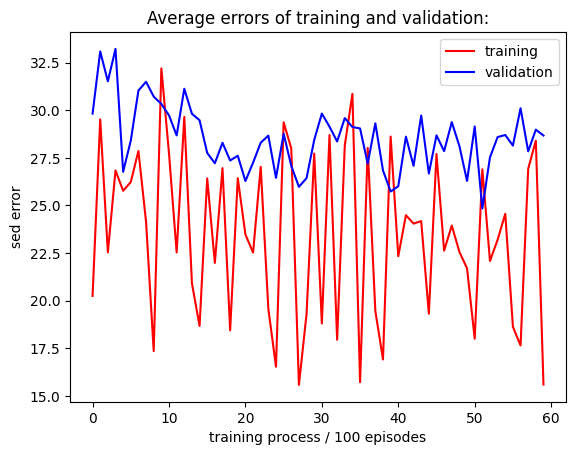

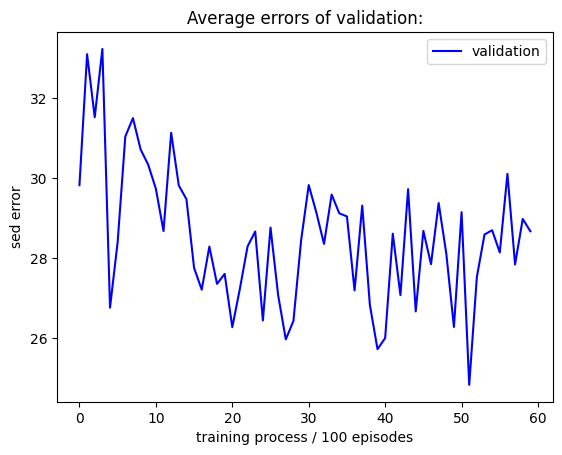

In [8]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.2, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 7.07469916343689s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 0 episode 100: Training error: 10.683470368920805, Validation error: 14.395749735110792
Save model with error 14.395749735110792
==>current best model is 14.395749735110792 with ratio 0.3
It costs 172.3578395843506s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


round 0 episode 200: Training error: 12.376365421265541, Validation error: 14.556240914521384
==>current best model is 14.395749735110792 with ratio 0.3
It costs 173.01038336753845s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 1 episode 100: Training error: 9.354704433610772, Validation error: 14.102014978573191
Save model with error 14.102014978573191
==>current best model is 14.102014978573191 with ratio 0.3
It costs 182.5638587474823s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.14it/s]


round 1 episode 200: Training error: 13.079256448589586, Validation error: 15.580334488732872
==>current best model is 14.102014978573191 with ratio 0.3
It costs 169.05578684806824s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 2 episode 100: Training error: 13.355631882428659, Validation error: 14.43284702024338
==>current best model is 14.102014978573191 with ratio 0.3
It costs 160.0993196964264s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 2 episode 200: Training error: 10.067550527563004, Validation error: 14.472483393556487
==>current best model is 14.102014978573191 with ratio 0.3
It costs 177.1716480255127s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 3 episode 100: Training error: 12.073489714450734, Validation error: 13.523629325569342
Save model with error 13.523629325569342
==>current best model is 13.523629325569342 with ratio 0.3
It costs 186.48793244361877s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


round 3 episode 200: Training error: 10.87084877470915, Validation error: 14.552441523022104
==>current best model is 13.523629325569342 with ratio 0.3
It costs 167.04275727272034s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


round 4 episode 100: Training error: 13.414442223644947, Validation error: 13.895267337369747
==>current best model is 13.523629325569342 with ratio 0.3
It costs 153.33564710617065s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 4 episode 200: Training error: 10.245041923145807, Validation error: 14.81837032073577
==>current best model is 13.523629325569342 with ratio 0.3
It costs 178.14656615257263s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


round 5 episode 100: Training error: 10.851280226450845, Validation error: 14.224878554952273
==>current best model is 13.523629325569342 with ratio 0.3
It costs 161.72535109519958s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


round 5 episode 200: Training error: 12.379816009105333, Validation error: 15.66163954861714
==>current best model is 13.523629325569342 with ratio 0.3
It costs 172.25610852241516s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 6 episode 100: Training error: 14.752053065826233, Validation error: 14.571152064876413
==>current best model is 13.523629325569342 with ratio 0.3
It costs 172.43062734603882s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


round 6 episode 200: Training error: 9.043034598612746, Validation error: 14.972626916867044
==>current best model is 13.523629325569342 with ratio 0.3
It costs 161.55028009414673s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 7 episode 100: Training error: 9.830000033020452, Validation error: 14.381926662739223
==>current best model is 13.523629325569342 with ratio 0.3
It costs 174.97714161872864s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 7 episode 200: Training error: 12.960904195038278, Validation error: 14.901699441763173
==>current best model is 13.523629325569342 with ratio 0.3
It costs 165.04967951774597s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 8 episode 100: Training error: 11.219062345445206, Validation error: 15.02052295864181
==>current best model is 13.523629325569342 with ratio 0.3
It costs 174.55383372306824s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


round 8 episode 200: Training error: 11.14335515534682, Validation error: 14.734330256962211
==>current best model is 13.523629325569342 with ratio 0.3
It costs 175.77895665168762s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 9 episode 100: Training error: 11.727848204536592, Validation error: 15.010615851410265
==>current best model is 13.523629325569342 with ratio 0.3
It costs 178.80626273155212s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 9 episode 200: Training error: 11.005499099153399, Validation error: 14.676749847396657
==>current best model is 13.523629325569342 with ratio 0.3
It costs 157.9142906665802s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 10 episode 100: Training error: 11.48428446585125, Validation error: 14.197416224342867
==>current best model is 13.523629325569342 with ratio 0.3
It costs 173.07428979873657s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 10 episode 200: Training error: 11.52734115710428, Validation error: 14.500887542320612
==>current best model is 13.523629325569342 with ratio 0.3
It costs 161.23106336593628s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 11 episode 100: Training error: 10.440800490133403, Validation error: 14.153397141919164
==>current best model is 13.523629325569342 with ratio 0.3
It costs 175.32726907730103s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 11 episode 200: Training error: 13.283747584901427, Validation error: 15.307194623959907
==>current best model is 13.523629325569342 with ratio 0.3
It costs 164.46786212921143s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


round 12 episode 100: Training error: 13.586123273232806, Validation error: 14.872357301286966
==>current best model is 13.523629325569342 with ratio 0.3
It costs 155.4950156211853s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 12 episode 200: Training error: 10.488280161238993, Validation error: 14.710487282016356
==>current best model is 13.523629325569342 with ratio 0.3
It costs 178.16500306129456s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


round 13 episode 100: Training error: 13.892790302449821, Validation error: 14.244630604030405
==>current best model is 13.523629325569342 with ratio 0.3
It costs 165.33866047859192s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 13 episode 200: Training error: 10.070890293780847, Validation error: 14.730998224818226
==>current best model is 13.523629325569342 with ratio 0.3
It costs 172.20182490348816s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 14 episode 100: Training error: 13.514830433049799, Validation error: 14.476619879793299
==>current best model is 13.523629325569342 with ratio 0.3
It costs 159.40295577049255s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.06it/s]


round 14 episode 200: Training error: 9.926666265482858, Validation error: 13.69101778488112
==>current best model is 13.523629325569342 with ratio 0.3
It costs 173.98989009857178s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 15 episode 100: Training error: 9.34211861406327, Validation error: 14.204505684788296
==>current best model is 13.523629325569342 with ratio 0.3
It costs 168.63072729110718s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


round 15 episode 200: Training error: 14.316155248164582, Validation error: 13.982971864979001
==>current best model is 13.523629325569342 with ratio 0.3
It costs 165.8322651386261s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 16 episode 100: Training error: 11.320550265578913, Validation error: 14.203455380544105
==>current best model is 13.523629325569342 with ratio 0.3
It costs 166.7421360015869s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


round 16 episode 200: Training error: 11.591368129939564, Validation error: 14.053054974507065
==>current best model is 13.523629325569342 with ratio 0.3
It costs 167.58171153068542s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


round 17 episode 100: Training error: 13.969360541125948, Validation error: 14.200464048274208
==>current best model is 13.523629325569342 with ratio 0.3
It costs 160.61963891983032s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 17 episode 200: Training error: 9.114983362796952, Validation error: 14.478881782767521
==>current best model is 13.523629325569342 with ratio 0.3
It costs 172.36919522285461s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 18 episode 100: Training error: 15.838774781257078, Validation error: 13.736346433873821
==>current best model is 13.523629325569342 with ratio 0.3
It costs 178.9673466682434s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


round 18 episode 200: Training error: 7.8338819248089075, Validation error: 13.604520290846633
==>current best model is 13.523629325569342 with ratio 0.3
It costs 185.88723158836365s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 19 episode 100: Training error: 10.886882748048842, Validation error: 13.435706866558542
Save model with error 13.435706866558542
==>current best model is 13.435706866558542 with ratio 0.3
It costs 169.3402862548828s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 19 episode 200: Training error: 12.190617647212678, Validation error: 13.901235120293741
==>current best model is 13.435706866558542 with ratio 0.3
It costs 179.96727395057678s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 20 episode 100: Training error: 14.201458599767022, Validation error: 13.660636609600228
==>current best model is 13.435706866558542 with ratio 0.3
It costs 158.96889400482178s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 20 episode 200: Training error: 8.474742242594125, Validation error: 14.912216427519567
==>current best model is 13.435706866558542 with ratio 0.3
It costs 180.04486465454102s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


round 21 episode 100: Training error: 9.13596780148232, Validation error: 14.294071202075061
==>current best model is 13.435706866558542 with ratio 0.3
It costs 171.94916939735413s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.18it/s]


round 21 episode 200: Training error: 13.082951438562027, Validation error: 13.59685899670838
==>current best model is 13.435706866558542 with ratio 0.3
It costs 167.48440170288086s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 22 episode 100: Training error: 10.78096984927889, Validation error: 15.013688931028383
==>current best model is 13.435706866558542 with ratio 0.3
It costs 175.57321095466614s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


round 22 episode 200: Training error: 11.339448325319452, Validation error: 13.85806896219886
==>current best model is 13.435706866558542 with ratio 0.3
It costs 165.83370065689087s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 23 episode 100: Training error: 9.521296787181193, Validation error: 13.517884869121366
==>current best model is 13.435706866558542 with ratio 0.3
It costs 178.29669833183289s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 23 episode 200: Training error: 13.160689623139046, Validation error: 14.769688919214813
==>current best model is 13.435706866558542 with ratio 0.3
It costs 158.85360503196716s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 24 episode 100: Training error: 9.107067681907138, Validation error: 13.562747782043756
==>current best model is 13.435706866558542 with ratio 0.3
It costs 175.73656916618347s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 24 episode 200: Training error: 14.377146066650788, Validation error: 14.13954322782216
==>current best model is 13.435706866558542 with ratio 0.3
It costs 181.77419018745422s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 25 episode 100: Training error: 10.146437958843508, Validation error: 13.45106181738736
==>current best model is 13.435706866558542 with ratio 0.3
It costs 184.47447848320007s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 25 episode 200: Training error: 13.101734226215017, Validation error: 13.382517849119244
Save model with error 13.382517849119244
==>current best model is 13.382517849119244 with ratio 0.3
It costs 187.012788772583s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


round 26 episode 100: Training error: 14.073425128504581, Validation error: 14.578920496699784
==>current best model is 13.382517849119244 with ratio 0.3
It costs 170.04466247558594s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 26 episode 200: Training error: 8.80533918193268, Validation error: 14.704534567906867
==>current best model is 13.382517849119244 with ratio 0.3
It costs 169.28161334991455s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 27 episode 100: Training error: 13.203960817935261, Validation error: 13.676847521328602
==>current best model is 13.382517849119244 with ratio 0.3
It costs 172.63486742973328s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


round 27 episode 200: Training error: 9.156757325589604, Validation error: 13.518249685505399
==>current best model is 13.382517849119244 with ratio 0.3
It costs 161.90775537490845s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 28 episode 100: Training error: 13.875978173092058, Validation error: 14.963724627979708
==>current best model is 13.382517849119244 with ratio 0.3
It costs 175.5297372341156s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 28 episode 200: Training error: 9.693819312141564, Validation error: 13.682767405428581
==>current best model is 13.382517849119244 with ratio 0.3
It costs 162.60607385635376s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


round 29 episode 100: Training error: 12.101303089451397, Validation error: 14.93902293509089
==>current best model is 13.382517849119244 with ratio 0.3
It costs 170.0287697315216s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


round 29 episode 200: Training error: 11.081302482735946, Validation error: 13.870880844455305
==>current best model is 13.382517849119244 with ratio 0.3
It costs 164.99399089813232s
Training elapsed time = %s 10241.982063293457


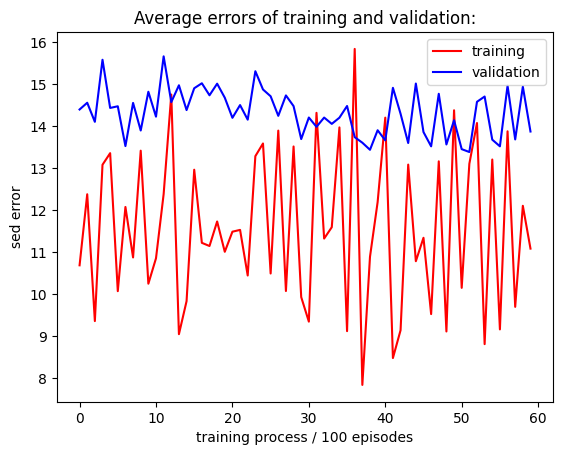

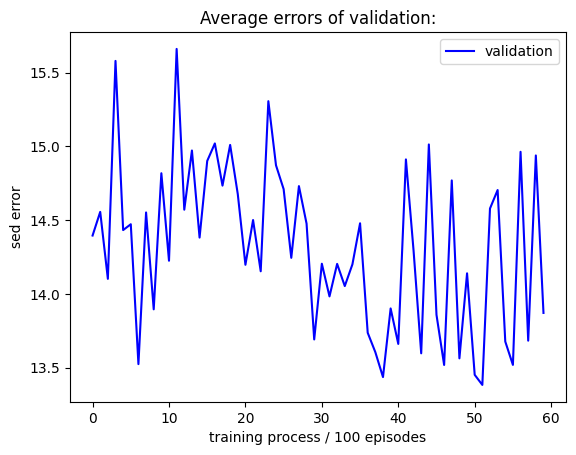

In [9]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.3, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 10.795839309692383s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


round 0 episode 100: Training error: 6.394972666162837, Validation error: 8.866042289834862
Save model with error 8.866042289834862
==>current best model is 8.866042289834862 with ratio 0.4
It costs 141.1885380744934s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 0 episode 200: Training error: 6.892464609156706, Validation error: 8.733308225734579
Save model with error 8.733308225734579
==>current best model is 8.733308225734579 with ratio 0.4
It costs 156.24776101112366s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.18it/s]


round 1 episode 100: Training error: 5.15836982129631, Validation error: 8.566312582179716
Save model with error 8.566312582179716
==>current best model is 8.566312582179716 with ratio 0.4
It costs 157.1494264602661s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


round 1 episode 200: Training error: 7.869406056609666, Validation error: 8.634679256045624
==>current best model is 8.566312582179716 with ratio 0.4
It costs 137.05907464027405s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


round 2 episode 100: Training error: 6.0749525015317145, Validation error: 9.108864625355267
==>current best model is 8.566312582179716 with ratio 0.4
It costs 149.9121687412262s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


round 2 episode 200: Training error: 7.128661569420541, Validation error: 8.984216286320148
==>current best model is 8.566312582179716 with ratio 0.4
It costs 139.99267387390137s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 3 episode 100: Training error: 7.018653517788346, Validation error: 8.83749770763068
==>current best model is 8.566312582179716 with ratio 0.4
It costs 148.76031517982483s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


round 3 episode 200: Training error: 6.235988510383254, Validation error: 8.807032453004423
==>current best model is 8.566312582179716 with ratio 0.4
It costs 142.96533751487732s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


round 4 episode 100: Training error: 6.527997479212011, Validation error: 9.32001484370244
==>current best model is 8.566312582179716 with ratio 0.4
It costs 135.35667037963867s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 4 episode 200: Training error: 6.879359924056444, Validation error: 8.933170154833194
==>current best model is 8.566312582179716 with ratio 0.4
It costs 155.27821326255798s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


round 5 episode 100: Training error: 7.909825337601657, Validation error: 9.069971067878924
==>current best model is 8.566312582179716 with ratio 0.4
It costs 139.2418999671936s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 5 episode 200: Training error: 5.785887392914372, Validation error: 9.217449234929681
==>current best model is 8.566312582179716 with ratio 0.4
It costs 153.73266625404358s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 6 episode 100: Training error: 6.829478462503269, Validation error: 9.30330014292158
==>current best model is 8.566312582179716 with ratio 0.4
It costs 150.7014124393463s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


round 6 episode 200: Training error: 6.629825069548384, Validation error: 8.564573990758879
Save model with error 8.564573990758879
==>current best model is 8.564573990758879 with ratio 0.4
It costs 139.6537435054779s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


round 7 episode 100: Training error: 6.528664433897144, Validation error: 9.237574663562205
==>current best model is 8.564573990758879 with ratio 0.4
It costs 145.9433193206787s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


round 7 episode 200: Training error: 6.675091118680617, Validation error: 8.89802635773982
==>current best model is 8.564573990758879 with ratio 0.4
It costs 147.32752418518066s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


round 8 episode 100: Training error: 6.476617123082718, Validation error: 8.716976847171745
==>current best model is 8.564573990758879 with ratio 0.4
It costs 141.93241381645203s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 8 episode 200: Training error: 6.427058684717656, Validation error: 8.661089072205936
==>current best model is 8.564573990758879 with ratio 0.4
It costs 151.9689497947693s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


round 9 episode 100: Training error: 7.3417689156482675, Validation error: 8.349807980110512
Save model with error 8.349807980110512
==>current best model is 8.349807980110512 with ratio 0.4
It costs 139.18123078346252s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 9 episode 200: Training error: 5.486247543728594, Validation error: 8.460895453696526
==>current best model is 8.349807980110512 with ratio 0.4
It costs 156.61222577095032s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 10 episode 100: Training error: 7.138454034251558, Validation error: 8.390637622868859
==>current best model is 8.349807980110512 with ratio 0.4
It costs 154.6460747718811s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


round 10 episode 200: Training error: 5.795615752358697, Validation error: 8.420124025819081
==>current best model is 8.349807980110512 with ratio 0.4
It costs 139.2952105998993s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 11 episode 100: Training error: 6.549943635363564, Validation error: 8.48740125035179
==>current best model is 8.349807980110512 with ratio 0.4
It costs 154.96693992614746s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


round 11 episode 200: Training error: 6.406893563820973, Validation error: 8.583048816043203
==>current best model is 8.349807980110512 with ratio 0.4
It costs 134.67235708236694s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


round 12 episode 100: Training error: 5.98827412148743, Validation error: 8.557643281739079
==>current best model is 8.349807980110512 with ratio 0.4
It costs 156.81687211990356s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


round 12 episode 200: Training error: 6.966519271645682, Validation error: 8.494259622802847
==>current best model is 8.349807980110512 with ratio 0.4
It costs 130.73018622398376s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


round 13 episode 100: Training error: 6.113856122571533, Validation error: 8.325080050743297
Save model with error 8.325080050743297
==>current best model is 8.325080050743297 with ratio 0.4
It costs 142.30051684379578s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


round 13 episode 200: Training error: 7.224974267631413, Validation error: 8.550526668452045
==>current best model is 8.325080050743297 with ratio 0.4
It costs 153.02359127998352s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


round 14 episode 100: Training error: 6.101640435397216, Validation error: 8.334852368008116
==>current best model is 8.325080050743297 with ratio 0.4
It costs 140.11753511428833s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


round 14 episode 200: Training error: 6.687857251566477, Validation error: 8.562842391631856
==>current best model is 8.325080050743297 with ratio 0.4
It costs 152.96453213691711s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 15 episode 100: Training error: 5.0949986096451445, Validation error: 8.502862704195447
==>current best model is 8.325080050743297 with ratio 0.4
It costs 155.87557768821716s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


round 15 episode 200: Training error: 8.145139498234037, Validation error: 8.366035601470884
==>current best model is 8.325080050743297 with ratio 0.4
It costs 148.4613847732544s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


round 16 episode 100: Training error: 7.489769798846117, Validation error: 8.382823968659515
==>current best model is 8.325080050743297 with ratio 0.4
It costs 140.8142020702362s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 16 episode 200: Training error: 5.750796686441454, Validation error: 8.447970115701485
==>current best model is 8.325080050743297 with ratio 0.4
It costs 148.56792569160461s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 17 episode 100: Training error: 4.909861385745402, Validation error: 8.705110582352543
==>current best model is 8.325080050743297 with ratio 0.4
It costs 149.79030680656433s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


round 17 episode 200: Training error: 8.35271955900411, Validation error: 8.618289019810875
==>current best model is 8.325080050743297 with ratio 0.4
It costs 148.4196343421936s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


round 18 episode 100: Training error: 5.632185477148998, Validation error: 8.250953442635863
Save model with error 8.250953442635863
==>current best model is 8.250953442635863 with ratio 0.4
It costs 148.51472520828247s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


round 18 episode 200: Training error: 7.62737927014959, Validation error: 8.403382317370886
==>current best model is 8.250953442635863 with ratio 0.4
It costs 145.2981677055359s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


round 19 episode 100: Training error: 6.683838834060355, Validation error: 8.420649355570161
==>current best model is 8.250953442635863 with ratio 0.4
It costs 149.66133332252502s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


round 19 episode 200: Training error: 6.391540285620397, Validation error: 8.743149096762302
==>current best model is 8.250953442635863 with ratio 0.4
It costs 141.4711892604828s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


round 20 episode 100: Training error: 7.804694939858478, Validation error: 8.429904018623136
==>current best model is 8.250953442635863 with ratio 0.4
It costs 139.4931297302246s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 20 episode 200: Training error: 4.919384022617987, Validation error: 8.613309474437765
==>current best model is 8.250953442635863 with ratio 0.4
It costs 151.74134230613708s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 21 episode 100: Training error: 5.864417249937946, Validation error: 8.433566934293534
==>current best model is 8.250953442635863 with ratio 0.4
It costs 155.03084444999695s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


round 21 episode 200: Training error: 7.332208153834737, Validation error: 8.506393524954744
==>current best model is 8.250953442635863 with ratio 0.4
It costs 135.507559299469s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


round 22 episode 100: Training error: 6.554823298240059, Validation error: 8.372052697434674
==>current best model is 8.250953442635863 with ratio 0.4
It costs 136.1084656715393s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


round 22 episode 200: Training error: 6.574668254410796, Validation error: 8.474041221442919
==>current best model is 8.250953442635863 with ratio 0.4
It costs 157.6091091632843s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


round 23 episode 100: Training error: 5.322761425173063, Validation error: 8.701662306285062
==>current best model is 8.250953442635863 with ratio 0.4
It costs 132.80044436454773s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 23 episode 200: Training error: 7.7642572024219225, Validation error: 8.577962884075168
==>current best model is 8.250953442635863 with ratio 0.4
It costs 180.49431943893433s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 24 episode 100: Training error: 6.724194986134842, Validation error: 8.462728639664029
==>current best model is 8.250953442635863 with ratio 0.4
It costs 216.47040462493896s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


round 24 episode 200: Training error: 6.52742256068633, Validation error: 8.466110451740015
==>current best model is 8.250953442635863 with ratio 0.4
It costs 144.9845836162567s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 25 episode 100: Training error: 6.339565494108509, Validation error: 8.314081926543492
==>current best model is 8.250953442635863 with ratio 0.4
It costs 160.71709513664246s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 25 episode 200: Training error: 6.728894332748517, Validation error: 8.667570076352746
==>current best model is 8.250953442635863 with ratio 0.4
It costs 133.97002243995667s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


round 26 episode 100: Training error: 7.722713251047204, Validation error: 8.336494828471169
==>current best model is 8.250953442635863 with ratio 0.4
It costs 135.3011441230774s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 26 episode 200: Training error: 6.158338348602258, Validation error: 8.593938954666305
==>current best model is 8.250953442635863 with ratio 0.4
It costs 158.62818503379822s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 27 episode 100: Training error: 7.446003162490529, Validation error: 8.641254577393868
==>current best model is 8.250953442635863 with ratio 0.4
It costs 147.74119997024536s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


round 27 episode 200: Training error: 5.845665398644129, Validation error: 8.507696748703601
==>current best model is 8.250953442635863 with ratio 0.4
It costs 147.6155550479889s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 28 episode 100: Training error: 6.287760001589631, Validation error: 8.213566454124894
Save model with error 8.213566454124894
==>current best model is 8.213566454124894 with ratio 0.4
It costs 165.64170837402344s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


round 28 episode 200: Training error: 6.477680189440781, Validation error: 8.541469466969836
==>current best model is 8.213566454124894 with ratio 0.4
It costs 125.2804753780365s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


round 29 episode 100: Training error: 5.39538497926751, Validation error: 8.505105914805894
==>current best model is 8.213566454124894 with ratio 0.4
It costs 144.3572940826416s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


round 29 episode 200: Training error: 7.5779900805613405, Validation error: 8.302737554286992
==>current best model is 8.213566454124894 with ratio 0.4
It costs 148.07870244979858s
Training elapsed time = %s 8884.188460588455


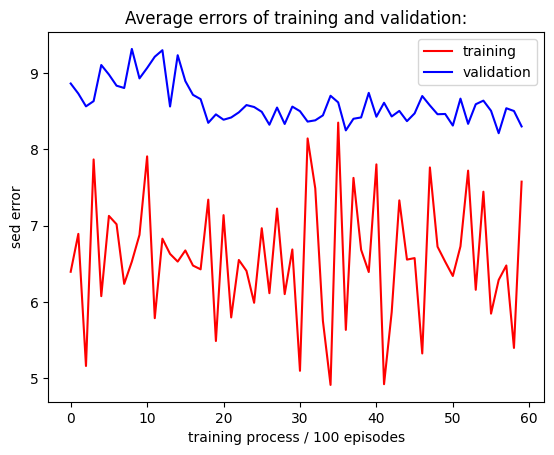

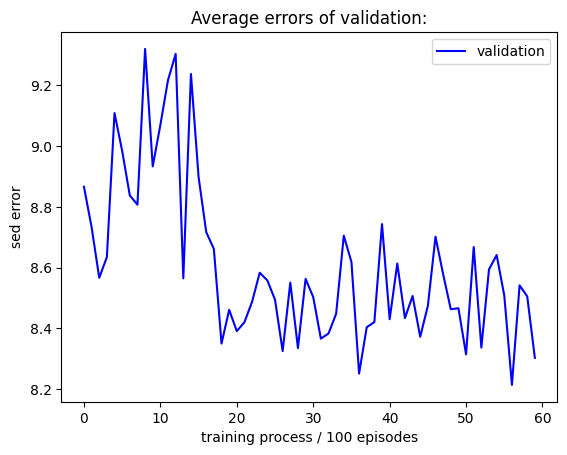

In [10]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.4, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 6.487705230712891s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


round 0 episode 100: Training error: 4.579139378029085, Validation error: 5.918539923682314
Save model with error 5.918539923682314
==>current best model is 5.918539923682314 with ratio 0.5
It costs 125.89203643798828s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 0 episode 200: Training error: 4.149900746269105, Validation error: 5.714438738664527
Save model with error 5.714438738664527
==>current best model is 5.714438738664527 with ratio 0.5
It costs 124.71038579940796s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


round 1 episode 100: Training error: 3.7124099977524154, Validation error: 5.905198656753341
==>current best model is 5.714438738664527 with ratio 0.5
It costs 134.00527215003967s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


round 1 episode 200: Training error: 4.9552540741518705, Validation error: 5.555850340145138
Save model with error 5.555850340145138
==>current best model is 5.555850340145138 with ratio 0.5
It costs 112.35265517234802s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


round 2 episode 100: Training error: 4.838385493857385, Validation error: 5.725553295863354
==>current best model is 5.555850340145138 with ratio 0.5
It costs 104.33067798614502s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 2 episode 200: Training error: 3.7927204451594196, Validation error: 5.952569366882675
==>current best model is 5.555850340145138 with ratio 0.5
It costs 157.09652137756348s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


round 3 episode 100: Training error: 4.965472783931264, Validation error: 5.618347756376027
==>current best model is 5.555850340145138 with ratio 0.5
It costs 139.88788890838623s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


round 3 episode 200: Training error: 3.6358974053672926, Validation error: 5.597448254164162
==>current best model is 5.555850340145138 with ratio 0.5
It costs 133.46214175224304s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.56it/s]


round 4 episode 100: Training error: 4.133144212262109, Validation error: 5.76222580994712
==>current best model is 5.555850340145138 with ratio 0.5
It costs 122.56455755233765s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


round 4 episode 200: Training error: 4.524086178299866, Validation error: 5.591167671407794
==>current best model is 5.555850340145138 with ratio 0.5
It costs 132.3392951488495s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 5 episode 100: Training error: 5.04201723083226, Validation error: 5.482194010218034
Save model with error 5.482194010218034
==>current best model is 5.482194010218034 with ratio 0.5
It costs 121.12949132919312s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


round 5 episode 200: Training error: 3.538775370783489, Validation error: 5.531111513886224
==>current best model is 5.482194010218034 with ratio 0.5
It costs 121.45539093017578s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 6 episode 100: Training error: 5.21058240183668, Validation error: 5.585934406851497
==>current best model is 5.482194010218034 with ratio 0.5
It costs 120.89843535423279s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


round 6 episode 200: Training error: 3.318913844574618, Validation error: 5.496776325486585
==>current best model is 5.482194010218034 with ratio 0.5
It costs 121.96487259864807s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


round 7 episode 100: Training error: 3.505185766423026, Validation error: 5.5235128278861385
==>current best model is 5.482194010218034 with ratio 0.5
It costs 116.91380858421326s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


round 7 episode 200: Training error: 5.11061017565726, Validation error: 5.639208512923816
==>current best model is 5.482194010218034 with ratio 0.5
It costs 124.53958988189697s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


round 8 episode 100: Training error: 3.2576957759425613, Validation error: 5.463531898394435
Save model with error 5.463531898394435
==>current best model is 5.463531898394435 with ratio 0.5
It costs 115.04124927520752s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


round 8 episode 200: Training error: 5.226521426812695, Validation error: 5.544927101951813
==>current best model is 5.463531898394435 with ratio 0.5
It costs 128.2899034023285s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


round 9 episode 100: Training error: 4.64859210687247, Validation error: 5.624212387278025
==>current best model is 5.463531898394435 with ratio 0.5
It costs 118.03806638717651s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


round 9 episode 200: Training error: 3.877915078049942, Validation error: 5.514216696884167
==>current best model is 5.463531898394435 with ratio 0.5
It costs 124.55390524864197s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


round 10 episode 100: Training error: 4.9496674820121465, Validation error: 5.474427920862477
==>current best model is 5.463531898394435 with ratio 0.5
It costs 113.21762228012085s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


round 10 episode 200: Training error: 3.577595021272625, Validation error: 5.552078605618273
==>current best model is 5.463531898394435 with ratio 0.5
It costs 131.5157597064972s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 11 episode 100: Training error: 4.260054923327005, Validation error: 5.413340064055946
Save model with error 5.413340064055946
==>current best model is 5.413340064055946 with ratio 0.5
It costs 121.7976438999176s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


round 11 episode 200: Training error: 4.244377508023989, Validation error: 5.814162575901246
==>current best model is 5.413340064055946 with ratio 0.5
It costs 122.32873845100403s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


round 12 episode 100: Training error: 4.255549181759093, Validation error: 5.584491032150985
==>current best model is 5.413340064055946 with ratio 0.5
It costs 116.24765539169312s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


round 12 episode 200: Training error: 4.387484118676768, Validation error: 5.459284195300242
==>current best model is 5.413340064055946 with ratio 0.5
It costs 124.5613157749176s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


round 13 episode 100: Training error: 3.5247154413963524, Validation error: 5.428360727803705
==>current best model is 5.413340064055946 with ratio 0.5
It costs 122.95818090438843s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


round 13 episode 200: Training error: 5.003352929475038, Validation error: 5.513129237042982
==>current best model is 5.413340064055946 with ratio 0.5
It costs 118.46111845970154s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.49it/s]


round 14 episode 100: Training error: 4.844480507268686, Validation error: 5.624905411982552
==>current best model is 5.413340064055946 with ratio 0.5
It costs 130.79305863380432s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


round 14 episode 200: Training error: 3.610022901111049, Validation error: 5.578527893794413
==>current best model is 5.413340064055946 with ratio 0.5
It costs 115.63288164138794s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


round 15 episode 100: Training error: 3.5377796206970125, Validation error: 5.522961349232213
==>current best model is 5.413340064055946 with ratio 0.5
It costs 123.76906228065491s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


round 15 episode 200: Training error: 5.055070879164172, Validation error: 5.8356936216369055
==>current best model is 5.413340064055946 with ratio 0.5
It costs 118.37921500205994s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


round 16 episode 100: Training error: 4.44809829111243, Validation error: 5.626987750731522
==>current best model is 5.413340064055946 with ratio 0.5
It costs 122.38557982444763s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 16 episode 200: Training error: 4.276780109985122, Validation error: 5.573802576558457
==>current best model is 5.413340064055946 with ratio 0.5
It costs 140.4550461769104s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


round 17 episode 100: Training error: 3.413633665450078, Validation error: 5.622843593586239
==>current best model is 5.413340064055946 with ratio 0.5
It costs 127.4848153591156s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


round 17 episode 200: Training error: 5.2050983070858186, Validation error: 5.61543853374675
==>current best model is 5.413340064055946 with ratio 0.5
It costs 114.15538215637207s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


round 18 episode 100: Training error: 4.1141060666108595, Validation error: 5.606057402081023
==>current best model is 5.413340064055946 with ratio 0.5
It costs 126.59477090835571s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


round 18 episode 200: Training error: 4.605630865636516, Validation error: 5.57515874930405
==>current best model is 5.413340064055946 with ratio 0.5
It costs 117.40752744674683s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


round 19 episode 100: Training error: 3.823505641491234, Validation error: 5.571255494435939
==>current best model is 5.413340064055946 with ratio 0.5
It costs 116.83263945579529s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


round 19 episode 200: Training error: 4.830153363540062, Validation error: 5.570449309979345
==>current best model is 5.413340064055946 with ratio 0.5
It costs 125.56002640724182s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 20 episode 100: Training error: 3.0067704060260754, Validation error: 5.618636404183097
==>current best model is 5.413340064055946 with ratio 0.5
It costs 137.5742552280426s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


round 20 episode 200: Training error: 5.610341939852581, Validation error: 5.594552179713504
==>current best model is 5.413340064055946 with ratio 0.5
It costs 103.4541745185852s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


round 21 episode 100: Training error: 3.8849919649594313, Validation error: 5.553841731294738
==>current best model is 5.413340064055946 with ratio 0.5
It costs 127.08250260353088s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.72it/s]


round 21 episode 200: Training error: 4.715274593848451, Validation error: 5.613344112098393
==>current best model is 5.413340064055946 with ratio 0.5
It costs 115.93630933761597s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


round 22 episode 100: Training error: 4.771630772484874, Validation error: 5.5595279818639876
==>current best model is 5.413340064055946 with ratio 0.5
It costs 117.49925565719604s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


round 22 episode 200: Training error: 3.8282110082625014, Validation error: 5.604039244325218
==>current best model is 5.413340064055946 with ratio 0.5
It costs 123.19791626930237s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


round 23 episode 100: Training error: 4.2353158368189465, Validation error: 5.604243409964929
==>current best model is 5.413340064055946 with ratio 0.5
It costs 109.62747621536255s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


round 23 episode 200: Training error: 4.399434706829541, Validation error: 5.633657793812226
==>current best model is 5.413340064055946 with ratio 0.5
It costs 131.13861393928528s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


round 24 episode 100: Training error: 4.005212207017169, Validation error: 5.549889708814227
==>current best model is 5.413340064055946 with ratio 0.5
It costs 132.18007922172546s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 24 episode 200: Training error: 4.616006713957183, Validation error: 5.607209016079151
==>current best model is 5.413340064055946 with ratio 0.5
It costs 143.22648692131042s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


round 25 episode 100: Training error: 4.331175560696775, Validation error: 5.615903791477964
==>current best model is 5.413340064055946 with ratio 0.5
It costs 131.9378445148468s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


round 25 episode 200: Training error: 4.281245534830768, Validation error: 5.605704072981695
==>current best model is 5.413340064055946 with ratio 0.5
It costs 119.59426307678223s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 26 episode 100: Training error: 4.290576328144871, Validation error: 5.589443740185039
==>current best model is 5.413340064055946 with ratio 0.5
It costs 120.85596060752869s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


round 26 episode 200: Training error: 4.307705158591625, Validation error: 5.621446824129437
==>current best model is 5.413340064055946 with ratio 0.5
It costs 130.16880702972412s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


round 27 episode 100: Training error: 4.150454173256387, Validation error: 5.587836371476011
==>current best model is 5.413340064055946 with ratio 0.5
It costs 119.83060669898987s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


round 27 episode 200: Training error: 4.471958391710632, Validation error: 5.608749741327861
==>current best model is 5.413340064055946 with ratio 0.5
It costs 124.99294924736023s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


round 28 episode 100: Training error: 3.2963095700494063, Validation error: 5.639506741570932
==>current best model is 5.413340064055946 with ratio 0.5
It costs 123.72287631034851s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]


round 28 episode 200: Training error: 5.329838647794514, Validation error: 5.613033172880381
==>current best model is 5.413340064055946 with ratio 0.5
It costs 125.15879392623901s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


round 29 episode 100: Training error: 4.1358443928140005, Validation error: 5.62002421697583
==>current best model is 5.413340064055946 with ratio 0.5
It costs 126.63760137557983s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


round 29 episode 200: Training error: 4.496574229376857, Validation error: 5.596412209877354
==>current best model is 5.413340064055946 with ratio 0.5
It costs 117.96187782287598s
Training elapsed time = %s 7431.784804821014


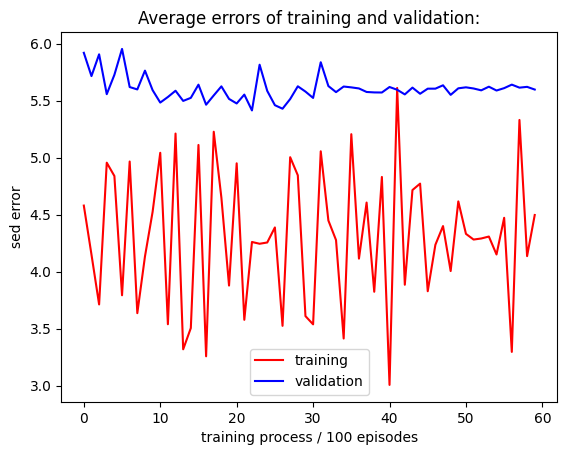

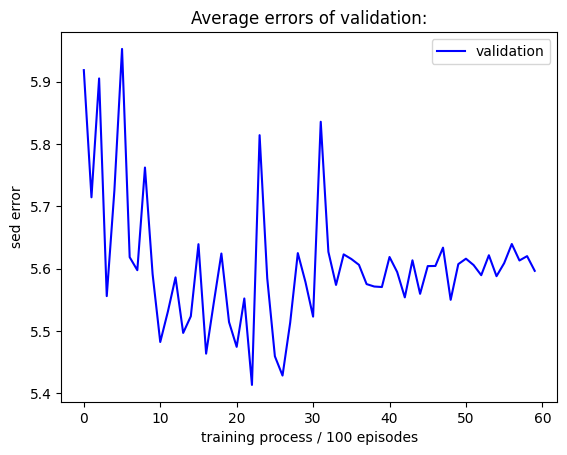

In [11]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.5, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 11.388822317123413s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.06it/s]


round 0 episode 100: Training error: 10.815543582057721, Validation error: 13.855496133611156
Save model with error 13.855496133611156
==>current best model is 13.855496133611156 with ratio 0.2
It costs 185.6851100921631s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 0 episode 200: Training error: 8.556655320390046, Validation error: 14.686221042157191
==>current best model is 13.855496133611156 with ratio 0.2
It costs 184.58436465263367s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 1 episode 100: Training error: 9.573573837547197, Validation error: 13.364927377583978
Save model with error 13.364927377583978
==>current best model is 13.364927377583978 with ratio 0.2
It costs 173.0698597431183s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 1 episode 200: Training error: 11.55548496414852, Validation error: 13.426437692569676
==>current best model is 13.364927377583978 with ratio 0.2
It costs 185.31355166435242s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 2 episode 100: Training error: 8.385036088782655, Validation error: 14.814941283678865
==>current best model is 13.364927377583978 with ratio 0.2
It costs 168.0191252231598s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 2 episode 200: Training error: 16.178498088291374, Validation error: 14.50147602285972
==>current best model is 13.364927377583978 with ratio 0.2
It costs 184.84144830703735s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 3 episode 100: Training error: 14.734160429884406, Validation error: 12.706623745567336
Save model with error 12.706623745567336
==>current best model is 12.706623745567336 with ratio 0.2
It costs 173.7536976337433s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 3 episode 200: Training error: 7.974754472716808, Validation error: 12.551269584671322
Save model with error 12.551269584671322
==>current best model is 12.551269584671322 with ratio 0.2
It costs 180.73830270767212s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


round 4 episode 100: Training error: 7.9443907697904725, Validation error: 17.09120755113068
==>current best model is 12.551269584671322 with ratio 0.2
It costs 170.758948802948s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 4 episode 200: Training error: 14.223731018906186, Validation error: 12.942476520129604
==>current best model is 12.551269584671322 with ratio 0.2
It costs 182.31955480575562s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 5 episode 100: Training error: 7.6075885707016315, Validation error: 12.572656821635102
==>current best model is 12.551269584671322 with ratio 0.2
It costs 175.83752846717834s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 5 episode 200: Training error: 13.153847224272475, Validation error: 14.350486042587951
==>current best model is 12.551269584671322 with ratio 0.2
It costs 183.31729865074158s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 6 episode 100: Training error: 11.776649821359754, Validation error: 14.466060873097133
==>current best model is 12.551269584671322 with ratio 0.2
It costs 198.543883562088s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 6 episode 200: Training error: 7.92063235571942, Validation error: 13.713370327051091
==>current best model is 12.551269584671322 with ratio 0.2
It costs 169.0715730190277s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 7 episode 100: Training error: 8.794062411221013, Validation error: 14.493495745662708
==>current best model is 12.551269584671322 with ratio 0.2
It costs 166.9151861667633s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 7 episode 200: Training error: 11.7214540273683, Validation error: 12.714750343084186
==>current best model is 12.551269584671322 with ratio 0.2
It costs 188.49235916137695s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 8 episode 100: Training error: 8.044021707100512, Validation error: 17.436125826051903
==>current best model is 12.551269584671322 with ratio 0.2
It costs 171.88380765914917s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 8 episode 200: Training error: 14.216987039603028, Validation error: 13.75281189531037
==>current best model is 12.551269584671322 with ratio 0.2
It costs 188.26172637939453s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 9 episode 100: Training error: 8.307330713014801, Validation error: 13.831269753047582
==>current best model is 12.551269584671322 with ratio 0.2
It costs 175.16018676757812s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.08it/s]


round 9 episode 200: Training error: 13.754594860477273, Validation error: 13.082431611186117
==>current best model is 12.551269584671322 with ratio 0.2
It costs 179.29985857009888s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 10 episode 100: Training error: 11.189828966115071, Validation error: 12.376023713957432
Save model with error 12.376023713957432
==>current best model is 12.376023713957432 with ratio 0.2
It costs 174.51146817207336s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 10 episode 200: Training error: 9.0488347664044, Validation error: 13.755032477676915
==>current best model is 12.376023713957432 with ratio 0.2
It costs 183.8232820034027s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 11 episode 100: Training error: 7.63946079532632, Validation error: 14.731396017878199
==>current best model is 12.376023713957432 with ratio 0.2
It costs 191.45861411094666s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 11 episode 200: Training error: 14.444884195017094, Validation error: 13.355075357204882
==>current best model is 12.376023713957432 with ratio 0.2
It costs 169.66023564338684s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 12 episode 100: Training error: 13.244767710803101, Validation error: 15.659654443694789
==>current best model is 12.376023713957432 with ratio 0.2
It costs 171.40236616134644s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 12 episode 200: Training error: 7.58078462773269, Validation error: 14.768568117572467
==>current best model is 12.376023713957432 with ratio 0.2
It costs 187.85918807983398s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 13 episode 100: Training error: 11.663093480075128, Validation error: 17.79158850002226
==>current best model is 12.376023713957432 with ratio 0.2
It costs 188.81430339813232s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 13 episode 200: Training error: 8.849890410700779, Validation error: 14.024561305210389
==>current best model is 12.376023713957432 with ratio 0.2
It costs 170.2786099910736s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 14 episode 100: Training error: 13.722734998666468, Validation error: 13.994517379877475
==>current best model is 12.376023713957432 with ratio 0.2
It costs 190.83373260498047s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 14 episode 200: Training error: 8.413478635163356, Validation error: 15.036104601126281
==>current best model is 12.376023713957432 with ratio 0.2
It costs 169.71369409561157s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


round 15 episode 100: Training error: 8.809296157449232, Validation error: 14.663815882489805
==>current best model is 12.376023713957432 with ratio 0.2
It costs 182.82027196884155s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


round 15 episode 200: Training error: 13.516085000823045, Validation error: 13.711139221274493
==>current best model is 12.376023713957432 with ratio 0.2
It costs 172.91793966293335s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


round 16 episode 100: Training error: 16.76108072281717, Validation error: 14.139028340077676
==>current best model is 12.376023713957432 with ratio 0.2
It costs 168.08727264404297s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 16 episode 200: Training error: 6.951820761827919, Validation error: 12.712143868925814
==>current best model is 12.376023713957432 with ratio 0.2
It costs 191.94534301757812s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 17 episode 100: Training error: 15.028089034249563, Validation error: 13.980882219965629
==>current best model is 12.376023713957432 with ratio 0.2
It costs 180.7865834236145s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 17 episode 200: Training error: 8.337798418967783, Validation error: 13.257275870594016
==>current best model is 12.376023713957432 with ratio 0.2
It costs 179.73984789848328s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 18 episode 100: Training error: 8.1915689679752, Validation error: 13.310835422817394
==>current best model is 12.376023713957432 with ratio 0.2
It costs 175.73479580879211s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 18 episode 200: Training error: 16.642651495924966, Validation error: 13.468429545389023
==>current best model is 12.376023713957432 with ratio 0.2
It costs 186.9309582710266s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 19 episode 100: Training error: 12.06998629521113, Validation error: 14.214684011137445
==>current best model is 12.376023713957432 with ratio 0.2
It costs 184.36874389648438s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


round 19 episode 200: Training error: 8.422917774477815, Validation error: 13.329808001714104
==>current best model is 12.376023713957432 with ratio 0.2
It costs 173.28969597816467s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 20 episode 100: Training error: 8.380775970600697, Validation error: 13.1267119713834
==>current best model is 12.376023713957432 with ratio 0.2
It costs 187.49648761749268s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 20 episode 200: Training error: 10.341385517885993, Validation error: 15.12261586759085
==>current best model is 12.376023713957432 with ratio 0.2
It costs 166.40829801559448s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 21 episode 100: Training error: 12.732640626701512, Validation error: 11.943395342910161
Save model with error 11.943395342910161
==>current best model is 11.943395342910161 with ratio 0.2
It costs 189.0780107975006s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 21 episode 200: Training error: 7.102828674006242, Validation error: 12.246589649664397
==>current best model is 11.943395342910161 with ratio 0.2
It costs 169.35949301719666s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 22 episode 100: Training error: 9.867921915872214, Validation error: 13.464904403775684
==>current best model is 11.943395342910161 with ratio 0.2
It costs 169.67514061927795s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 22 episode 200: Training error: 8.507486806331427, Validation error: 12.560483262262517
==>current best model is 11.943395342910161 with ratio 0.2
It costs 187.60313963890076s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 23 episode 100: Training error: 12.997348408065905, Validation error: 11.638178567620312
Save model with error 11.638178567620312
==>current best model is 11.638178567620312 with ratio 0.2
It costs 180.66611003875732s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


round 23 episode 200: Training error: 8.304250001712283, Validation error: 12.12419547827239
==>current best model is 11.638178567620312 with ratio 0.2
It costs 175.99496579170227s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 24 episode 100: Training error: 13.546232240218849, Validation error: 12.267719476253111
==>current best model is 11.638178567620312 with ratio 0.2
It costs 171.01795029640198s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 24 episode 200: Training error: 6.478620678637368, Validation error: 15.547479091307764
==>current best model is 11.638178567620312 with ratio 0.2
It costs 196.38077664375305s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 25 episode 100: Training error: 11.166933204442916, Validation error: 14.315546806335314
==>current best model is 11.638178567620312 with ratio 0.2
It costs 165.97624468803406s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 25 episode 200: Training error: 7.477607782612218, Validation error: 13.294381518703425
==>current best model is 11.638178567620312 with ratio 0.2
It costs 190.4942979812622s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 26 episode 100: Training error: 8.448036771567779, Validation error: 11.410264511917939
Save model with error 11.410264511917939
==>current best model is 11.410264511917939 with ratio 0.2
It costs 175.60423183441162s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 26 episode 200: Training error: 10.229373031171265, Validation error: 12.882199541889692
==>current best model is 11.410264511917939 with ratio 0.2
It costs 186.7838897705078s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 27 episode 100: Training error: 10.668837703555702, Validation error: 15.086439588139982
==>current best model is 11.410264511917939 with ratio 0.2
It costs 172.19766545295715s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 27 episode 200: Training error: 8.19661053564148, Validation error: 13.304920103577121
==>current best model is 11.410264511917939 with ratio 0.2
It costs 189.2665376663208s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 28 episode 100: Training error: 10.967273743606151, Validation error: 13.582900438097745
==>current best model is 11.410264511917939 with ratio 0.2
It costs 179.18054032325745s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 28 episode 200: Training error: 7.6998140676454, Validation error: 12.613984018505954
==>current best model is 11.410264511917939 with ratio 0.2
It costs 186.25640034675598s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 29 episode 100: Training error: 8.502191054700797, Validation error: 13.649992069192988
==>current best model is 11.410264511917939 with ratio 0.2
It costs 199.3712968826294s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 29 episode 200: Training error: 9.616618831749575, Validation error: 12.392207823590974
==>current best model is 11.410264511917939 with ratio 0.2
It costs 175.8002803325653s
Training elapsed time = %s 10795.46134185791


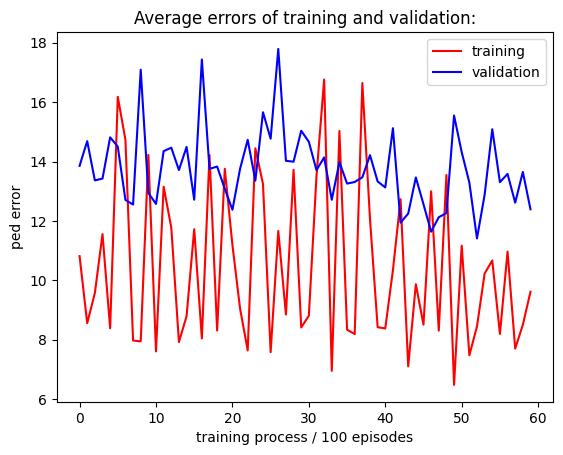

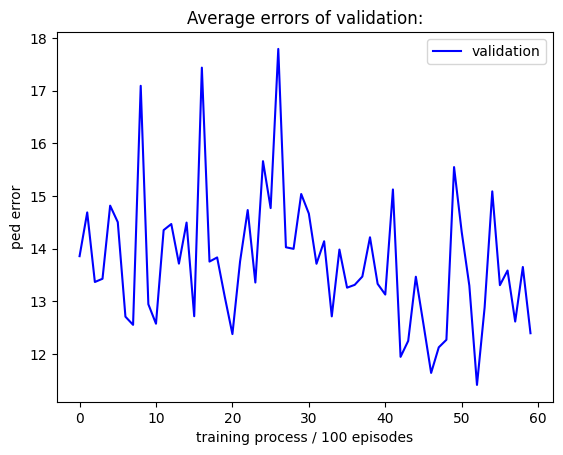

In [12]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.2, a_size=3, s_size=3, label='ped')

======loading train data======
It cost 5.767244577407837s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 0 episode 100: Training error: 5.621348620649778, Validation error: 7.130316945104781
Save model with error 7.130316945104781
==>current best model is 7.130316945104781 with ratio 0.3
It costs 162.49436593055725s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 0 episode 200: Training error: 5.332692186563332, Validation error: 7.00488520043169
Save model with error 7.00488520043169
==>current best model is 7.00488520043169 with ratio 0.3
It costs 155.2772011756897s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


round 1 episode 100: Training error: 6.170730824966552, Validation error: 7.601732001162735
==>current best model is 7.00488520043169 with ratio 0.3
It costs 148.35796785354614s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 1 episode 200: Training error: 4.892302490423624, Validation error: 8.163765532938557
==>current best model is 7.00488520043169 with ratio 0.3
It costs 163.95523142814636s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


round 2 episode 100: Training error: 6.655747690193078, Validation error: 8.10451010939667
==>current best model is 7.00488520043169 with ratio 0.3
It costs 144.95219802856445s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 2 episode 200: Training error: 4.0540404503542025, Validation error: 8.13581079632797
==>current best model is 7.00488520043169 with ratio 0.3
It costs 165.27541327476501s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 3 episode 100: Training error: 6.435597548040659, Validation error: 7.421021043331542
==>current best model is 7.00488520043169 with ratio 0.3
It costs 159.84482741355896s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 3 episode 200: Training error: 4.412672764754803, Validation error: 7.570402020722919
==>current best model is 7.00488520043169 with ratio 0.3
It costs 151.43901896476746s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 4 episode 100: Training error: 3.7728979348600378, Validation error: 8.343849457465849
==>current best model is 7.00488520043169 with ratio 0.3
It costs 159.86419773101807s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 4 episode 200: Training error: 6.805245724304773, Validation error: 7.391520932498598
==>current best model is 7.00488520043169 with ratio 0.3
It costs 153.67638421058655s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


round 5 episode 100: Training error: 6.566066744251375, Validation error: 7.900326999927756
==>current best model is 7.00488520043169 with ratio 0.3
It costs 164.08359932899475s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


round 5 episode 200: Training error: 5.06748863231763, Validation error: 8.300204074675518
==>current best model is 7.00488520043169 with ratio 0.3
It costs 157.07850575447083s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 6 episode 100: Training error: 6.193680022143897, Validation error: 6.968387987639472
Save model with error 6.968387987639472
==>current best model is 6.968387987639472 with ratio 0.3
It costs 165.82655000686646s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


round 6 episode 200: Training error: 4.724710851923647, Validation error: 7.750688055644467
==>current best model is 6.968387987639472 with ratio 0.3
It costs 145.3901081085205s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 7 episode 100: Training error: 4.622767417590915, Validation error: 6.87861371929187
Save model with error 6.87861371929187
==>current best model is 6.87861371929187 with ratio 0.3
It costs 159.97975826263428s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


round 7 episode 200: Training error: 6.193975510529764, Validation error: 6.902510020871264
==>current best model is 6.87861371929187 with ratio 0.3
It costs 153.11398196220398s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


round 8 episode 100: Training error: 6.602528473539569, Validation error: 7.288140931052806
==>current best model is 6.87861371929187 with ratio 0.3
It costs 147.96123385429382s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


round 8 episode 200: Training error: 3.8814523794096862, Validation error: 7.144459009269567
==>current best model is 6.87861371929187 with ratio 0.3
It costs 170.51555633544922s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


round 9 episode 100: Training error: 4.116555753371292, Validation error: 7.297691461532855
==>current best model is 6.87861371929187 with ratio 0.3
It costs 159.92582654953003s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 9 episode 200: Training error: 5.847009210788395, Validation error: 6.719043821935095
Save model with error 6.719043821935095
==>current best model is 6.719043821935095 with ratio 0.3
It costs 152.52927017211914s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 10 episode 100: Training error: 3.2280100770433737, Validation error: 8.106412672900095
==>current best model is 6.719043821935095 with ratio 0.3
It costs 162.31581044197083s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


round 10 episode 200: Training error: 7.025004345790043, Validation error: 6.653176186465544
Save model with error 6.653176186465544
==>current best model is 6.653176186465544 with ratio 0.3
It costs 152.30777716636658s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


round 11 episode 100: Training error: 4.8208384885756095, Validation error: 7.252139975473612
==>current best model is 6.653176186465544 with ratio 0.3
It costs 143.25277137756348s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 11 episode 200: Training error: 5.056119137425301, Validation error: 6.597444473103685
Save model with error 6.597444473103685
==>current best model is 6.597444473103685 with ratio 0.3
It costs 170.2140703201294s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


round 12 episode 100: Training error: 5.382412419579834, Validation error: 6.699899922089945
==>current best model is 6.597444473103685 with ratio 0.3
It costs 163.63803815841675s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


round 12 episode 200: Training error: 4.698746911801293, Validation error: 7.601370385393121
==>current best model is 6.597444473103685 with ratio 0.3
It costs 149.5063123703003s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 13 episode 100: Training error: 5.634357425757583, Validation error: 6.394714747807948
Save model with error 6.394714747807948
==>current best model is 6.394714747807948 with ratio 0.3
It costs 174.03632068634033s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


round 13 episode 200: Training error: 4.287595844519527, Validation error: 6.454978515876529
==>current best model is 6.394714747807948 with ratio 0.3
It costs 140.74640011787415s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 14 episode 100: Training error: 5.61826748456593, Validation error: 6.935027837531119
==>current best model is 6.394714747807948 with ratio 0.3
It costs 157.6216323375702s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 14 episode 200: Training error: 4.518488736114835, Validation error: 7.058576430812544
==>current best model is 6.394714747807948 with ratio 0.3
It costs 153.89696145057678s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


round 15 episode 100: Training error: 5.665638700446501, Validation error: 6.7004576803214535
==>current best model is 6.394714747807948 with ratio 0.3
It costs 148.47150421142578s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


round 15 episode 200: Training error: 4.2670019587891055, Validation error: 6.523134652243176
==>current best model is 6.394714747807948 with ratio 0.3
It costs 163.35330080986023s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


round 16 episode 100: Training error: 4.500434440846257, Validation error: 6.573972411295089
==>current best model is 6.394714747807948 with ratio 0.3
It costs 157.62906312942505s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


round 16 episode 200: Training error: 5.635790283008963, Validation error: 7.4838231686846415
==>current best model is 6.394714747807948 with ratio 0.3
It costs 166.477520942688s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 17 episode 100: Training error: 5.232568057946192, Validation error: 6.716677342491874
==>current best model is 6.394714747807948 with ratio 0.3
It costs 163.80195784568787s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 17 episode 200: Training error: 4.711438064758926, Validation error: 6.530852745190018
==>current best model is 6.394714747807948 with ratio 0.3
It costs 151.6999135017395s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 18 episode 100: Training error: 5.926961410999388, Validation error: 6.731688402881754
==>current best model is 6.394714747807948 with ratio 0.3
It costs 162.71062970161438s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


round 18 episode 200: Training error: 4.035258458917298, Validation error: 6.686178598817737
==>current best model is 6.394714747807948 with ratio 0.3
It costs 166.9681475162506s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 19 episode 100: Training error: 4.870363217950562, Validation error: 7.911012041291578
==>current best model is 6.394714747807948 with ratio 0.3
It costs 152.04448056221008s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 19 episode 200: Training error: 4.6619656949955575, Validation error: 6.6203765999742075
==>current best model is 6.394714747807948 with ratio 0.3
It costs 153.1965274810791s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 20 episode 100: Training error: 4.295172992371713, Validation error: 7.03732540453493
==>current best model is 6.394714747807948 with ratio 0.3
It costs 152.30063152313232s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 20 episode 200: Training error: 5.794135125881788, Validation error: 6.680464459424196
==>current best model is 6.394714747807948 with ratio 0.3
It costs 151.11611199378967s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 21 episode 100: Training error: 6.11117378632306, Validation error: 6.75480856254685
==>current best model is 6.394714747807948 with ratio 0.3
It costs 165.88515543937683s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


round 21 episode 200: Training error: 4.4912780582888345, Validation error: 6.799434259426465
==>current best model is 6.394714747807948 with ratio 0.3
It costs 141.94043278694153s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 22 episode 100: Training error: 6.136863613058463, Validation error: 6.511752915962689
==>current best model is 6.394714747807948 with ratio 0.3
It costs 156.83134150505066s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


round 22 episode 200: Training error: 4.022987437816845, Validation error: 7.404418143447348
==>current best model is 6.394714747807948 with ratio 0.3
It costs 146.797345161438s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 23 episode 100: Training error: 4.2858238919117415, Validation error: 7.240181421350863
==>current best model is 6.394714747807948 with ratio 0.3
It costs 149.1755633354187s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


round 23 episode 200: Training error: 5.686273780041397, Validation error: 6.535125747211781
==>current best model is 6.394714747807948 with ratio 0.3
It costs 156.66608357429504s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 24 episode 100: Training error: 3.983772915185367, Validation error: 6.28468338083818
Save model with error 6.28468338083818
==>current best model is 6.28468338083818 with ratio 0.3
It costs 153.79956364631653s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 24 episode 200: Training error: 5.695272455909547, Validation error: 6.570298403502636
==>current best model is 6.28468338083818 with ratio 0.3
It costs 151.87278604507446s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


round 25 episode 100: Training error: 3.7279586799335727, Validation error: 6.706253663777773
==>current best model is 6.28468338083818 with ratio 0.3
It costs 140.49186301231384s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


round 25 episode 200: Training error: 6.325027948001109, Validation error: 8.260237251626759
==>current best model is 6.28468338083818 with ratio 0.3
It costs 159.32757115364075s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


round 26 episode 100: Training error: 3.89106460501086, Validation error: 6.504044868348987
==>current best model is 6.28468338083818 with ratio 0.3
It costs 149.44924473762512s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 26 episode 200: Training error: 6.017323292739062, Validation error: 7.535750162884767
==>current best model is 6.28468338083818 with ratio 0.3
It costs 150.78777289390564s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


round 27 episode 100: Training error: 3.7027642245687375, Validation error: 6.2398722412865135
Save model with error 6.2398722412865135
==>current best model is 6.2398722412865135 with ratio 0.3
It costs 134.97774386405945s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 27 episode 200: Training error: 6.421897062366427, Validation error: 6.369745693219272
==>current best model is 6.2398722412865135 with ratio 0.3
It costs 169.3178789615631s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


round 28 episode 100: Training error: 6.319755202139261, Validation error: 7.513624646560619
==>current best model is 6.2398722412865135 with ratio 0.3
It costs 155.03990721702576s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 28 episode 200: Training error: 3.6923373440190432, Validation error: 7.333425104588064
==>current best model is 6.2398722412865135 with ratio 0.3
It costs 152.83506679534912s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


round 29 episode 100: Training error: 4.065433759965266, Validation error: 6.145233912911832
Save model with error 6.145233912911832
==>current best model is 6.145233912911832 with ratio 0.3
It costs 149.90706872940063s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 29 episode 200: Training error: 5.882651370309826, Validation error: 7.002847136238469
==>current best model is 6.145233912911832 with ratio 0.3
It costs 153.67763137817383s
Training elapsed time = %s 9337.630490779877


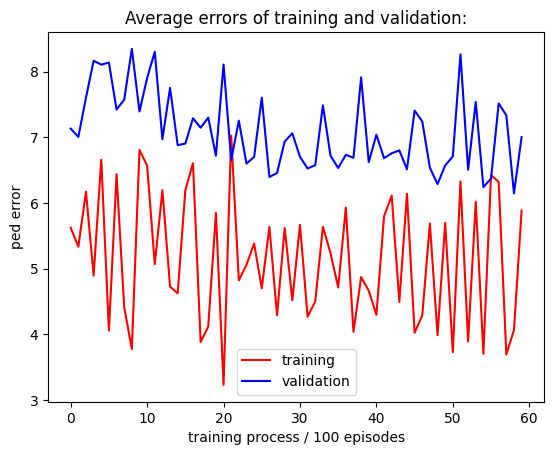

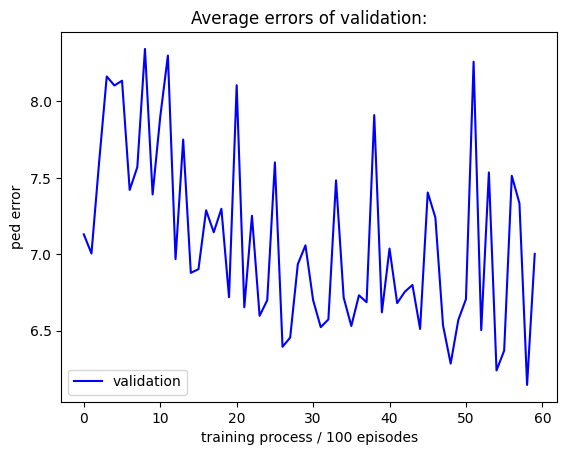

In [13]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.3, a_size=3, s_size=3, label='ped')

======loading train data======
It cost 5.878201246261597s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


round 0 episode 100: Training error: 3.2085105502868663, Validation error: 3.8035974204806102
Save model with error 3.8035974204806102
==>current best model is 3.8035974204806102 with ratio 0.4
It costs 140.73247265815735s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


round 0 episode 200: Training error: 2.5457644350149056, Validation error: 3.3648901525093944
Save model with error 3.3648901525093944
==>current best model is 3.3648901525093944 with ratio 0.4
It costs 122.53450536727905s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


round 1 episode 100: Training error: 3.624383630367566, Validation error: 3.415478178418788
==>current best model is 3.3648901525093944 with ratio 0.4
It costs 133.12776517868042s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


round 1 episode 200: Training error: 2.274647596045556, Validation error: 3.337915760866726
Save model with error 3.337915760866726
==>current best model is 3.337915760866726 with ratio 0.4
It costs 129.29382848739624s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]


round 2 episode 100: Training error: 2.7537010216363225, Validation error: 3.693391314580071
==>current best model is 3.337915760866726 with ratio 0.4
It costs 124.62362718582153s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 2 episode 200: Training error: 2.9225578951104505, Validation error: 3.6164606467627287
==>current best model is 3.337915760866726 with ratio 0.4
It costs 146.7225215435028s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


round 3 episode 100: Training error: 2.4738299464940328, Validation error: 3.720984867916978
==>current best model is 3.337915760866726 with ratio 0.4
It costs 138.46871757507324s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


round 3 episode 200: Training error: 3.359681631223101, Validation error: 3.5232194385449023
==>current best model is 3.337915760866726 with ratio 0.4
It costs 121.94463539123535s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 4 episode 100: Training error: 3.4852440887562546, Validation error: 3.5718425796941085
==>current best model is 3.337915760866726 with ratio 0.4
It costs 148.88555431365967s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


round 4 episode 200: Training error: 2.252638703539013, Validation error: 3.2917144422872213
Save model with error 3.2917144422872213
==>current best model is 3.2917144422872213 with ratio 0.4
It costs 118.19446206092834s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


round 5 episode 100: Training error: 2.7326240912641806, Validation error: 3.583470740466473
==>current best model is 3.2917144422872213 with ratio 0.4
It costs 129.9008071422577s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


round 5 episode 200: Training error: 3.2218427972945944, Validation error: 3.32453098215723
==>current best model is 3.2917144422872213 with ratio 0.4
It costs 133.92203664779663s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]


round 6 episode 100: Training error: 3.697711331247427, Validation error: 3.2805303287373846
Save model with error 3.2805303287373846
==>current best model is 3.2805303287373846 with ratio 0.4
It costs 124.33014416694641s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


round 6 episode 200: Training error: 2.2887672524370526, Validation error: 3.5116474907306685
==>current best model is 3.2805303287373846 with ratio 0.4
It costs 139.6340069770813s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


round 7 episode 100: Training error: 3.2496020146178135, Validation error: 3.583797189124767
==>current best model is 3.2805303287373846 with ratio 0.4
It costs 128.5436520576477s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


round 7 episode 200: Training error: 2.7307499215636337, Validation error: 3.2790404704966885
Save model with error 3.2790404704966885
==>current best model is 3.2790404704966885 with ratio 0.4
It costs 136.527498960495s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


round 8 episode 100: Training error: 3.909529766018461, Validation error: 3.5295082886674987
==>current best model is 3.2790404704966885 with ratio 0.4
It costs 140.5116057395935s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


round 8 episode 200: Training error: 2.0490894958431833, Validation error: 3.531238043547662
==>current best model is 3.2790404704966885 with ratio 0.4
It costs 125.12099146842957s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


round 9 episode 100: Training error: 3.740995388080307, Validation error: 3.5307916311020318
==>current best model is 3.2790404704966885 with ratio 0.4
It costs 124.59004187583923s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


round 9 episode 200: Training error: 2.2317715095733615, Validation error: 3.5700563800969363
==>current best model is 3.2790404704966885 with ratio 0.4
It costs 139.0512113571167s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


round 10 episode 100: Training error: 3.528798533057963, Validation error: 3.3164458848947365
==>current best model is 3.2790404704966885 with ratio 0.4
It costs 138.73963379859924s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


round 10 episode 200: Training error: 2.4682015223221727, Validation error: 3.2939904132986224
==>current best model is 3.2790404704966885 with ratio 0.4
It costs 125.85272002220154s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


round 11 episode 100: Training error: 3.104031875048045, Validation error: 3.251841361472094
Save model with error 3.251841361472094
==>current best model is 3.251841361472094 with ratio 0.4
It costs 131.86139011383057s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


round 11 episode 200: Training error: 2.9061193615828507, Validation error: 3.239109562389149
Save model with error 3.239109562389149
==>current best model is 3.239109562389149 with ratio 0.4
It costs 132.26131296157837s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


round 12 episode 100: Training error: 2.9925194450220602, Validation error: 3.24121379815149
==>current best model is 3.239109562389149 with ratio 0.4
It costs 140.19381952285767s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


round 12 episode 200: Training error: 2.997710404825258, Validation error: 3.32016320531335
==>current best model is 3.239109562389149 with ratio 0.4
It costs 119.66358876228333s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


round 13 episode 100: Training error: 2.195790915997399, Validation error: 3.260623113670626
==>current best model is 3.239109562389149 with ratio 0.4
It costs 122.91577363014221s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


round 13 episode 200: Training error: 3.7577542049767283, Validation error: 3.2420956940141004
==>current best model is 3.239109562389149 with ratio 0.4
It costs 137.18765926361084s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


round 14 episode 100: Training error: 3.7267486157355876, Validation error: 3.2999720990908443
==>current best model is 3.239109562389149 with ratio 0.4
It costs 128.5076506137848s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


round 14 episode 200: Training error: 2.2841508558621557, Validation error: 3.5726231644632196
==>current best model is 3.239109562389149 with ratio 0.4
It costs 130.71525955200195s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


round 15 episode 100: Training error: 4.017072907468617, Validation error: 3.5836955314455445
==>current best model is 3.239109562389149 with ratio 0.4
It costs 130.6180863380432s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


round 15 episode 200: Training error: 2.0265444226667686, Validation error: 3.319932315401869
==>current best model is 3.239109562389149 with ratio 0.4
It costs 129.00381445884705s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


round 16 episode 100: Training error: 3.119126871525371, Validation error: 3.303285952782433
==>current best model is 3.239109562389149 with ratio 0.4
It costs 122.96420741081238s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


round 16 episode 200: Training error: 2.799482825970977, Validation error: 3.5691044101424794
==>current best model is 3.239109562389149 with ratio 0.4
It costs 136.48605251312256s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 17 episode 100: Training error: 2.61107870117851, Validation error: 3.5392488233598614
==>current best model is 3.239109562389149 with ratio 0.4
It costs 141.36913871765137s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


round 17 episode 200: Training error: 3.1692265620855955, Validation error: 3.554613807178746
==>current best model is 3.239109562389149 with ratio 0.4
It costs 123.80171251296997s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 18 episode 100: Training error: 2.5319260065034355, Validation error: 3.3321606094785525
==>current best model is 3.239109562389149 with ratio 0.4
It costs 139.30127930641174s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


round 18 episode 200: Training error: 3.521712875002399, Validation error: 3.584530802640139
==>current best model is 3.239109562389149 with ratio 0.4
It costs 120.71195006370544s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


round 19 episode 100: Training error: 2.565459252835495, Validation error: 3.495316330877907
==>current best model is 3.239109562389149 with ratio 0.4
It costs 138.9906587600708s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


round 19 episode 200: Training error: 3.187498460995904, Validation error: 3.5974909257300167
==>current best model is 3.239109562389149 with ratio 0.4
It costs 118.89697575569153s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 20 episode 100: Training error: 3.4178323477272192, Validation error: 3.610167335450975
==>current best model is 3.239109562389149 with ratio 0.4
It costs 140.81820583343506s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


round 20 episode 200: Training error: 2.221626104652774, Validation error: 3.5251599526269866
==>current best model is 3.239109562389149 with ratio 0.4
It costs 118.61120676994324s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 21 episode 100: Training error: 2.660433707639947, Validation error: 3.4662887371489504
==>current best model is 3.239109562389149 with ratio 0.4
It costs 146.82145404815674s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


round 21 episode 200: Training error: 3.3095864966864967, Validation error: 3.332454841227823
==>current best model is 3.239109562389149 with ratio 0.4
It costs 113.99081587791443s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]


round 22 episode 100: Training error: 2.791453466790733, Validation error: 3.289811916786321
==>current best model is 3.239109562389149 with ratio 0.4
It costs 123.91825699806213s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


round 22 episode 200: Training error: 2.8666450586273893, Validation error: 3.539611487958824
==>current best model is 3.239109562389149 with ratio 0.4
It costs 136.1510009765625s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


round 23 episode 100: Training error: 3.5402474232999053, Validation error: 3.3524642275074106
==>current best model is 3.239109562389149 with ratio 0.4
It costs 117.70445609092712s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 23 episode 200: Training error: 2.3434784892917015, Validation error: 3.4918519951724076
==>current best model is 3.239109562389149 with ratio 0.4
It costs 138.24155521392822s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


round 24 episode 100: Training error: 3.475845863363921, Validation error: 3.28269153131594
==>current best model is 3.239109562389149 with ratio 0.4
It costs 128.38158917427063s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


round 24 episode 200: Training error: 2.596342320424116, Validation error: 3.2664180413526056
==>current best model is 3.239109562389149 with ratio 0.4
It costs 131.5863528251648s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.72it/s]


round 25 episode 100: Training error: 3.312314769304318, Validation error: 3.3050102978451568
==>current best model is 3.239109562389149 with ratio 0.4
It costs 120.78634834289551s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 25 episode 200: Training error: 2.635198642267228, Validation error: 3.2858739189681523
==>current best model is 3.239109562389149 with ratio 0.4
It costs 139.49026584625244s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


round 26 episode 100: Training error: 2.4656618601314775, Validation error: 3.544108516004988
==>current best model is 3.239109562389149 with ratio 0.4
It costs 134.7205204963684s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


round 26 episode 200: Training error: 3.444995250293776, Validation error: 3.493636007015068
==>current best model is 3.239109562389149 with ratio 0.4
It costs 124.5606050491333s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


round 27 episode 100: Training error: 3.1242251231380602, Validation error: 3.3755136861035027
==>current best model is 3.239109562389149 with ratio 0.4
It costs 123.27284812927246s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


round 27 episode 200: Training error: 2.7462776438883885, Validation error: 3.2370622118852723
Save model with error 3.2370622118852723
==>current best model is 3.2370622118852723 with ratio 0.4
It costs 135.58409690856934s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 28 episode 100: Training error: 2.98177793590307, Validation error: 3.3255790156226914
==>current best model is 3.2370622118852723 with ratio 0.4
It costs 140.5446858406067s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


round 28 episode 200: Training error: 2.743599829515992, Validation error: 3.5366812015190106
==>current best model is 3.2370622118852723 with ratio 0.4
It costs 124.72245979309082s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


round 29 episode 100: Training error: 2.5317044852706188, Validation error: 3.2041817408148434
Save model with error 3.2041817408148434
==>current best model is 3.2041817408148434 with ratio 0.4
It costs 131.27619409561157s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


round 29 episode 200: Training error: 3.064225227475833, Validation error: 3.2664413237095595
==>current best model is 3.2041817408148434 with ratio 0.4
It costs 131.34822916984558s
Training elapsed time = %s 7859.238388061523


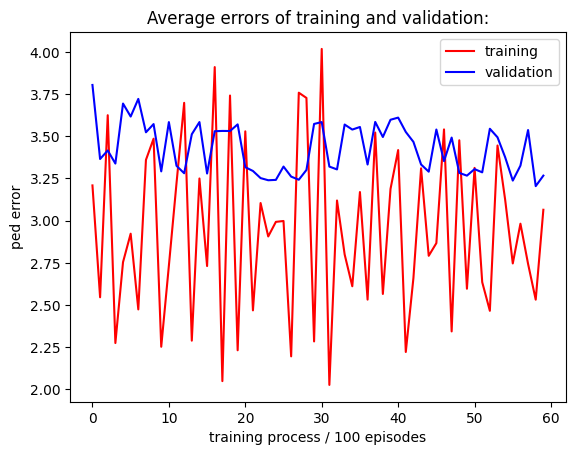

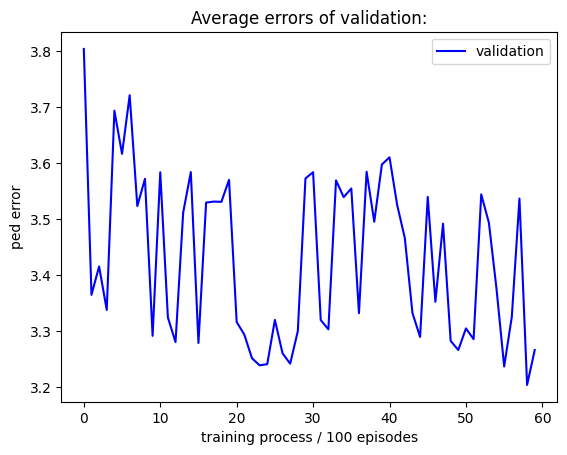

In [14]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.4, a_size=3, s_size=3, label='ped')

======loading train data======
It cost 9.481770277023315s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 0 episode 100: Training error: 1.3909720733038826, Validation error: 2.3528512561557506
Save model with error 2.3528512561557506
==>current best model is 2.3528512561557506 with ratio 0.5
It costs 167.64551424980164s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


round 0 episode 200: Training error: 2.07368554112772, Validation error: 2.2946499587130047
Save model with error 2.2946499587130047
==>current best model is 2.2946499587130047 with ratio 0.5
It costs 144.90538024902344s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 1 episode 100: Training error: 1.7200236755027682, Validation error: 2.277820908109464
Save model with error 2.277820908109464
==>current best model is 2.277820908109464 with ratio 0.5
It costs 149.91481065750122s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


round 1 episode 200: Training error: 1.7092704185883756, Validation error: 2.443973074258534
==>current best model is 2.277820908109464 with ratio 0.5
It costs 132.73607778549194s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


round 2 episode 100: Training error: 1.9367145901607083, Validation error: 2.4152603398109584
==>current best model is 2.277820908109464 with ratio 0.5
It costs 109.98729395866394s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


round 2 episode 200: Training error: 1.5060727500461166, Validation error: 2.413243336940403
==>current best model is 2.277820908109464 with ratio 0.5
It costs 113.0598394870758s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 3 episode 100: Training error: 1.803384544038523, Validation error: 2.384593745222093
==>current best model is 2.277820908109464 with ratio 0.5
It costs 115.93622827529907s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.92it/s]


round 3 episode 200: Training error: 1.6861845025172613, Validation error: 2.4417186530492985
==>current best model is 2.277820908109464 with ratio 0.5
It costs 105.20025610923767s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


round 4 episode 100: Training error: 1.7879147483287463, Validation error: 2.463493426140092
==>current best model is 2.277820908109464 with ratio 0.5
It costs 97.49927997589111s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


round 4 episode 200: Training error: 1.4818587946415798, Validation error: 2.3563512710736787
==>current best model is 2.277820908109464 with ratio 0.5
It costs 121.43882632255554s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


round 5 episode 100: Training error: 1.5169065273734161, Validation error: 2.2476291505572283
Save model with error 2.2476291505572283
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 122.79222583770752s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


round 5 episode 200: Training error: 1.7779542785945837, Validation error: 2.3368763583439653
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 98.5722508430481s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.85it/s]


round 6 episode 100: Training error: 1.729846770796978, Validation error: 2.3288116978966356
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 106.9383316040039s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


round 6 episode 200: Training error: 1.6356763037763855, Validation error: 2.401947940415911
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 113.52533555030823s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


round 7 episode 100: Training error: 1.5376450145547098, Validation error: 2.320958957041097
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 108.82138586044312s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


round 7 episode 200: Training error: 1.9487873172683836, Validation error: 2.315319510901932
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 110.0119698047638s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


round 8 episode 100: Training error: 1.6043727154586023, Validation error: 2.3239492101100665
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 110.5189597606659s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


round 8 episode 200: Training error: 1.6769306486945792, Validation error: 2.346547469118712
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 109.5482771396637s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


round 9 episode 100: Training error: 1.83804306501348, Validation error: 2.3690221174189126
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 115.31295037269592s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


round 9 episode 200: Training error: 1.5436650800492178, Validation error: 2.377246422699247
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 104.48371577262878s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


round 10 episode 100: Training error: 1.2307845803454192, Validation error: 2.5604161353814283
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 122.42913007736206s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


round 10 episode 200: Training error: 2.27005319734775, Validation error: 2.2862105842844818
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 96.96583580970764s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


round 11 episode 100: Training error: 1.9163419009350497, Validation error: 2.331682366696872
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 111.11964845657349s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


round 11 episode 200: Training error: 1.4524860351464342, Validation error: 2.3590796785205277
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 107.67867851257324s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


round 12 episode 100: Training error: 1.9178887090284271, Validation error: 2.270209532309837
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 102.77809643745422s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


round 12 episode 200: Training error: 1.480271501465559, Validation error: 2.337629083254854
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 116.89375758171082s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]


round 13 episode 100: Training error: 1.749100559479733, Validation error: 2.3173864701257885
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 114.43877530097961s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


round 13 episode 200: Training error: 1.5396822374185402, Validation error: 2.257303925484908
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 106.6910982131958s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


round 14 episode 100: Training error: 1.4582849746962154, Validation error: 2.3880304406315376
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 113.83469223976135s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


round 14 episode 200: Training error: 1.8104600032300495, Validation error: 2.2482384008990812
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 105.39239358901978s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


round 15 episode 100: Training error: 1.7331144715336897, Validation error: 2.341733020444515
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 97.88669896125793s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


round 15 episode 200: Training error: 1.5865829958869577, Validation error: 2.2601818887877947
==>current best model is 2.2476291505572283 with ratio 0.5
It costs 121.60114479064941s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


round 16 episode 100: Training error: 1.650252247313891, Validation error: 2.2189325989927204
Save model with error 2.2189325989927204
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 114.56203389167786s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s]


round 16 episode 200: Training error: 1.6777881466479574, Validation error: 2.346776743926067
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 110.45128059387207s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


round 17 episode 100: Training error: 1.9618915019434058, Validation error: 2.25055302389573
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 107.46574401855469s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]


round 17 episode 200: Training error: 1.4258189459663004, Validation error: 2.2712601814062077
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 114.87161612510681s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]


round 18 episode 100: Training error: 1.363993243101645, Validation error: 2.383174513402773
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 113.46113348007202s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


round 18 episode 200: Training error: 1.9729968335592805, Validation error: 2.3309600149601377
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 107.00933384895325s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


round 19 episode 100: Training error: 1.5262135690945826, Validation error: 2.2642678369292706
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 113.18676233291626s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]


round 19 episode 200: Training error: 1.764255856710203, Validation error: 2.2432018984262574
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 107.89453601837158s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


round 20 episode 100: Training error: 1.5073989065398377, Validation error: 2.2774691146514927
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 109.92388033866882s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


round 20 episode 200: Training error: 1.8626868430804044, Validation error: 2.2635122924595743
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 109.25423884391785s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s]


round 21 episode 100: Training error: 1.9217243043260204, Validation error: 2.3584151032175678
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 105.76382565498352s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


round 21 episode 200: Training error: 1.3570087249234029, Validation error: 2.3263816313192347
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 115.58364605903625s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.20it/s]


round 22 episode 100: Training error: 1.7474646077084006, Validation error: 2.304667682915103
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 98.4076292514801s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


round 22 episode 200: Training error: 1.6007804150442948, Validation error: 2.274055011205906
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 121.47285842895508s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


round 23 episode 100: Training error: 1.5406019537111044, Validation error: 2.2592281583950022
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 96.08036184310913s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


round 23 episode 200: Training error: 1.7947052314471688, Validation error: 2.33868753235933
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 119.35363245010376s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.00it/s]


round 24 episode 100: Training error: 2.080727302727307, Validation error: 2.235123232266447
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 102.85377168655396s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


round 24 episode 200: Training error: 1.2750043352486513, Validation error: 2.3125523292797814
==>current best model is 2.2189325989927204 with ratio 0.5
It costs 117.19722652435303s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


round 25 episode 100: Training error: 1.3094985750218024, Validation error: 2.217779081758803
Save model with error 2.217779081758803
==>current best model is 2.217779081758803 with ratio 0.5
It costs 110.39314770698547s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


round 25 episode 200: Training error: 1.92441858958433, Validation error: 2.2722299515326436
==>current best model is 2.217779081758803 with ratio 0.5
It costs 110.23603558540344s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


round 26 episode 100: Training error: 1.8885608101704756, Validation error: 2.3107654146401497
==>current best model is 2.217779081758803 with ratio 0.5
It costs 116.87991380691528s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


round 26 episode 200: Training error: 1.4129190665885165, Validation error: 2.3128221061319243
==>current best model is 2.217779081758803 with ratio 0.5
It costs 102.81402969360352s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


round 27 episode 100: Training error: 1.644959392429131, Validation error: 2.246415797380571
==>current best model is 2.217779081758803 with ratio 0.5
It costs 100.4493088722229s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


round 27 episode 200: Training error: 1.747263766526176, Validation error: 2.2951287994320704
==>current best model is 2.217779081758803 with ratio 0.5
It costs 118.20895314216614s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


round 28 episode 100: Training error: 2.0915382694298694, Validation error: 2.227985715661665
==>current best model is 2.217779081758803 with ratio 0.5
It costs 101.43650102615356s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


round 28 episode 200: Training error: 1.2352932550579196, Validation error: 2.3185261725675503
==>current best model is 2.217779081758803 with ratio 0.5
It costs 118.24894690513611s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


round 29 episode 100: Training error: 1.3503759142927905, Validation error: 2.318853890330742
==>current best model is 2.217779081758803 with ratio 0.5
It costs 122.26466464996338s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


round 29 episode 200: Training error: 2.0541602637619913, Validation error: 2.281995809951313
==>current best model is 2.217779081758803 with ratio 0.5
It costs 98.75166940689087s
Training elapsed time = %s 6761.040864706039


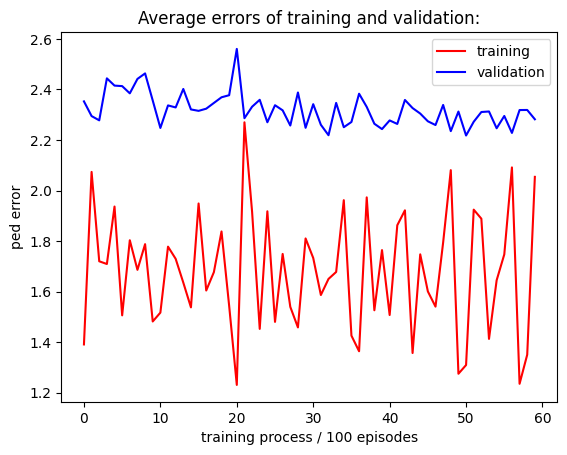

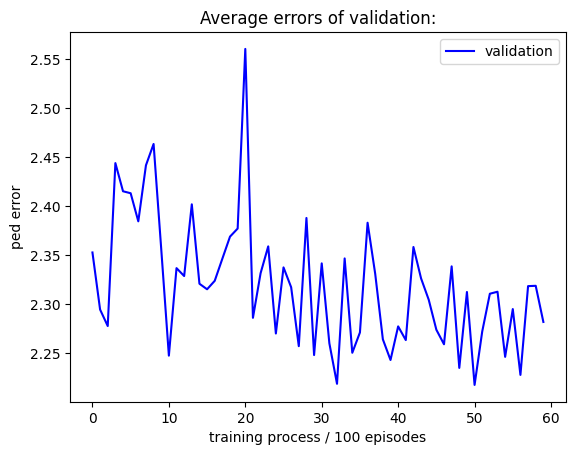

In [15]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.5, a_size=3, s_size=3, label='ped')

In [5]:
test_all(model_path='save/24.8409906915497_ratio_0.2_sed/', amount=100, ratio=0.2, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/24.8409906915497_ratio_0.2_sed/======'
======loading test data======
It cost 0.544262170791626s
training from last checkpoint save/24.8409906915497_ratio_0.2_sed/
INFO:tensorflow:Restoring parameters from save/24.8409906915497_ratio_0.2_sed/trained_model.ckpt
Effectiveness of different errors: sed:24.9403, ped:10.7595, dad:1.0803, sad:3.9382
Testing elapsed time = 16.4699s, 12.0137s, 12.4140s, 28.7071s
Effectiveness of different ratios: 0.1:77.1229, 0.2:25.0751, 0.3:13.9117, 0.4:8.5290, 0.5:5.3421
Testing elapsed time = 17.6690s, 16.5576s, 15.0470s, 13.3437s, 11.7098s


In [6]:
test_all(model_path='save/13.382517849119244_ratio_0.3_sed/', amount=100, ratio=0.3, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/13.382517849119244_ratio_0.3_sed/======'
======loading test data======
It cost 0.4889109134674072s
training from last checkpoint save/13.382517849119244_ratio_0.3_sed/
INFO:tensorflow:Restoring parameters from save/13.382517849119244_ratio_0.3_sed/trained_model.ckpt
Effectiveness of different errors: sed:13.9573, ped:4.9904, dad:0.6238, sad:2.5694
Testing elapsed time = 15.7548s, 11.1567s, 12.2318s, 27.1464s
Effectiveness of different ratios: 0.1:73.2764, 0.2:25.9227, 0.3:14.6211, 0.4:8.0979, 0.5:5.4277
Testing elapsed time = 17.9346s, 16.7064s, 15.9804s, 13.9595s, 11.8265s


In [7]:
test_all(model_path='save/8.213566454124894_ratio_0.4_sed/', amount=100, ratio=0.4, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/8.213566454124894_ratio_0.4_sed/======'
======loading test data======
It cost 0.4982895851135254s
training from last checkpoint save/8.213566454124894_ratio_0.4_sed/
INFO:tensorflow:Restoring parameters from save/8.213566454124894_ratio_0.4_sed/trained_model.ckpt
Effectiveness of different errors: sed:8.3524, ped:3.0794, dad:0.3966, sad:1.9301
Testing elapsed time = 14.5401s, 10.6815s, 10.9589s, 24.4695s
Effectiveness of different ratios: 0.1:79.7847, 0.2:27.5584, 0.3:14.1199, 0.4:8.7534, 0.5:5.5741
Testing elapsed time = 18.2642s, 16.4625s, 15.7418s, 13.3679s, 11.7227s


In [8]:
test_all(model_path='save/5.413340064055946_ratio_0.5_sed/', amount=100, ratio=0.5, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/5.413340064055946_ratio_0.5_sed/======'
======loading test data======
It cost 0.44450998306274414s
training from last checkpoint save/5.413340064055946_ratio_0.5_sed/
INFO:tensorflow:Restoring parameters from save/5.413340064055946_ratio_0.5_sed/trained_model.ckpt
Effectiveness of different errors: sed:5.4073, ped:1.8957, dad:0.2766, sad:1.4053
Testing elapsed time = 11.9099s, 8.4014s, 8.8047s, 21.3259s
Effectiveness of different ratios: 0.1:85.6183, 0.2:26.2848, 0.3:13.9729, 0.4:8.6028, 0.5:5.3987
Testing elapsed time = 17.6608s, 16.4643s, 15.2326s, 13.3825s, 11.7371s


In [8]:
test_all(model_path='save/83.20056183876117_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/83.20056183876117_ratio_0.1_sed/======'
======loading test data======
It cost 4.325977325439453s
training from last checkpoint save/83.20056183876117_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/83.20056183876117_ratio_0.1_sed/trained_model.ckpt
Effectiveness of different errors: sed:80.0749, ped:29.2221, dad:1.9972, sad:6.9654
Testing elapsed time = 18.3588s, 13.3671s, 13.8546s, 31.7478s
Effectiveness of different ratios: 0.1:80.3711, 0.2:25.7545, 0.3:13.7866, 0.4:8.8267, 0.5:5.5260
Testing elapsed time = 18.8038s, 16.8965s, 15.7615s, 13.6733s, 12.1411s


In [10]:
test_all(model_path='save/36.10096245802341_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/36.10096245802341_ratio_0.1_ped/======'
======loading test data======
It cost 0.46161580085754395s
training from last checkpoint save/36.10096245802341_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/36.10096245802341_ratio_0.1_ped/trained_model.ckpt
Effectiveness of different errors: sed:68.5185, ped:30.5300, dad:1.9570, sad:7.1681
Testing elapsed time = 18.6801s, 13.6711s, 14.0845s, 33.2139s
Effectiveness of different ratios: 0.1:29.2828, 0.2:11.0625, 0.3:5.1370, 0.4:3.1127, 0.5:1.9065
Testing elapsed time = 14.4837s, 12.6192s, 10.9835s, 9.7536s, 8.8061s


In [5]:
test_all(model_path='save_old5/1.6422185233413111_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save_old5/1.6422185233413111_ratio_0.1_dad/======'
======loading test data======
It cost 2.974540948867798s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_old5/1.6422185233413111_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_old5/1.6422185233413111_ratio_0.1_dad/trained_model.ckpt
Effectiveness of different errors: sed:85.7611, ped:29.0606, dad:1.9819, sad:7.4969
Testing elapsed time = 18.7755s, 13.4862s, 14.2616s, 32.4824s
Effectiveness of different ratios: 0.1:1.9690, 0.2:1.0871, 0.3:0.6332, 0.4:0.3907, 0.5:0.2769
Testing elapsed time = 14.3456s, 13.5378s, 12.3015s, 10.5718s, 9.5978s


In [6]:
test_all(model_path='save/6.12439007436741_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.12439007436741_ratio_0.1_sad/======'
======loading test data======
It cost 0.48615503311157227s
training from last checkpoint save/6.12439007436741_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.12439007436741_ratio_0.1_sad/trained_model.ckpt
Effectiveness of different errors: sed:111.1165, ped:35.7308, dad:1.9573, sad:6.9955
Testing elapsed time = 18.6342s, 13.8971s, 13.8057s, 31.7379s
Effectiveness of different ratios: 0.1:7.0361, 0.2:3.7995, 0.3:2.5183, 0.4:1.9008, 0.5:1.4015
Testing elapsed time = 32.0074s, 30.1173s, 28.7565s, 26.1913s, 23.4506s


In [4]:
test_all(model_path='save_old5/35.82961256221557_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save_old5/35.82961256221557_ratio_0.1_ped/======'
======loading test data======
It cost 2.686147451400757s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_old5/35.82961256221557_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_old5/35.82961256221557_ratio_0.1_ped/trained_model.ckpt
Effectiveness of different errors: sed:87.8619, ped:27.8480, dad:1.9511, sad:6.8732
Testing elapsed time = 18.5781s, 14.1127s, 14.0682s, 32.1964s
Effectiveness of different ratios: 0.1:27.1655, 0.2:10.8918, 0.3:4.9758, 0.4:3.0877, 0.5:1.9408
Testing elapsed time = 13.1371s, 14.5533s, 11.5157s, 10.3801s, 9.1986s


In [7]:
test_all(model_path='save/79.8177000772866_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/79.8177000772866_ratio_0.1_sed/======'
======loading test data======
It cost 0.47617626190185547s
training from last checkpoint save/79.8177000772866_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/79.8177000772866_ratio_0.1_sed/trained_model.ckpt
Effectiveness of different errors: sed:67.0003, ped:31.2273, dad:1.9779, sad:7.0900
Testing elapsed time = 18.4741s, 13.2436s, 14.0570s, 31.8219s
Effectiveness of different ratios: 0.1:79.8036, 0.2:24.7884, 0.3:13.7080, 0.4:8.5259, 0.5:5.4232
Testing elapsed time = 18.1775s, 16.8521s, 15.3124s, 13.8463s, 11.8619s


In [4]:
test_err(model_path='save/83.20056183876117_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save/83.20056183876117_ratio_0.1_sed/======'
======loading test data======
It cost 2.4004862308502197s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save/83.20056183876117_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/83.20056183876117_ratio_0.1_sed/trained_model.ckpt
Effectiveness of different errors: sed:93.7641, ped:28.7042, dad:1.9521, sad:7.4499
Testing elapsed time = 37.7560s, 28.0666s, 28.4566s, 64.7992s
Effectiveness of different errors: sed:73.8693, ped:30.5025, dad:1.9242, sad:7.2497
Testing elapsed time = 37.5580s, 28.0455s, 29.9727s, 68.7401s
Effectiveness of different errors: sed:91.0022, ped:26.4354, dad:1.9582, sad:7.5848
Testing elapsed time = 37.5681s, 28.0091s, 26.8889s, 65.1439s


In [6]:
test_err(model_path='save/36.10096245802341_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save/36.10096245802341_ratio_0.1_ped/======'
======loading test data======
It cost 2.3955254554748535s
training from last checkpoint save/36.10096245802341_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/36.10096245802341_ratio_0.1_ped/trained_model.ckpt
Effectiveness of different errors: sed:73.4816, ped:27.7109, dad:1.9755, sad:7.6736
Testing elapsed time = 34.9645s, 27.0705s, 28.1727s, 64.8853s
Effectiveness of different errors: sed:72.4507, ped:28.9065, dad:1.9996, sad:7.4496
Testing elapsed time = 37.3756s, 25.9650s, 29.7257s, 68.4312s
Effectiveness of different errors: sed:74.9978, ped:31.0273, dad:1.9595, sad:7.5803
Testing elapsed time = 37.1928s, 29.1670s, 30.7206s, 60.3224s


In [9]:
test_err(model_path='save_old5/1.6422185233413111_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save_old5/1.6422185233413111_ratio_0.1_dad/======'
======loading test data======
It cost 0.7313668727874756s
training from last checkpoint save_old5/1.6422185233413111_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_old5/1.6422185233413111_ratio_0.1_dad/trained_model.ckpt
Effectiveness of different errors: sed:83.6541, ped:32.2526, dad:1.9538, sad:7.5549
Testing elapsed time = 27.4704s, 19.1891s, 20.6468s, 45.4485s
Effectiveness of different errors: sed:79.3464, ped:36.5731, dad:1.9590, sad:7.4510
Testing elapsed time = 25.6402s, 20.0328s, 21.1212s, 48.2378s
Effectiveness of different errors: sed:78.7380, ped:32.2252, dad:1.9907, sad:7.5557
Testing elapsed time = 27.0193s, 20.0717s, 19.8940s, 47.9747s


In [10]:
test_err(model_path='save/6.12439007436741_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save/6.12439007436741_ratio_0.1_sad/======'
======loading test data======
It cost 0.6813957691192627s
training from last checkpoint save/6.12439007436741_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.12439007436741_ratio_0.1_sad/trained_model.ckpt
Effectiveness of different errors: sed:112.0747, ped:35.6989, dad:1.9493, sad:6.9093
Testing elapsed time = 26.9367s, 19.5327s, 20.5570s, 47.7069s
Effectiveness of different errors: sed:112.2572, ped:35.5390, dad:1.9403, sad:7.0204
Testing elapsed time = 25.9034s, 19.4342s, 20.2388s, 45.1979s
Effectiveness of different errors: sed:108.7309, ped:34.8582, dad:1.9641, sad:6.9739
Testing elapsed time = 26.2656s, 19.6186s, 21.6462s, 47.5244s


## retrain

======loading train data======
It cost 10.029795169830322s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_old5/35.82961256221557_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_old5/35.82961256221557_ratio_0.1_ped/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 0 episode 100: Training error: 68.21477177182105, Validation error: 88.3264133865265
Save model with error 88.3264133865265
==>current best model is 88.3264133865265 with ratio 0.1
It costs 216.5100486278534s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 0 episode 200: Training error: 94.6257292344707, Validation error: 84.26456983489979
Save model with error 84.26456983489979
==>current best model is 84.26456983489979 with ratio 0.1
It costs 212.83239889144897s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 1 episode 100: Training error: 96.29360500865708, Validation error: 89.70809186251547
==>current best model is 84.26456983489979 with ratio 0.1
It costs 203.73992896080017s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 1 episode 200: Training error: 61.12851109711739, Validation error: 81.85511814993043
Save model with error 81.85511814993043
==>current best model is 81.85511814993043 with ratio 0.1
It costs 227.08819913864136s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 2 episode 100: Training error: 42.21188187257258, Validation error: 94.57020583764243
==>current best model is 81.85511814993043 with ratio 0.1
It costs 225.28682255744934s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 2 episode 200: Training error: 123.68243455164946, Validation error: 87.57369019210189
==>current best model is 81.85511814993043 with ratio 0.1
It costs 227.1858139038086s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 3 episode 100: Training error: 68.37367163074735, Validation error: 89.03225285336516
==>current best model is 81.85511814993043 with ratio 0.1
It costs 207.3126974105835s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 3 episode 200: Training error: 94.94994765303294, Validation error: 90.76178887516583
==>current best model is 81.85511814993043 with ratio 0.1
It costs 242.5040099620819s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


round 4 episode 100: Training error: 78.14894884642995, Validation error: 84.83767600879578
==>current best model is 81.85511814993043 with ratio 0.1
It costs 226.34379506111145s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 4 episode 200: Training error: 87.16651807933869, Validation error: 86.72285472420556
==>current best model is 81.85511814993043 with ratio 0.1
It costs 210.7061731815338s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 5 episode 100: Training error: 59.931787371221986, Validation error: 86.86667394909414
==>current best model is 81.85511814993043 with ratio 0.1
It costs 235.24555158615112s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 5 episode 200: Training error: 99.87388161617008, Validation error: 93.21821424677802
==>current best model is 81.85511814993043 with ratio 0.1
It costs 201.74180960655212s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 6 episode 100: Training error: 94.16888284367892, Validation error: 89.56759361930975
==>current best model is 81.85511814993043 with ratio 0.1
It costs 225.82600212097168s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 6 episode 200: Training error: 69.57465465506537, Validation error: 86.29640220529556
==>current best model is 81.85511814993043 with ratio 0.1
It costs 235.23809432983398s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 7 episode 100: Training error: 72.57547865526813, Validation error: 85.96877689325328
==>current best model is 81.85511814993043 with ratio 0.1
It costs 224.22060251235962s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 7 episode 200: Training error: 83.18993121409899, Validation error: 82.59748501052904
==>current best model is 81.85511814993043 with ratio 0.1
It costs 202.34380769729614s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 8 episode 100: Training error: 80.39370134956012, Validation error: 79.8177000772866
Save model with error 79.8177000772866
==>current best model is 79.8177000772866 with ratio 0.1
It costs 226.6674587726593s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 8 episode 200: Training error: 72.06347066331193, Validation error: 86.81430897170709
==>current best model is 79.8177000772866 with ratio 0.1
It costs 262.47961378097534s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


round 9 episode 100: Training error: 103.89388683301095, Validation error: 87.65838092422271
==>current best model is 79.8177000772866 with ratio 0.1
It costs 264.2556416988373s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 9 episode 200: Training error: 62.46394471673306, Validation error: 86.55317215032049
==>current best model is 79.8177000772866 with ratio 0.1
It costs 203.94794940948486s
Training elapsed time = %s 4481.478615283966


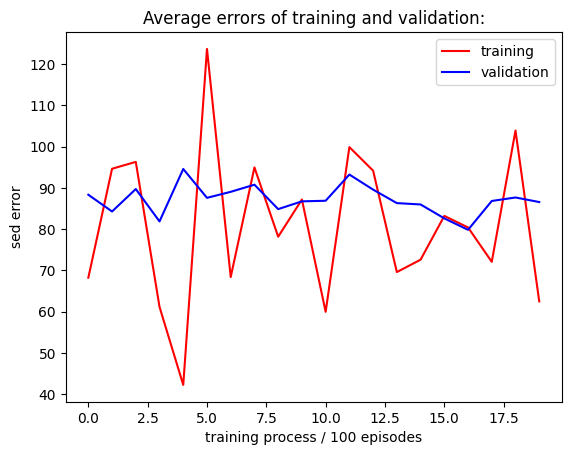

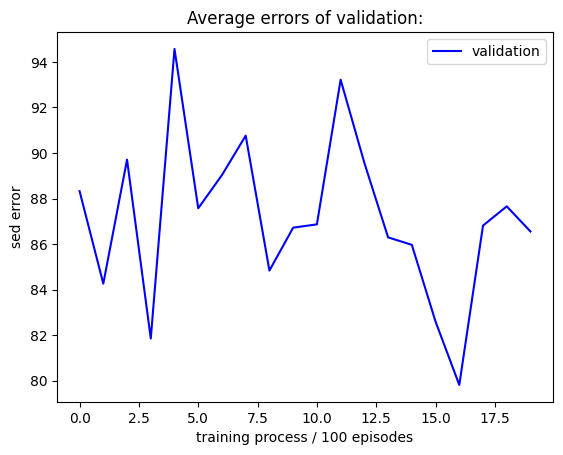

In [4]:
retrain(model_path='save_old5/35.82961256221557_ratio_0.1_ped/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed')

In [11]:
test_err(model_path='save_old5/35.82961256221557_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save_old5/35.82961256221557_ratio_0.1_ped/======'
======loading test data======
It cost 0.7015459537506104s
training from last checkpoint save_old5/35.82961256221557_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_old5/35.82961256221557_ratio_0.1_ped/trained_model.ckpt
Effectiveness of different errors: sed:86.3405, ped:26.4681, dad:1.9785, sad:7.1386
Testing elapsed time = 36.4423s, 28.1163s, 27.5501s, 68.8330s
Effectiveness of different errors: sed:68.2785, ped:26.0150, dad:1.9285, sad:6.9365
Testing elapsed time = 40.1964s, 28.7510s, 31.0120s, 53.8087s
Effectiveness of different errors: sed:85.5185, ped:32.4448, dad:1.9734, sad:7.4530
Testing elapsed time = 28.2304s, 20.6588s, 21.4585s, 52.8613s


In [12]:
test(model_path='save/79.8177000772866_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/79.8177000772866_ratio_0.1_sed/======'
======loading test data======
It cost 2.611631155014038s
training from last checkpoint save/79.8177000772866_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/79.8177000772866_ratio_0.1_sed/trained_model.ckpt
Effectiveness: 75.6410
Training elapsed time = 28.4068s
Effectiveness: 89.1171
Training elapsed time = 27.9524s
Effectiveness: 69.5629
Training elapsed time = 28.7837s


======loading train data======
It cost 6.346423864364624s.
training from last checkpoint save_old5/35.82961256221557_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_old5/35.82961256221557_ratio_0.1_ped/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


round 0 episode 100: Training error: 1.7579264869146873, Validation error: 1.6470808946575308
Save model with error 1.6470808946575308
==>current best model is 1.6470808946575308 with ratio 0.1
It costs 359.9305808544159s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.93s/it]


round 0 episode 200: Training error: 1.8639406302114645, Validation error: 1.719016342651513
==>current best model is 1.6470808946575308 with ratio 0.1
It costs 400.3098487854004s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:04<00:00,  2.44s/it]


round 1 episode 100: Training error: 1.789031672522232, Validation error: 1.705742750855521
==>current best model is 1.6470808946575308 with ratio 0.1
It costs 452.40189146995544s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:19<00:00,  1.99s/it]


round 1 episode 200: Training error: 1.864302555052978, Validation error: 1.6683568268404938
==>current best model is 1.6470808946575308 with ratio 0.1
It costs 332.4619619846344s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


round 2 episode 100: Training error: 1.8360721044824617, Validation error: 1.6645989328807245
==>current best model is 1.6470808946575308 with ratio 0.1
It costs 273.1142055988312s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 2 episode 200: Training error: 1.7722696109791243, Validation error: 1.6833277471965093
==>current best model is 1.6470808946575308 with ratio 0.1
It costs 229.83785676956177s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 3 episode 100: Training error: 1.722854710532861, Validation error: 1.6396551856796848
Save model with error 1.6396551856796848
==>current best model is 1.6396551856796848 with ratio 0.1
It costs 248.54399800300598s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 3 episode 200: Training error: 1.8916136025409898, Validation error: 1.6380216280155655
Save model with error 1.6380216280155655
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 253.8606517314911s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 4 episode 100: Training error: 1.7713852535857486, Validation error: 1.6730519359352585
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 265.1159427165985s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 4 episode 200: Training error: 1.8490267500652784, Validation error: 1.6902402197433928
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 244.8581187725067s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 5 episode 100: Training error: 1.794383672705759, Validation error: 1.6943699005828776
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 213.68035912513733s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


round 5 episode 200: Training error: 1.8385902677334947, Validation error: 1.6886677971425972
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 289.69247460365295s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 6 episode 100: Training error: 1.786900796987363, Validation error: 1.69162696793531
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 252.4836163520813s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 6 episode 200: Training error: 1.8404427584360314, Validation error: 1.6497276767746203
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 244.00610542297363s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 7 episode 100: Training error: 1.8223950377703142, Validation error: 1.6889549849283219
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 233.5938265323639s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


round 7 episode 200: Training error: 1.8486988483219375, Validation error: 1.6472110538967257
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 290.17954540252686s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 8 episode 100: Training error: 1.8888138372119474, Validation error: 1.676258791202527
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 248.2519850730896s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


round 8 episode 200: Training error: 1.7343381248994814, Validation error: 1.6713478411174532
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 275.4846007823944s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 9 episode 100: Training error: 1.7227332281709258, Validation error: 1.666481816613382
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 257.91629004478455s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 9 episode 200: Training error: 1.9161068706149258, Validation error: 1.6622025800887597
==>current best model is 1.6380216280155655 with ratio 0.1
It costs 265.84622716903687s
Training elapsed time = %s 5631.575702905655


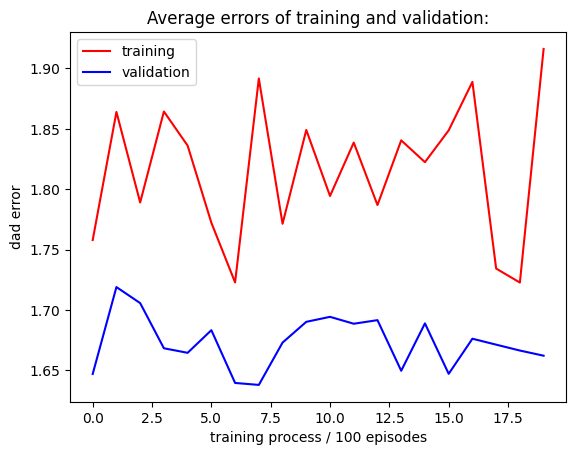

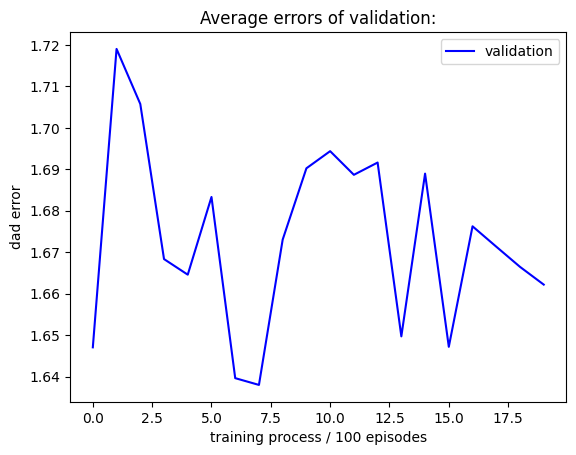

In [13]:
retrain(model_path='save_old5/35.82961256221557_ratio_0.1_ped/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='dad')

In [7]:
test(model_path='save/1.6380216280155655_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.6380216280155655_ratio_0.1_dad/======'
======loading test data======
It cost 0.5131077766418457s
training from last checkpoint save/1.6380216280155655_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6380216280155655_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.9590
Training elapsed time = 20.5860s
Effectiveness: 1.9351
Training elapsed time = 21.2918s
Effectiveness: 1.9645
Training elapsed time = 21.3479s


In [6]:
test(model_path='save_old5/35.82961256221557_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save_old5/35.82961256221557_ratio_0.1_ped/======'
======loading test data======
It cost 3.51224946975708s
training from last checkpoint save_old5/35.82961256221557_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_old5/35.82961256221557_ratio_0.1_ped/trained_model.ckpt
Effectiveness: 1.9463
Training elapsed time = 21.3084s
Effectiveness: 1.9627
Training elapsed time = 21.5095s
Effectiveness: 1.9610
Training elapsed time = 20.4375s


======loading train data======
It cost 10.06890058517456s.
training from last checkpoint save_old5/35.82961256221557_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_old5/35.82961256221557_ratio_0.1_ped/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.92s/it]


round 0 episode 100: Training error: 7.292601808393187, Validation error: 6.376392233106469
Save model with error 6.376392233106469
==>current best model is 6.376392233106469 with ratio 0.1
It costs 344.9624500274658s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:00<00:00,  1.80s/it]


round 0 episode 200: Training error: 6.742498918332254, Validation error: 6.388703068481085
==>current best model is 6.376392233106469 with ratio 0.1
It costs 353.691130399704s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]


round 1 episode 100: Training error: 6.8446771470409935, Validation error: 7.43691331106392
==>current best model is 6.376392233106469 with ratio 0.1
It costs 353.80244970321655s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.36s/it]


round 1 episode 200: Training error: 6.862189845131784, Validation error: 6.49884737886614
==>current best model is 6.376392233106469 with ratio 0.1
It costs 408.89593267440796s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.34s/it]


round 2 episode 100: Training error: 6.265655678123146, Validation error: 6.2113499242095305
Save model with error 6.2113499242095305
==>current best model is 6.2113499242095305 with ratio 0.1
It costs 406.81487703323364s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


round 2 episode 200: Training error: 7.389046020695824, Validation error: 6.181787130575492
Save model with error 6.181787130575492
==>current best model is 6.181787130575492 with ratio 0.1
It costs 358.93416142463684s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


round 3 episode 100: Training error: 7.121615005132201, Validation error: 6.324991487544722
==>current best model is 6.181787130575492 with ratio 0.1
It costs 386.3754105567932s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:26<00:00,  2.07s/it]


round 3 episode 200: Training error: 6.32602920975955, Validation error: 6.419933650045973
==>current best model is 6.181787130575492 with ratio 0.1
It costs 379.49004650115967s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:26<00:00,  2.06s/it]


round 4 episode 100: Training error: 7.3270015875974925, Validation error: 6.13805436656412
Save model with error 6.13805436656412
==>current best model is 6.13805436656412 with ratio 0.1
It costs 379.3385126590729s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


round 4 episode 200: Training error: 6.368149889400025, Validation error: 6.270436563610884
==>current best model is 6.13805436656412 with ratio 0.1
It costs 384.7531771659851s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]


round 5 episode 100: Training error: 6.893947714906753, Validation error: 6.114745928476241
Save model with error 6.114745928476241
==>current best model is 6.114745928476241 with ratio 0.1
It costs 388.4029133319855s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:26<00:00,  2.06s/it]


round 5 episode 200: Training error: 6.682297117316713, Validation error: 6.336872980869964
==>current best model is 6.114745928476241 with ratio 0.1
It costs 377.31151008605957s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:19<00:00,  2.00s/it]


round 6 episode 100: Training error: 7.366868374651187, Validation error: 6.11045834649941
Save model with error 6.11045834649941
==>current best model is 6.11045834649941 with ratio 0.1
It costs 371.9300100803375s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.20s/it]


round 6 episode 200: Training error: 6.247857537442128, Validation error: 6.202221894393496
==>current best model is 6.11045834649941 with ratio 0.1
It costs 391.65546107292175s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]


round 7 episode 100: Training error: 7.0440893511396645, Validation error: 6.2434199366129315
==>current best model is 6.11045834649941 with ratio 0.1
It costs 386.7175328731537s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.06s/it]


round 7 episode 200: Training error: 6.8104749110032845, Validation error: 6.187186513914217
==>current best model is 6.11045834649941 with ratio 0.1
It costs 375.72277188301086s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.06s/it]


round 8 episode 100: Training error: 7.062749707490542, Validation error: 6.157051796498928
==>current best model is 6.11045834649941 with ratio 0.1
It costs 376.1566846370697s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:36<00:00,  2.16s/it]


round 8 episode 200: Training error: 6.708605810452567, Validation error: 6.270003428350613
==>current best model is 6.11045834649941 with ratio 0.1
It costs 388.7721583843231s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.92s/it]


round 9 episode 100: Training error: 6.847362755182027, Validation error: 6.339861865697826
==>current best model is 6.11045834649941 with ratio 0.1
It costs 366.05400133132935s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.30s/it]


round 9 episode 200: Training error: 6.738085863012892, Validation error: 6.080899695466665
Save model with error 6.080899695466665
==>current best model is 6.080899695466665 with ratio 0.1
It costs 400.6254804134369s
Training elapsed time = %s 7580.4085993766785


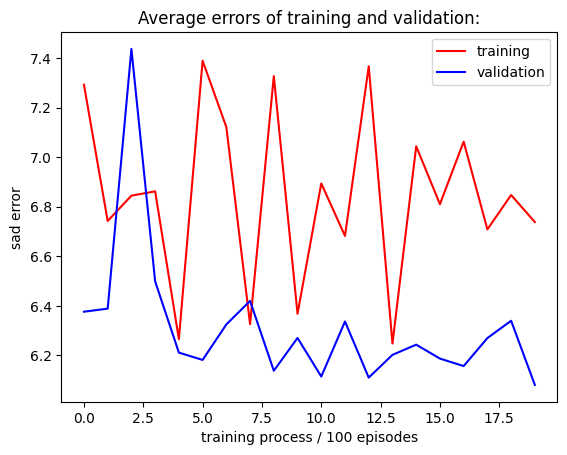

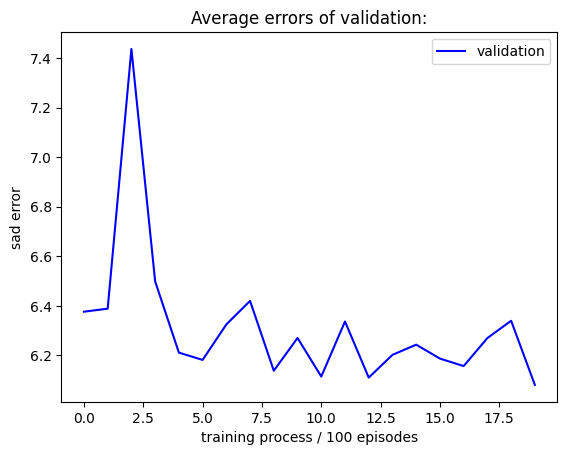

In [8]:
retrain(model_path='save_old5/35.82961256221557_ratio_0.1_ped/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sad')

In [9]:
test(model_path='save/6.080899695466665_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.080899695466665_ratio_0.1_sad/======'
======loading test data======
It cost 3.179365873336792s
training from last checkpoint save/6.080899695466665_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.080899695466665_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 6.8999
Training elapsed time = 70.6672s
Effectiveness: 6.9005
Training elapsed time = 68.1244s
Effectiveness: 7.0235
Training elapsed time = 62.1056s


======loading train data======
It cost 6.198050260543823s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 0 episode 100: Training error: 94.05925588589851, Validation error: 132.17023467180516
Save model with error 132.17023467180516
==>current best model is 132.17023467180516 with ratio 0.1
It costs 289.12691497802734s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 0 episode 200: Training error: 119.11340122705076, Validation error: 128.13312046645967
Save model with error 128.13312046645967
==>current best model is 128.13312046645967 with ratio 0.1
It costs 292.13279485702515s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 1 episode 100: Training error: 62.904317112079426, Validation error: 115.121892834216
Save model with error 115.121892834216
==>current best model is 115.121892834216 with ratio 0.1
It costs 285.56762528419495s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


round 1 episode 200: Training error: 139.07199852275082, Validation error: 103.29071213164697
Save model with error 103.29071213164697
==>current best model is 103.29071213164697 with ratio 0.1
It costs 293.3019163608551s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


round 2 episode 100: Training error: 88.79744328970396, Validation error: 113.34360468530839
==>current best model is 103.29071213164697 with ratio 0.1
It costs 303.49650979042053s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 2 episode 200: Training error: 101.12913596523586, Validation error: 109.82547980441925
==>current best model is 103.29071213164697 with ratio 0.1
It costs 266.9190454483032s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


round 3 episode 100: Training error: 114.79188279973577, Validation error: 103.24468602247653
Save model with error 103.24468602247653
==>current best model is 103.24468602247653 with ratio 0.1
It costs 308.65869522094727s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 3 episode 200: Training error: 66.70841497469557, Validation error: 105.43921097707842
==>current best model is 103.24468602247653 with ratio 0.1
It costs 272.97856307029724s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 4 episode 100: Training error: 97.62661003966467, Validation error: 111.25264655576783
==>current best model is 103.24468602247653 with ratio 0.1
It costs 301.8011300563812s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.92s/it]


round 4 episode 200: Training error: 82.58551092471802, Validation error: 101.31701933033182
Save model with error 101.31701933033182
==>current best model is 101.31701933033182 with ratio 0.1
It costs 339.646226644516s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


round 5 episode 100: Training error: 84.91626978325668, Validation error: 93.19415307831358
Save model with error 93.19415307831358
==>current best model is 93.19415307831358 with ratio 0.1
It costs 294.70815920829773s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


round 5 episode 200: Training error: 94.93397271464545, Validation error: 106.26000212893612
==>current best model is 93.19415307831358 with ratio 0.1
It costs 321.36479115486145s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


round 6 episode 100: Training error: 114.53696196946912, Validation error: 111.46652196750686
==>current best model is 93.19415307831358 with ratio 0.1
It costs 296.8861346244812s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


round 6 episode 200: Training error: 64.05831958699558, Validation error: 107.99026520313015
==>current best model is 93.19415307831358 with ratio 0.1
It costs 310.8039574623108s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


round 7 episode 100: Training error: 114.19051958786886, Validation error: 99.878683345287
==>current best model is 93.19415307831358 with ratio 0.1
It costs 410.5971460342407s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.42s/it]


round 7 episode 200: Training error: 67.10473033735761, Validation error: 102.67387196708941
==>current best model is 93.19415307831358 with ratio 0.1
It costs 393.0998725891113s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


round 8 episode 100: Training error: 87.5420939837518, Validation error: 98.34159115111993
==>current best model is 93.19415307831358 with ratio 0.1
It costs 298.64980149269104s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.87s/it]


round 8 episode 200: Training error: 93.17497591710539, Validation error: 98.5384213312672
==>current best model is 93.19415307831358 with ratio 0.1
It costs 339.80482816696167s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.91s/it]


round 9 episode 100: Training error: 102.54458612123993, Validation error: 92.34788940101572
Save model with error 92.34788940101572
==>current best model is 92.34788940101572 with ratio 0.1
It costs 344.947384595871s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


round 9 episode 200: Training error: 63.18564010178995, Validation error: 96.03998757172059
==>current best model is 92.34788940101572 with ratio 0.1
It costs 304.1530702114105s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


round 10 episode 100: Training error: 91.34856468239772, Validation error: 95.23217923278412
==>current best model is 92.34788940101572 with ratio 0.1
It costs 329.4542124271393s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


round 10 episode 200: Training error: 76.38435825666232, Validation error: 93.69376439081702
==>current best model is 92.34788940101572 with ratio 0.1
It costs 321.0486271381378s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.98s/it]


round 11 episode 100: Training error: 76.48693640957825, Validation error: 90.81634296058644
Save model with error 90.81634296058644
==>current best model is 90.81634296058644 with ratio 0.1
It costs 353.7767765522003s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


round 11 episode 200: Training error: 90.78191636840462, Validation error: 94.60261521693356
==>current best model is 90.81634296058644 with ratio 0.1
It costs 294.9655306339264s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


round 12 episode 100: Training error: 94.9684978681647, Validation error: 87.81775458663083
Save model with error 87.81775458663083
==>current best model is 87.81775458663083 with ratio 0.1
It costs 314.0097653865814s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


round 12 episode 200: Training error: 80.50341125342166, Validation error: 94.72228695958003
==>current best model is 87.81775458663083 with ratio 0.1
It costs 293.5682153701782s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


round 13 episode 100: Training error: 112.87007884633442, Validation error: 88.31481187283333
==>current best model is 87.81775458663083 with ratio 0.1
It costs 278.52928614616394s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.75s/it]


round 13 episode 200: Training error: 63.14489220043999, Validation error: 96.67461203306026
==>current best model is 87.81775458663083 with ratio 0.1
It costs 322.30219292640686s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 14 episode 100: Training error: 106.59680640728018, Validation error: 83.05787933483077
Save model with error 83.05787933483077
==>current best model is 83.05787933483077 with ratio 0.1
It costs 260.05671215057373s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


round 14 episode 200: Training error: 59.42871026184156, Validation error: 89.65039182393551
==>current best model is 83.05787933483077 with ratio 0.1
It costs 309.10149478912354s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.93s/it]


round 15 episode 100: Training error: 92.06844021901401, Validation error: 90.01584346027596
==>current best model is 83.05787933483077 with ratio 0.1
It costs 371.83334493637085s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.90s/it]


round 15 episode 200: Training error: 80.54997476769114, Validation error: 89.23415231313395
==>current best model is 83.05787933483077 with ratio 0.1
It costs 336.6057376861572s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 16 episode 100: Training error: 93.2928497316136, Validation error: 90.88149155349475
==>current best model is 83.05787933483077 with ratio 0.1
It costs 267.4519410133362s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 16 episode 200: Training error: 80.40093072841904, Validation error: 89.58816451982186
==>current best model is 83.05787933483077 with ratio 0.1
It costs 299.18991327285767s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


round 17 episode 100: Training error: 60.302725705557414, Validation error: 91.99645096063448
==>current best model is 83.05787933483077 with ratio 0.1
It costs 276.4319009780884s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


round 17 episode 200: Training error: 104.50635417003112, Validation error: 90.73531066649502
==>current best model is 83.05787933483077 with ratio 0.1
It costs 312.8323931694031s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 18 episode 100: Training error: 94.47078324548846, Validation error: 84.38715021494127
==>current best model is 83.05787933483077 with ratio 0.1
It costs 274.568076133728s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.94s/it]


round 18 episode 200: Training error: 68.61184251648012, Validation error: 90.07013589359113
==>current best model is 83.05787933483077 with ratio 0.1
It costs 343.0297667980194s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


round 19 episode 100: Training error: 95.7643127302621, Validation error: 90.98743130955953
==>current best model is 83.05787933483077 with ratio 0.1
It costs 302.44624185562134s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.73s/it]


round 19 episode 200: Training error: 71.22939335330766, Validation error: 85.68055130337605
==>current best model is 83.05787933483077 with ratio 0.1
It costs 319.37473034858704s
Training elapsed time = %s 12449.225189685822


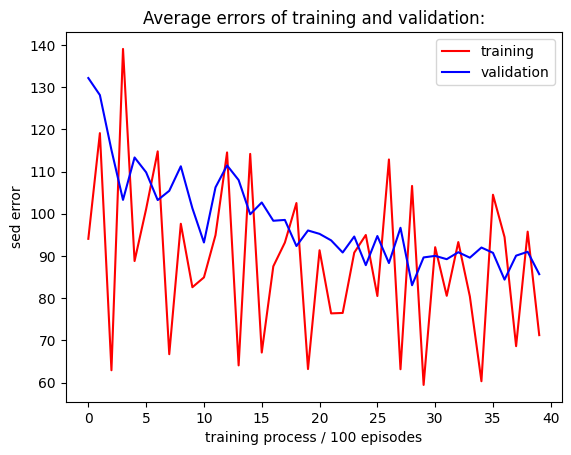

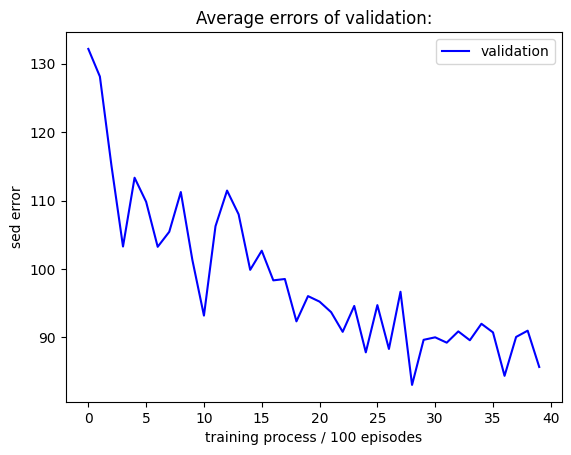

In [10]:
train(traj_amount=200, valid_amount=70, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed')

In [11]:
test_err(model_path='save/83.05787933483077_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save/83.05787933483077_ratio_0.1_sed/======'
======loading test data======
It cost 3.260205030441284s
training from last checkpoint save/83.05787933483077_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/83.05787933483077_ratio_0.1_sed/trained_model.ckpt
Effectiveness of different errors: sed:73.3896, ped:27.7791, dad:1.9952, sad:7.4947
Testing elapsed time = 38.7421s, 27.1158s, 29.3577s, 67.5273s
Effectiveness of different errors: sed:83.3770, ped:30.7657, dad:1.9407, sad:7.6938
Testing elapsed time = 39.0136s, 28.9448s, 28.7000s, 66.0154s
Effectiveness of different errors: sed:83.8502, ped:30.9243, dad:1.9767, sad:7.6493
Testing elapsed time = 37.6741s, 28.4409s, 29.3314s, 67.2817s


======loading train data======
It cost 6.413824796676636s.
training from last checkpoint save/83.05787933483077_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/83.05787933483077_ratio_0.1_sed/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 0 episode 100: Training error: 31.496217641690933, Validation error: 50.41057016778054
Save model with error 50.41057016778054
==>current best model is 50.41057016778054 with ratio 0.1
It costs 231.47627878189087s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


round 0 episode 200: Training error: 48.70958044212148, Validation error: 38.9846289584645
Save model with error 38.9846289584645
==>current best model is 38.9846289584645 with ratio 0.1
It costs 273.11389088630676s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 1 episode 100: Training error: 32.011006206773416, Validation error: 51.88600669109938
==>current best model is 38.9846289584645 with ratio 0.1
It costs 249.257009267807s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 1 episode 200: Training error: 33.035398698245416, Validation error: 42.07822177853083
==>current best model is 38.9846289584645 with ratio 0.1
It costs 257.649405002594s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


round 2 episode 100: Training error: 36.568435560826366, Validation error: 40.215490886306235
==>current best model is 38.9846289584645 with ratio 0.1
It costs 240.11228322982788s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


round 2 episode 200: Training error: 26.710843669433153, Validation error: 49.302485239694185
==>current best model is 38.9846289584645 with ratio 0.1
It costs 290.33073115348816s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 3 episode 100: Training error: 29.2334428874899, Validation error: 49.93567101282084
==>current best model is 38.9846289584645 with ratio 0.1
It costs 267.3709707260132s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


round 3 episode 200: Training error: 39.404729581685814, Validation error: 47.251174288032516
==>current best model is 38.9846289584645 with ratio 0.1
It costs 290.3548672199249s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 4 episode 100: Training error: 28.182403431732936, Validation error: 52.59188723230769
==>current best model is 38.9846289584645 with ratio 0.1
It costs 267.83434081077576s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 4 episode 200: Training error: 26.873752713750594, Validation error: 39.98220970465447
==>current best model is 38.9846289584645 with ratio 0.1
It costs 294.6249694824219s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 5 episode 100: Training error: 32.54434576682764, Validation error: 40.927180540641665
==>current best model is 38.9846289584645 with ratio 0.1
It costs 294.4655017852783s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


round 5 episode 200: Training error: 25.550643072028052, Validation error: 42.925846455364265
==>current best model is 38.9846289584645 with ratio 0.1
It costs 270.21360301971436s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 6 episode 100: Training error: 36.54684428717185, Validation error: 39.84582282109708
==>current best model is 38.9846289584645 with ratio 0.1
It costs 266.5132737159729s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 6 episode 200: Training error: 33.17400232244824, Validation error: 48.29191683403419
==>current best model is 38.9846289584645 with ratio 0.1
It costs 296.8094596862793s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 7 episode 100: Training error: 35.34915246268672, Validation error: 45.94708264095355
==>current best model is 38.9846289584645 with ratio 0.1
It costs 266.8808960914612s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 7 episode 200: Training error: 29.664574981582795, Validation error: 49.53505655403618
==>current best model is 38.9846289584645 with ratio 0.1
It costs 295.5633547306061s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


round 8 episode 100: Training error: 36.29392490132327, Validation error: 42.14883462335722
==>current best model is 38.9846289584645 with ratio 0.1
It costs 306.07962465286255s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 8 episode 200: Training error: 23.51308124384459, Validation error: 47.751788396153195
==>current best model is 38.9846289584645 with ratio 0.1
It costs 259.4732143878937s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 9 episode 100: Training error: 20.97104580072749, Validation error: 46.80525392765064
==>current best model is 38.9846289584645 with ratio 0.1
It costs 272.533992767334s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


round 9 episode 200: Training error: 45.06701172702652, Validation error: 53.18312439277296
==>current best model is 38.9846289584645 with ratio 0.1
It costs 289.3667769432068s
Training elapsed time = %s 5480.025727987289


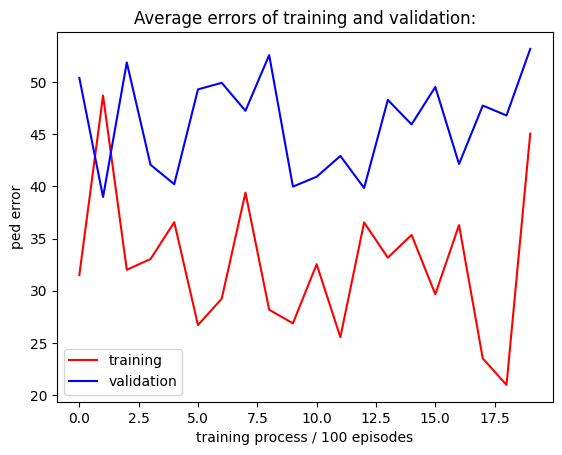

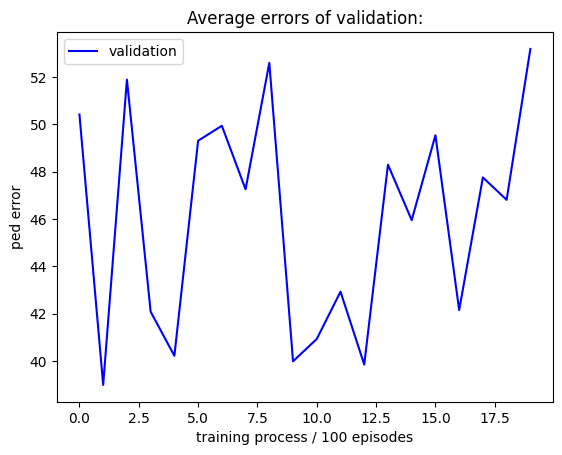

In [12]:
retrain(model_path='save/83.05787933483077_ratio_0.1_sed/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======loading train data======
It cost 6.271066188812256s.
training from last checkpoint save/83.05787933483077_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/83.05787933483077_ratio_0.1_sed/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 0 episode 100: Training error: 1.829163933545857, Validation error: 1.6923329022527167
Save model with error 1.6923329022527167
==>current best model is 1.6923329022527167 with ratio 0.1
It costs 275.26557517051697s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


round 0 episode 200: Training error: 1.843115533647505, Validation error: 1.6745212144667203
Save model with error 1.6745212144667203
==>current best model is 1.6745212144667203 with ratio 0.1
It costs 292.6960549354553s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 1 episode 100: Training error: 1.7927304737274015, Validation error: 1.6882904978155278
==>current best model is 1.6745212144667203 with ratio 0.1
It costs 282.5860662460327s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


round 1 episode 200: Training error: 1.8910177387475071, Validation error: 1.7107662701639939
==>current best model is 1.6745212144667203 with ratio 0.1
It costs 283.1386196613312s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


round 2 episode 100: Training error: 1.9152733056676339, Validation error: 1.684660711283382
==>current best model is 1.6745212144667203 with ratio 0.1
It costs 298.1961314678192s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


round 2 episode 200: Training error: 1.7567678000393077, Validation error: 1.692699169544337
==>current best model is 1.6745212144667203 with ratio 0.1
It costs 267.804306268692s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


round 3 episode 100: Training error: 1.807498631656743, Validation error: 1.678811889981211
==>current best model is 1.6745212144667203 with ratio 0.1
It costs 297.8472213745117s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 3 episode 200: Training error: 1.880823377715776, Validation error: 1.702139868197052
==>current best model is 1.6745212144667203 with ratio 0.1
It costs 265.6382489204407s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 4 episode 100: Training error: 1.817453982462047, Validation error: 1.660960871635673
Save model with error 1.660960871635673
==>current best model is 1.660960871635673 with ratio 0.1
It costs 283.82175183296204s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 4 episode 200: Training error: 1.8066478960408296, Validation error: 1.6969574632669404
==>current best model is 1.660960871635673 with ratio 0.1
It costs 281.9035165309906s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 5 episode 100: Training error: 1.7752106053285461, Validation error: 1.6774294927920466
==>current best model is 1.660960871635673 with ratio 0.1
It costs 271.2241802215576s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


round 5 episode 200: Training error: 1.8469122433849552, Validation error: 1.6766715551063198
==>current best model is 1.660960871635673 with ratio 0.1
It costs 295.35552763938904s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


round 6 episode 100: Training error: 1.8464412831094592, Validation error: 1.6701337028343395
==>current best model is 1.660960871635673 with ratio 0.1
It costs 281.355589389801s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 6 episode 200: Training error: 1.7687158080601966, Validation error: 1.6505469475463135
Save model with error 1.6505469475463135
==>current best model is 1.6505469475463135 with ratio 0.1
It costs 282.19355869293213s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 7 episode 100: Training error: 1.9003579700815159, Validation error: 1.6741752612615195
==>current best model is 1.6505469475463135 with ratio 0.1
It costs 255.06377792358398s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


round 7 episode 200: Training error: 1.7111172956567302, Validation error: 1.6598061133409683
==>current best model is 1.6505469475463135 with ratio 0.1
It costs 308.0741198062897s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 8 episode 100: Training error: 1.8598061674438966, Validation error: 1.6602395529615244
==>current best model is 1.6505469475463135 with ratio 0.1
It costs 278.5217912197113s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


round 8 episode 200: Training error: 1.7338990506160326, Validation error: 1.6616147960753425
==>current best model is 1.6505469475463135 with ratio 0.1
It costs 285.42274928092957s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


round 9 episode 100: Training error: 1.7128081209535782, Validation error: 1.6527480526708416
==>current best model is 1.6505469475463135 with ratio 0.1
It costs 279.1963710784912s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 9 episode 200: Training error: 1.8680963956976646, Validation error: 1.6437969868017062
Save model with error 1.6437969868017062
==>current best model is 1.6437969868017062 with ratio 0.1
It costs 285.5848240852356s
Training elapsed time = %s 5650.893000364304


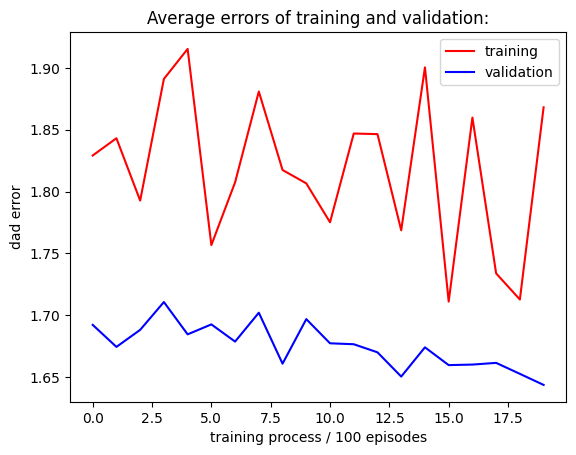

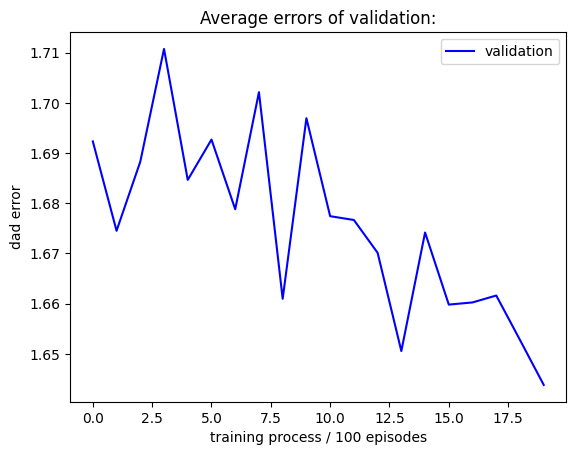

In [13]:
retrain(model_path='save/83.05787933483077_ratio_0.1_sed/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======loading train data======
It cost 6.231700658798218s.
training from last checkpoint save/83.05787933483077_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/83.05787933483077_ratio_0.1_sed/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/it]


round 0 episode 100: Training error: 8.223187080727614, Validation error: 7.561703533851232
Save model with error 7.561703533851232
==>current best model is 7.561703533851232 with ratio 0.1
It costs 374.76926350593567s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:28<00:00,  2.09s/it]


round 0 episode 200: Training error: 6.0172832736070525, Validation error: 7.396148576123905
Save model with error 7.396148576123905
==>current best model is 7.396148576123905 with ratio 0.1
It costs 379.90852546691895s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.24s/it]


round 1 episode 100: Training error: 6.888929780928555, Validation error: 7.508291073913638
==>current best model is 7.396148576123905 with ratio 0.1
It costs 394.3392457962036s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.88s/it]


round 1 episode 200: Training error: 7.454775664694374, Validation error: 7.4517323332141485
==>current best model is 7.396148576123905 with ratio 0.1
It costs 359.4314830303192s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.45s/it]


round 2 episode 100: Training error: 6.8906418921336465, Validation error: 7.278862506282754
Save model with error 7.278862506282754
==>current best model is 7.278862506282754 with ratio 0.1
It costs 416.20685338974s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


round 2 episode 200: Training error: 6.680656932541917, Validation error: 6.109135375523004
Save model with error 6.109135375523004
==>current best model is 6.109135375523004 with ratio 0.1
It costs 336.82837200164795s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.37s/it]


round 3 episode 100: Training error: 7.2209937422442545, Validation error: 7.370550900505497
==>current best model is 6.109135375523004 with ratio 0.1
It costs 406.8615891933441s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


round 3 episode 200: Training error: 6.477532923354795, Validation error: 6.3616253062415336
==>current best model is 6.109135375523004 with ratio 0.1
It costs 327.2062690258026s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


round 4 episode 100: Training error: 6.701087872428629, Validation error: 7.4799393218527115
==>current best model is 6.109135375523004 with ratio 0.1
It costs 471.4120759963989s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [06:04<00:00,  3.64s/it]


round 4 episode 200: Training error: 6.9337715639763395, Validation error: 7.512047174320805
==>current best model is 6.109135375523004 with ratio 0.1
It costs 612.3426380157471s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]


round 5 episode 100: Training error: 7.4106600140657894, Validation error: 6.307606996721182
==>current best model is 6.109135375523004 with ratio 0.1
It costs 336.85617184638977s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.87s/it]


round 5 episode 200: Training error: 6.593630937604283, Validation error: 7.478041724601144
==>current best model is 6.109135375523004 with ratio 0.1
It costs 337.2748830318451s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.93s/it]


round 6 episode 100: Training error: 6.68735930135495, Validation error: 7.462753810965194
==>current best model is 6.109135375523004 with ratio 0.1
It costs 352.06241059303284s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


round 6 episode 200: Training error: 6.849735169346319, Validation error: 7.505565931741675
==>current best model is 6.109135375523004 with ratio 0.1
It costs 345.43974471092224s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:14<00:00,  1.94s/it]


round 7 episode 100: Training error: 7.149861548778948, Validation error: 7.233745018059452
==>current best model is 6.109135375523004 with ratio 0.1
It costs 352.79121804237366s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:16<00:00,  1.96s/it]


round 7 episode 200: Training error: 6.406073427750905, Validation error: 6.229806139919008
==>current best model is 6.109135375523004 with ratio 0.1
It costs 354.6120636463165s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]


round 8 episode 100: Training error: 6.8192537679635645, Validation error: 6.042294094442626
Save model with error 6.042294094442626
==>current best model is 6.042294094442626 with ratio 0.1
It costs 352.6950509548187s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.98s/it]


round 8 episode 200: Training error: 6.710387504725644, Validation error: 6.1971219425899395
==>current best model is 6.042294094442626 with ratio 0.1
It costs 350.81533765792847s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


round 9 episode 100: Training error: 7.075077283235406, Validation error: 6.258658619681085
==>current best model is 6.042294094442626 with ratio 0.1
It costs 316.15552830696106s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.01s/it]


round 9 episode 200: Training error: 6.563151195114493, Validation error: 6.3737750447062345
==>current best model is 6.042294094442626 with ratio 0.1
It costs 351.3457992076874s
Training elapsed time = %s 7529.357381343842


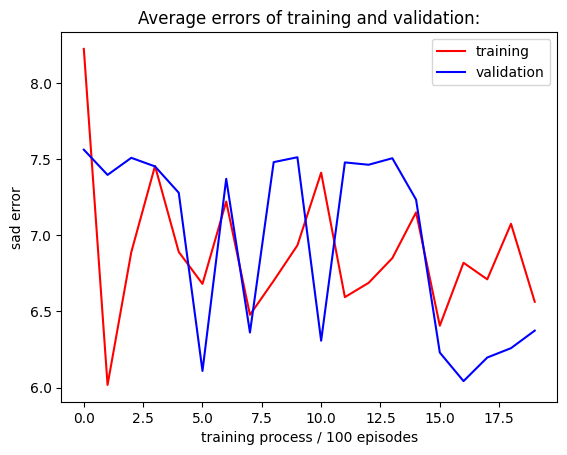

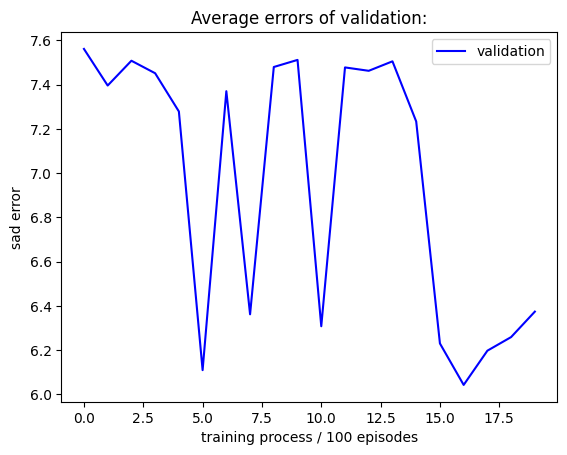

In [14]:
retrain(model_path='save/83.05787933483077_ratio_0.1_sed/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sad')

In [18]:
test(model_path='save/38.9846289584645_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/38.9846289584645_ratio_0.1_ped/======'
======loading test data======
It cost 0.5894179344177246s
training from last checkpoint save/38.9846289584645_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/38.9846289584645_ratio_0.1_ped/trained_model.ckpt
Effectiveness: 27.6689
Training elapsed time = 26.0619s
Effectiveness: 29.7843
Training elapsed time = 27.7367s
Effectiveness: 32.0333
Training elapsed time = 28.0235s


In [16]:
test(model_path='save/1.6437969868017062_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.6437969868017062_ratio_0.1_dad/======'
======loading test data======
It cost 0.7300183773040771s
training from last checkpoint save/1.6437969868017062_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6437969868017062_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.9371
Training elapsed time = 24.8659s
Effectiveness: 1.9329
Training elapsed time = 25.4435s
Effectiveness: 1.9211
Training elapsed time = 26.2529s


In [17]:
test(model_path='save/6.042294094442626_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.042294094442626_ratio_0.1_sad/======'
======loading test data======
It cost 0.6279168128967285s
training from last checkpoint save/6.042294094442626_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.042294094442626_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 7.1659
Training elapsed time = 56.6101s
Effectiveness: 6.8335
Training elapsed time = 58.9440s
Effectiveness: 6.9021
Training elapsed time = 62.5765s


In [19]:
test(model_path='save/83.05787933483077_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/83.05787933483077_ratio_0.1_sed/======'
======loading test data======
It cost 0.5859732627868652s
training from last checkpoint save/83.05787933483077_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/83.05787933483077_ratio_0.1_sed/trained_model.ckpt
Effectiveness: 29.5562
Training elapsed time = 26.6497s
Effectiveness: 29.7010
Training elapsed time = 28.3491s
Effectiveness: 30.9603
Training elapsed time = 28.1115s


======loading train data======
It cost 9.50003433227539s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 0 episode 100: Training error: 1.7900233117407678, Validation error: 1.6751390105494293
Save model with error 1.6751390105494293
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 242.76701188087463s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 0 episode 200: Training error: 1.918099887515584, Validation error: 1.762870120847969
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 260.74493408203125s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 1 episode 100: Training error: 1.84348821692333, Validation error: 1.7428705569935514
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 234.89168405532837s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 1 episode 200: Training error: 1.8865382453354382, Validation error: 1.7056887541183592
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 267.5450999736786s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 2 episode 100: Training error: 1.974923766839934, Validation error: 1.6956938023761123
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 263.9164776802063s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 2 episode 200: Training error: 1.7237713163397934, Validation error: 1.6903712748703497
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 237.93948698043823s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


round 3 episode 100: Training error: 1.8835853938983782, Validation error: 1.7465730672326163
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 255.89884877204895s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 3 episode 200: Training error: 1.8009901053897515, Validation error: 1.7108384092088673
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 248.84600448608398s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 4 episode 100: Training error: 1.7897641191154057, Validation error: 1.7251451123073929
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 232.81769490242004s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


round 4 episode 200: Training error: 1.9061314167207417, Validation error: 1.7355646262087823
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 266.33129119873047s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 5 episode 100: Training error: 1.9476724166596633, Validation error: 1.6888776595525306
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 271.96111011505127s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 5 episode 200: Training error: 1.7489711665981305, Validation error: 1.6956525139140404
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 231.98489332199097s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 6 episode 100: Training error: 1.8783151456864529, Validation error: 1.6936256230976146
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 264.8523426055908s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 6 episode 200: Training error: 1.7515012927436744, Validation error: 1.6755091288219608
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 237.1763916015625s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 7 episode 100: Training error: 1.756722536571952, Validation error: 1.6813137178185011
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 257.4832282066345s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 7 episode 200: Training error: 1.8785904533616613, Validation error: 1.679261665507683
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 245.12978291511536s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 8 episode 100: Training error: 1.9334950227796188, Validation error: 1.7147019064099176
==>current best model is 1.6751390105494293 with ratio 0.1
It costs 254.3337013721466s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


round 8 episode 200: Training error: 1.7046884091551644, Validation error: 1.6657190054420898
Save model with error 1.6657190054420898
==>current best model is 1.6657190054420898 with ratio 0.1
It costs 250.63889908790588s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 9 episode 100: Training error: 1.9077130061521441, Validation error: 1.7007874470481343
==>current best model is 1.6657190054420898 with ratio 0.1
It costs 244.39878106117249s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 9 episode 200: Training error: 1.7147930754474283, Validation error: 1.6578472410791913
Save model with error 1.6578472410791913
==>current best model is 1.6578472410791913 with ratio 0.1
It costs 255.02261066436768s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 10 episode 100: Training error: 1.8430089926195188, Validation error: 1.641422180679394
Save model with error 1.641422180679394
==>current best model is 1.641422180679394 with ratio 0.1
It costs 256.10489201545715s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 10 episode 200: Training error: 1.7670500890409668, Validation error: 1.661274117226342
==>current best model is 1.641422180679394 with ratio 0.1
It costs 246.9517879486084s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 11 episode 100: Training error: 1.7772403712363507, Validation error: 1.6513669122807773
==>current best model is 1.641422180679394 with ratio 0.1
It costs 269.02200651168823s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 11 episode 200: Training error: 1.8023968048348926, Validation error: 1.6422319746405756
==>current best model is 1.641422180679394 with ratio 0.1
It costs 235.19223618507385s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


round 12 episode 100: Training error: 1.8312528260849483, Validation error: 1.6511020933534937
==>current best model is 1.641422180679394 with ratio 0.1
It costs 256.9753620624542s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


round 12 episode 200: Training error: 1.740674153562172, Validation error: 1.6499140633956981
==>current best model is 1.641422180679394 with ratio 0.1
It costs 280.1543753147125s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 13 episode 100: Training error: 1.7427902982860592, Validation error: 1.6271416509806196
Save model with error 1.6271416509806196
==>current best model is 1.6271416509806196 with ratio 0.1
It costs 286.7507252693176s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 13 episode 200: Training error: 1.8350574447115933, Validation error: 1.6494421968207509
==>current best model is 1.6271416509806196 with ratio 0.1
It costs 281.6906371116638s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.80s/it]


round 14 episode 100: Training error: 1.7240472272896248, Validation error: 1.6631193342772472
==>current best model is 1.6271416509806196 with ratio 0.1
It costs 316.4439401626587s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 14 episode 200: Training error: 1.8444121075949882, Validation error: 1.65995996352336
==>current best model is 1.6271416509806196 with ratio 0.1
It costs 244.95441794395447s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


round 15 episode 100: Training error: 1.8269340998889854, Validation error: 1.6654128864581326
==>current best model is 1.6271416509806196 with ratio 0.1
It costs 287.90190982818604s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 15 episode 200: Training error: 1.7428163646953572, Validation error: 1.6473495795697124
==>current best model is 1.6271416509806196 with ratio 0.1
It costs 279.2614824771881s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 16 episode 100: Training error: 1.7596536491409116, Validation error: 1.6512811702622845
==>current best model is 1.6271416509806196 with ratio 0.1
It costs 269.6017186641693s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


round 16 episode 200: Training error: 1.8028093684471467, Validation error: 1.6565454171682086
==>current best model is 1.6271416509806196 with ratio 0.1
It costs 296.41202759742737s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 17 episode 100: Training error: 1.8035537804073036, Validation error: 1.6242221170182525
Save model with error 1.6242221170182525
==>current best model is 1.6242221170182525 with ratio 0.1
It costs 272.88852882385254s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


round 17 episode 200: Training error: 1.734944693551349, Validation error: 1.6606406047387468
==>current best model is 1.6242221170182525 with ratio 0.1
It costs 297.26264929771423s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


round 18 episode 100: Training error: 1.7699876389090736, Validation error: 1.654213550521102
==>current best model is 1.6242221170182525 with ratio 0.1
It costs 290.0493414402008s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 18 episode 200: Training error: 1.8067676561216093, Validation error: 1.6595717475566543
==>current best model is 1.6242221170182525 with ratio 0.1
It costs 279.83736085891724s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


round 19 episode 100: Training error: 1.825245974987117, Validation error: 1.6480399682721998
==>current best model is 1.6242221170182525 with ratio 0.1
It costs 277.65918374061584s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


round 19 episode 200: Training error: 1.72930560671541, Validation error: 1.6609818397797786
==>current best model is 1.6242221170182525 with ratio 0.1
It costs 292.35182881355286s
Training elapsed time = %s 10542.151675701141


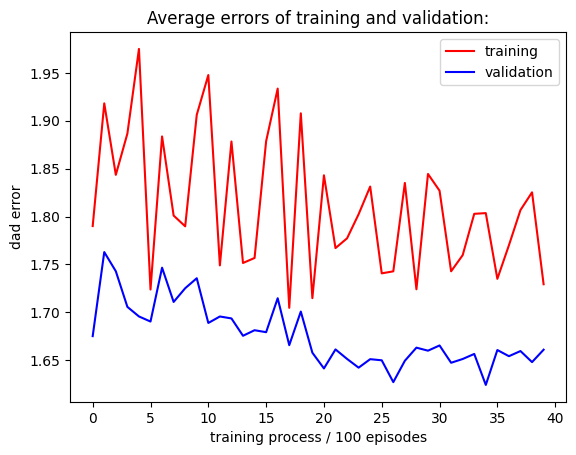

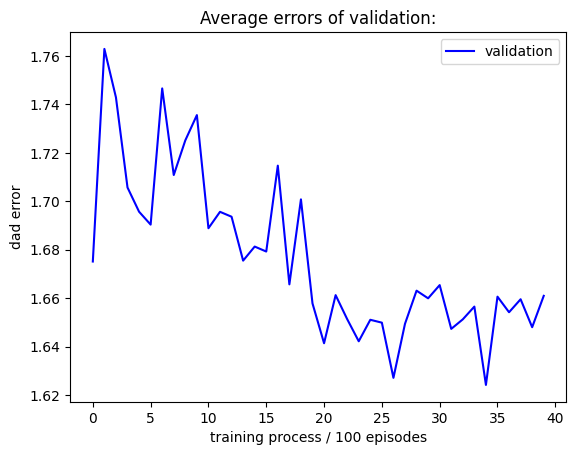

In [20]:
train(traj_amount=200, valid_amount=70, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======loading train data======
It cost 6.250278472900391s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.02s/it]


round 0 episode 100: Training error: 7.944600416093372, Validation error: 7.824897667025558
Save model with error 7.824897667025558
==>current best model is 7.824897667025558 with ratio 0.1
It costs 374.3215661048889s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.14s/it]


round 0 episode 200: Training error: 7.233987469794536, Validation error: 7.664270616347896
Save model with error 7.664270616347896
==>current best model is 7.664270616347896 with ratio 0.1
It costs 387.54633116722107s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.25s/it]


round 1 episode 100: Training error: 6.9195394188882196, Validation error: 8.050270844157543
==>current best model is 7.664270616347896 with ratio 0.1
It costs 396.1387619972229s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.92s/it]


round 1 episode 200: Training error: 7.6549263962220255, Validation error: 7.6438063847054085
Save model with error 7.6438063847054085
==>current best model is 7.6438063847054085 with ratio 0.1
It costs 361.7847101688385s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:08<00:00,  2.49s/it]


round 2 episode 100: Training error: 6.340804051580932, Validation error: 7.899453152261674
==>current best model is 7.6438063847054085 with ratio 0.1
It costs 420.2121012210846s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]


round 2 episode 200: Training error: 8.548079772056068, Validation error: 7.550287373002132
Save model with error 7.550287373002132
==>current best model is 7.550287373002132 with ratio 0.1
It costs 342.3992705345154s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.29s/it]


round 3 episode 100: Training error: 7.857006619416422, Validation error: 7.76263975597223
==>current best model is 7.550287373002132 with ratio 0.1
It costs 402.21379494667053s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.89s/it]


round 3 episode 200: Training error: 6.755993220322048, Validation error: 7.959064887341117
==>current best model is 7.550287373002132 with ratio 0.1
It costs 361.25212001800537s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.22s/it]


round 4 episode 100: Training error: 7.401608855119625, Validation error: 8.010466169578208
==>current best model is 7.550287373002132 with ratio 0.1
It costs 395.2303512096405s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:15<00:00,  1.96s/it]


round 4 episode 200: Training error: 7.275979466296124, Validation error: 7.703137208074546
==>current best model is 7.550287373002132 with ratio 0.1
It costs 369.4045934677124s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.00s/it]


round 5 episode 100: Training error: 7.402276916068535, Validation error: 7.908174361584257
==>current best model is 7.550287373002132 with ratio 0.1
It costs 372.39150762557983s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]


round 5 episode 200: Training error: 7.466995804063746, Validation error: 7.361874613744468
Save model with error 7.361874613744468
==>current best model is 7.361874613744468 with ratio 0.1
It costs 390.15659618377686s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.27s/it]


round 6 episode 100: Training error: 7.927396335119295, Validation error: 7.791157692015125
==>current best model is 7.361874613744468 with ratio 0.1
It costs 399.48046350479126s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:09<00:00,  1.89s/it]


round 6 episode 200: Training error: 6.74939441098316, Validation error: 7.9076898614333295
==>current best model is 7.361874613744468 with ratio 0.1
It costs 362.056405544281s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


round 7 episode 100: Training error: 7.184848690106706, Validation error: 7.688020172241563
==>current best model is 7.361874613744468 with ratio 0.1
It costs 385.6634726524353s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:23<00:00,  2.04s/it]


round 7 episode 200: Training error: 7.596139596275408, Validation error: 7.813925591622676
==>current best model is 7.361874613744468 with ratio 0.1
It costs 377.9136633872986s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.16s/it]


round 8 episode 100: Training error: 7.458845176597503, Validation error: 7.465749746289997
==>current best model is 7.361874613744468 with ratio 0.1
It costs 390.2370185852051s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


round 8 episode 200: Training error: 7.041098757709637, Validation error: 7.5225838365294395
==>current best model is 7.361874613744468 with ratio 0.1
It costs 383.47816252708435s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.02s/it]


round 9 episode 100: Training error: 7.0078333113596365, Validation error: 7.676984886019675
==>current best model is 7.361874613744468 with ratio 0.1
It costs 374.0028295516968s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


round 9 episode 200: Training error: 7.86500492791641, Validation error: 7.7229516087983905
==>current best model is 7.361874613744468 with ratio 0.1
It costs 385.91841864585876s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:14<00:00,  1.94s/it]


round 10 episode 100: Training error: 7.207201247444127, Validation error: 7.6663624603187746
==>current best model is 7.361874613744468 with ratio 0.1
It costs 366.3681583404541s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.20s/it]


round 10 episode 200: Training error: 7.176526023028767, Validation error: 7.540945825574787
==>current best model is 7.361874613744468 with ratio 0.1
It costs 392.088773727417s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:26<00:00,  2.06s/it]


round 11 episode 100: Training error: 7.298749461255605, Validation error: 7.43024540804862
==>current best model is 7.361874613744468 with ratio 0.1
It costs 379.0323565006256s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:27<00:00,  2.08s/it]


round 11 episode 200: Training error: 7.253285319177419, Validation error: 7.596931481216214
==>current best model is 7.361874613744468 with ratio 0.1
It costs 380.16060733795166s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:37<00:00,  2.17s/it]


round 12 episode 100: Training error: 6.392874684887621, Validation error: 7.494289753846692
==>current best model is 7.361874613744468 with ratio 0.1
It costs 389.9976279735565s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:19<00:00,  1.99s/it]


round 12 episode 200: Training error: 8.046738584206343, Validation error: 7.56466465288267
==>current best model is 7.361874613744468 with ratio 0.1
It costs 371.62794280052185s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 13 episode 100: Training error: 7.6757860449796995, Validation error: 7.612864451937767
==>current best model is 7.361874613744468 with ratio 0.1
It costs 321.3194110393524s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:21<00:00,  2.62s/it]


round 13 episode 200: Training error: 6.746740519722278, Validation error: 7.574863764406312
==>current best model is 7.361874613744468 with ratio 0.1
It costs 433.7441120147705s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


round 14 episode 100: Training error: 6.4336728529766365, Validation error: 7.448357338627322
==>current best model is 7.361874613744468 with ratio 0.1
It costs 356.74009585380554s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.29s/it]


round 14 episode 200: Training error: 7.861036396942114, Validation error: 7.6432742279142625
==>current best model is 7.361874613744468 with ratio 0.1
It costs 402.09877490997314s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.20s/it]


round 15 episode 100: Training error: 6.11613523295406, Validation error: 7.555901078517666
==>current best model is 7.361874613744468 with ratio 0.1
It costs 392.67226004600525s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:09<00:00,  1.89s/it]


round 15 episode 200: Training error: 8.336493147858835, Validation error: 7.764533282464311
==>current best model is 7.361874613744468 with ratio 0.1
It costs 361.4178650379181s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


round 16 episode 100: Training error: 7.81946564183399, Validation error: 7.584781219712811
==>current best model is 7.361874613744468 with ratio 0.1
It costs 342.9052267074585s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:02<00:00,  2.43s/it]


round 16 episode 200: Training error: 6.577823600657726, Validation error: 7.636200602177804
==>current best model is 7.361874613744468 with ratio 0.1
It costs 417.6436069011688s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


round 17 episode 100: Training error: 7.367668173571331, Validation error: 7.60915748993896
==>current best model is 7.361874613744468 with ratio 0.1
It costs 383.68721771240234s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:27<00:00,  2.08s/it]


round 17 episode 200: Training error: 7.0204758941968075, Validation error: 7.476391781580801
==>current best model is 7.361874613744468 with ratio 0.1
It costs 379.83992862701416s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:07<00:00,  2.48s/it]


round 18 episode 100: Training error: 6.866568834030431, Validation error: 7.661262411762641
==>current best model is 7.361874613744468 with ratio 0.1
It costs 419.1665678024292s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


round 18 episode 200: Training error: 7.375551557748073, Validation error: 7.590643157799103
==>current best model is 7.361874613744468 with ratio 0.1
It costs 337.8932523727417s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.98s/it]


round 19 episode 100: Training error: 7.392837172677861, Validation error: 7.457165936813218
==>current best model is 7.361874613744468 with ratio 0.1
It costs 370.3572688102722s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]


round 19 episode 200: Training error: 7.094213896983766, Validation error: 7.820463514633808
==>current best model is 7.361874613744468 with ratio 0.1
It costs 387.5596573352814s
Training elapsed time = %s 15218.130123853683


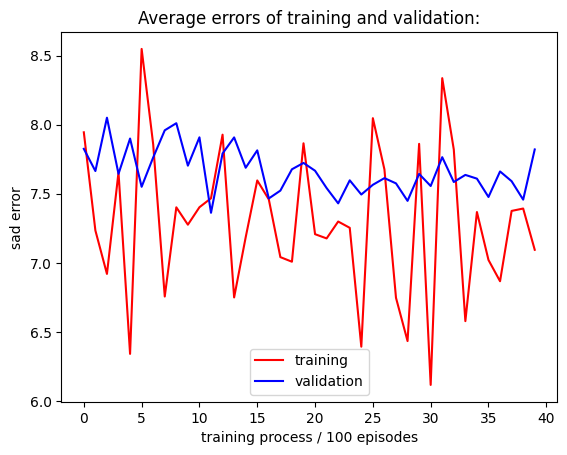

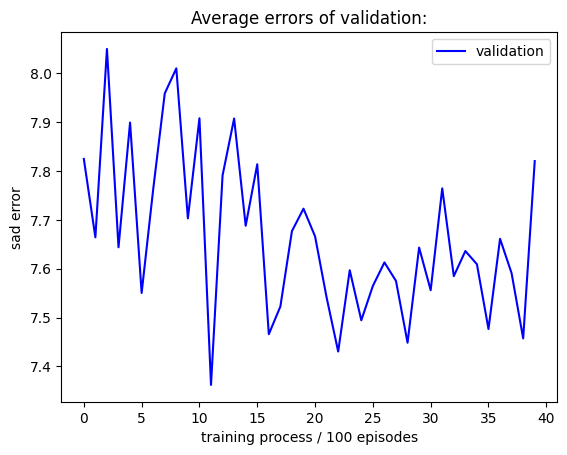

In [21]:
train(traj_amount=200, valid_amount=70, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sad')

In [32]:
test_err(model_path='save/1.6242221170182525_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save/1.6242221170182525_ratio_0.1_dad/======'
======loading test data======
It cost 2.2684402465820312s
training from last checkpoint save/1.6242221170182525_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6242221170182525_ratio_0.1_dad/trained_model.ckpt
Effectiveness of different errors: sed:113.9586, ped:36.9292, dad:1.9482, sad:6.9205
Testing elapsed time = 17.8961s, 12.8912s, 14.8183s, 32.6255s
Effectiveness of different errors: sed:113.6884, ped:36.2712, dad:1.9314, sad:6.9356
Testing elapsed time = 17.4783s, 12.9846s, 13.9670s, 32.2302s
Effectiveness of different errors: sed:113.5919, ped:36.5547, dad:1.9305, sad:6.9693
Testing elapsed time = 19.3882s, 13.1240s, 13.0713s, 29.4917s


In [23]:
test_err(model_path='save/7.361874613744468_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save/7.361874613744468_ratio_0.1_sad/======'
======loading test data======
It cost 0.8202791213989258s
training from last checkpoint save/7.361874613744468_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/7.361874613744468_ratio_0.1_sad/trained_model.ckpt
Effectiveness of different errors: sed:93.4398, ped:30.7402, dad:1.9699, sad:7.6054
Testing elapsed time = 40.2975s, 26.7905s, 28.3565s, 71.4439s
Effectiveness of different errors: sed:84.3814, ped:32.8220, dad:1.9861, sad:7.6798
Testing elapsed time = 43.0785s, 31.4787s, 32.1655s, 73.8619s
Effectiveness of different errors: sed:84.9007, ped:30.9692, dad:1.9905, sad:7.7438
Testing elapsed time = 42.3999s, 29.2067s, 31.4244s, 73.8226s


======loading train data======
It cost 6.221017599105835s.
training from last checkpoint save/1.6242221170182525_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6242221170182525_ratio_0.1_dad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 0 episode 100: Training error: 129.4796575918469, Validation error: 130.2590947315698
Save model with error 130.2590947315698
==>current best model is 130.2590947315698 with ratio 0.1
It costs 287.3720324039459s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.86s/it]


round 0 episode 200: Training error: 107.62813236508153, Validation error: 129.09620166236127
Save model with error 129.09620166236127
==>current best model is 129.09620166236127 with ratio 0.1
It costs 328.746310710907s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


round 1 episode 100: Training error: 98.77372854731979, Validation error: 129.35559321383028
==>current best model is 129.09620166236127 with ratio 0.1
It costs 321.93900179862976s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 1 episode 200: Training error: 138.8061021973546, Validation error: 129.15829315531576
==>current best model is 129.09620166236127 with ratio 0.1
It costs 261.22943663597107s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 2 episode 100: Training error: 137.9130135614959, Validation error: 128.33957154276547
Save model with error 128.33957154276547
==>current best model is 128.33957154276547 with ratio 0.1
It costs 270.8154966831207s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


round 2 episode 200: Training error: 100.85137595784612, Validation error: 128.8273386030539
==>current best model is 128.33957154276547 with ratio 0.1
It costs 292.8963930606842s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


round 3 episode 100: Training error: 119.17395317024994, Validation error: 128.84422836751403
==>current best model is 128.33957154276547 with ratio 0.1
It costs 272.93710684776306s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


round 3 episode 200: Training error: 117.13635901107813, Validation error: 129.07786589485872
==>current best model is 128.33957154276547 with ratio 0.1
It costs 284.171457529068s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


round 4 episode 100: Training error: 130.3954913683449, Validation error: 126.50022209229225
Save model with error 126.50022209229225
==>current best model is 126.50022209229225 with ratio 0.1
It costs 282.94109416007996s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


round 4 episode 200: Training error: 107.65407917096178, Validation error: 126.95706049712075
==>current best model is 126.50022209229225 with ratio 0.1
It costs 272.8358750343323s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 5 episode 100: Training error: 134.53827139477914, Validation error: 129.17918919093634
==>current best model is 126.50022209229225 with ratio 0.1
It costs 257.3045754432678s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


round 5 episode 200: Training error: 101.84914917229264, Validation error: 129.0552910188963
==>current best model is 126.50022209229225 with ratio 0.1
It costs 310.48635959625244s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/it]


round 6 episode 100: Training error: 158.01421860589718, Validation error: 128.03438550349847
==>current best model is 126.50022209229225 with ratio 0.1
It costs 297.68238377571106s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


round 6 episode 200: Training error: 78.53277238167203, Validation error: 129.1839262650736
==>current best model is 126.50022209229225 with ratio 0.1
It costs 360.1237370967865s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 7 episode 100: Training error: 147.23133451640768, Validation error: 128.94696656343868
==>current best model is 126.50022209229225 with ratio 0.1
It costs 214.2947337627411s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 7 episode 200: Training error: 87.94945859200803, Validation error: 128.17233203492287
==>current best model is 126.50022209229225 with ratio 0.1
It costs 231.3977222442627s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 8 episode 100: Training error: 112.13664722068313, Validation error: 132.26307076001876
==>current best model is 126.50022209229225 with ratio 0.1
It costs 200.43091130256653s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 8 episode 200: Training error: 124.96278647536457, Validation error: 129.18922547405197
==>current best model is 126.50022209229225 with ratio 0.1
It costs 237.43050861358643s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 9 episode 100: Training error: 126.76504830466233, Validation error: 129.06521612259996
==>current best model is 126.50022209229225 with ratio 0.1
It costs 237.5656864643097s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 9 episode 200: Training error: 109.67514570289605, Validation error: 128.65781514341376
==>current best model is 126.50022209229225 with ratio 0.1
It costs 196.62815690040588s
Training elapsed time = %s 5419.231028795242


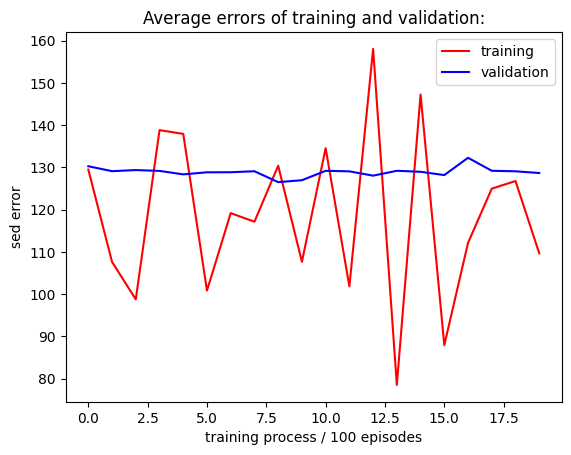

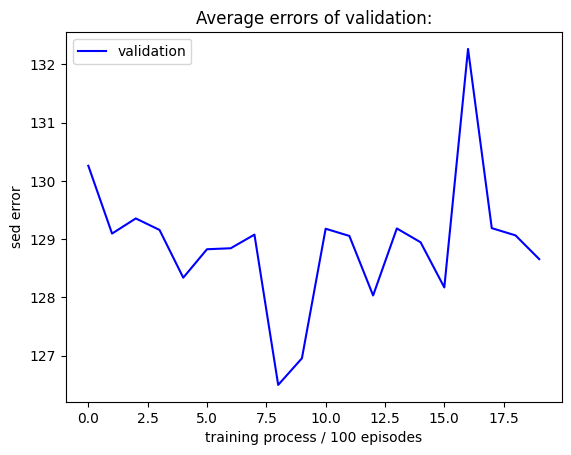

In [24]:
retrain(model_path='save/1.6242221170182525_ratio_0.1_dad/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 5.3981688022613525s.
training from last checkpoint save/1.6242221170182525_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6242221170182525_ratio_0.1_dad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 0 episode 100: Training error: 23.79819645168703, Validation error: 52.760359677048555
Save model with error 52.760359677048555
==>current best model is 52.760359677048555 with ratio 0.1
It costs 191.34562921524048s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 0 episode 200: Training error: 42.06889573206095, Validation error: 53.68569958209062
==>current best model is 52.760359677048555 with ratio 0.1
It costs 198.56995797157288s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 1 episode 100: Training error: 29.42228168682741, Validation error: 54.41979488298382
==>current best model is 52.760359677048555 with ratio 0.1
It costs 189.89314222335815s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 1 episode 200: Training error: 36.37144872569833, Validation error: 52.438651811314955
Save model with error 52.438651811314955
==>current best model is 52.438651811314955 with ratio 0.1
It costs 205.31682300567627s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 2 episode 100: Training error: 41.2841305475403, Validation error: 52.43250718590327
Save model with error 52.43250718590327
==>current best model is 52.43250718590327 with ratio 0.1
It costs 213.28232884407043s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


round 2 episode 200: Training error: 24.563485207798344, Validation error: 53.01655143426124
==>current best model is 52.43250718590327 with ratio 0.1
It costs 183.0970413684845s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 3 episode 100: Training error: 24.58350899097762, Validation error: 50.45200388522021
Save model with error 50.45200388522021
==>current best model is 50.45200388522021 with ratio 0.1
It costs 195.96220016479492s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 3 episode 200: Training error: 41.776955054969996, Validation error: 47.81542786947116
Save model with error 47.81542786947116
==>current best model is 47.81542786947116 with ratio 0.1
It costs 197.78011751174927s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


round 4 episode 100: Training error: 35.06353430709893, Validation error: 50.903546782414104
==>current best model is 47.81542786947116 with ratio 0.1
It costs 203.4576575756073s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 4 episode 200: Training error: 31.495106975261777, Validation error: 52.53347644283381
==>current best model is 47.81542786947116 with ratio 0.1
It costs 190.4698028564453s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


round 5 episode 100: Training error: 28.954491797520486, Validation error: 52.64984837988579
==>current best model is 47.81542786947116 with ratio 0.1
It costs 202.93045139312744s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 5 episode 200: Training error: 36.78427263800457, Validation error: 52.81547167690768
==>current best model is 47.81542786947116 with ratio 0.1
It costs 190.83524680137634s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 6 episode 100: Training error: 33.96753538153575, Validation error: 56.23199786546888
==>current best model is 47.81542786947116 with ratio 0.1
It costs 196.5204472541809s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 6 episode 200: Training error: 31.50580105352336, Validation error: 52.01978621712448
==>current best model is 47.81542786947116 with ratio 0.1
It costs 201.32050800323486s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


round 7 episode 100: Training error: 34.44086773707276, Validation error: 52.74571890421877
==>current best model is 47.81542786947116 with ratio 0.1
It costs 185.44917917251587s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 7 episode 200: Training error: 31.409862298399258, Validation error: 52.59905152140849
==>current best model is 47.81542786947116 with ratio 0.1
It costs 213.2528703212738s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 8 episode 100: Training error: 32.45003932022041, Validation error: 52.55573679336152
==>current best model is 47.81542786947116 with ratio 0.1
It costs 187.4432897567749s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 8 episode 200: Training error: 33.51985857548252, Validation error: 52.650169985435156
==>current best model is 47.81542786947116 with ratio 0.1
It costs 206.2287619113922s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 9 episode 100: Training error: 34.88526723388921, Validation error: 52.871009103401185
==>current best model is 47.81542786947116 with ratio 0.1
It costs 196.16832304000854s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 9 episode 200: Training error: 30.76583331442928, Validation error: 54.163097679959314
==>current best model is 47.81542786947116 with ratio 0.1
It costs 196.19423270225525s
Training elapsed time = %s 3945.520037651062


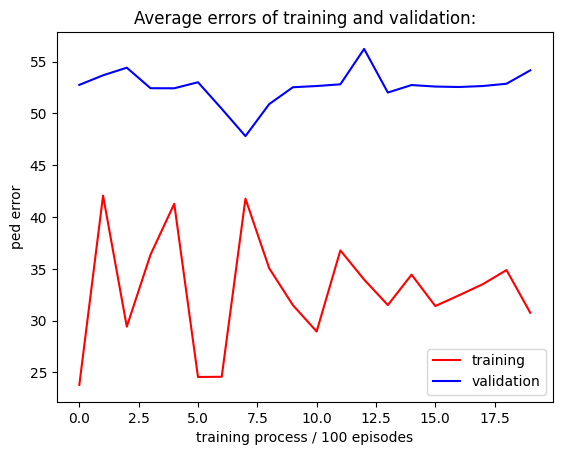

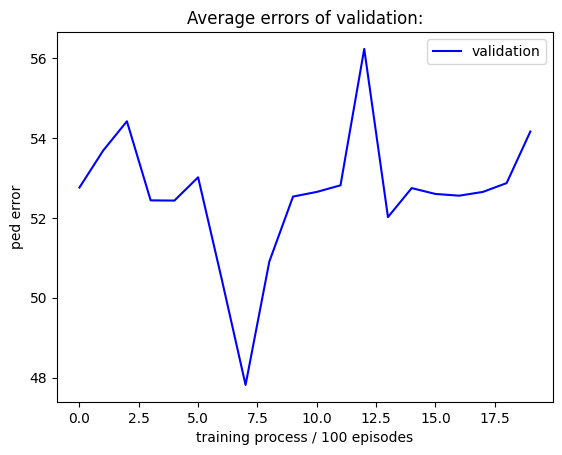

In [25]:
retrain(model_path='save/1.6242221170182525_ratio_0.1_dad/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======loading train data======
It cost 9.218477010726929s.
training from last checkpoint save/1.6242221170182525_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6242221170182525_ratio_0.1_dad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


round 0 episode 100: Training error: 6.926747640840383, Validation error: 6.256300404558749
Save model with error 6.256300404558749
==>current best model is 6.256300404558749 with ratio 0.1
It costs 268.6868600845337s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 0 episode 200: Training error: 6.837513840257478, Validation error: 6.319516801923714
==>current best model is 6.256300404558749 with ratio 0.1
It costs 244.47166895866394s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 1 episode 100: Training error: 7.319219230420301, Validation error: 6.331468035901712
==>current best model is 6.256300404558749 with ratio 0.1
It costs 240.80326390266418s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 1 episode 200: Training error: 6.3795529420359856, Validation error: 6.288629682653943
==>current best model is 6.256300404558749 with ratio 0.1
It costs 260.59435272216797s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 2 episode 100: Training error: 7.5278563874765085, Validation error: 6.3116924700453
==>current best model is 6.256300404558749 with ratio 0.1
It costs 241.0098683834076s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 2 episode 200: Training error: 6.169148755929471, Validation error: 6.345370769421704
==>current best model is 6.256300404558749 with ratio 0.1
It costs 258.5576505661011s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 3 episode 100: Training error: 7.271149307847205, Validation error: 6.315395141106433
==>current best model is 6.256300404558749 with ratio 0.1
It costs 227.34400057792664s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


round 3 episode 200: Training error: 6.411376292180356, Validation error: 6.314401094016311
==>current best model is 6.256300404558749 with ratio 0.1
It costs 275.10504055023193s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 4 episode 100: Training error: 7.188850729411789, Validation error: 6.3444849249935364
==>current best model is 6.256300404558749 with ratio 0.1
It costs 237.52243423461914s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


round 4 episode 200: Training error: 6.465710904408753, Validation error: 6.309539640485046
==>current best model is 6.256300404558749 with ratio 0.1
It costs 265.3163924217224s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 5 episode 100: Training error: 7.295276835189104, Validation error: 6.342343966755587
==>current best model is 6.256300404558749 with ratio 0.1
It costs 247.17192482948303s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


round 5 episode 200: Training error: 6.3948109338328445, Validation error: 6.332139798151469
==>current best model is 6.256300404558749 with ratio 0.1
It costs 253.82558608055115s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 6 episode 100: Training error: 6.325402997713181, Validation error: 6.320950380053492
==>current best model is 6.256300404558749 with ratio 0.1
It costs 250.7710349559784s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


round 6 episode 200: Training error: 7.381021648380413, Validation error: 6.307401677907224
==>current best model is 6.256300404558749 with ratio 0.1
It costs 249.71965909004211s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


round 7 episode 100: Training error: 6.936140492635367, Validation error: 6.291941551987861
==>current best model is 6.256300404558749 with ratio 0.1
It costs 241.78816747665405s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 7 episode 200: Training error: 6.790345330404031, Validation error: 6.351763369153577
==>current best model is 6.256300404558749 with ratio 0.1
It costs 250.66245341300964s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 8 episode 100: Training error: 6.855072499994826, Validation error: 6.283641512144718
==>current best model is 6.256300404558749 with ratio 0.1
It costs 232.11920762062073s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 8 episode 200: Training error: 6.772763358608797, Validation error: 6.2582846343864045
==>current best model is 6.256300404558749 with ratio 0.1
It costs 262.18785095214844s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 9 episode 100: Training error: 6.849741313727297, Validation error: 6.300386998479364
==>current best model is 6.256300404558749 with ratio 0.1
It costs 253.07172751426697s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 9 episode 200: Training error: 6.788338842572359, Validation error: 6.284067202436042
==>current best model is 6.256300404558749 with ratio 0.1
It costs 240.04342675209045s
Training elapsed time = %s 5000.7725710868835


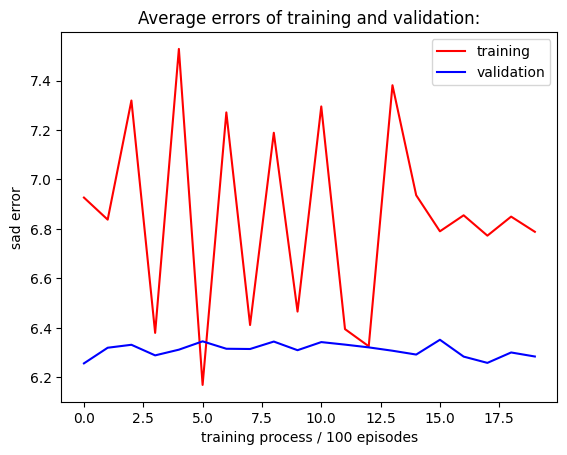

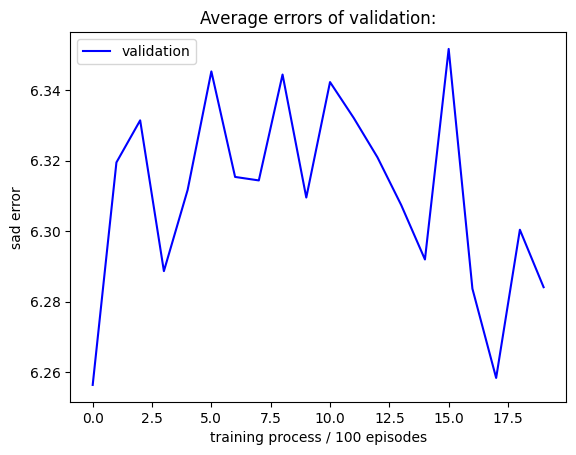

In [26]:
retrain(model_path='save/1.6242221170182525_ratio_0.1_dad/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sad')

In [33]:
test(model_path='save/126.50022209229225_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/126.50022209229225_ratio_0.1_sed/======'
======loading test data======
It cost 0.45421791076660156s
training from last checkpoint save/126.50022209229225_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/126.50022209229225_ratio_0.1_sed/trained_model.ckpt
Effectiveness: 113.9544
Training elapsed time = 17.8723s
Effectiveness: 113.1312
Training elapsed time = 17.8201s
Effectiveness: 112.7042
Training elapsed time = 17.6670s


In [31]:
test(model_path='save/47.81542786947116_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/47.81542786947116_ratio_0.1_ped/======'
======loading test data======
It cost 0.5348594188690186s
training from last checkpoint save/47.81542786947116_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/47.81542786947116_ratio_0.1_ped/trained_model.ckpt
Effectiveness: 36.7736
Training elapsed time = 15.1502s
Effectiveness: 36.5947
Training elapsed time = 14.1033s
Effectiveness: 36.3932
Training elapsed time = 12.9648s


In [34]:
test(model_path='save/6.256300404558749_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.256300404558749_ratio_0.1_sad/======'
======loading test data======
It cost 0.4604671001434326s
training from last checkpoint save/6.256300404558749_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.256300404558749_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 6.9442
Training elapsed time = 32.7377s
Effectiveness: 6.9082
Training elapsed time = 30.6804s
Effectiveness: 6.9061
Training elapsed time = 29.5898s


======loading train data======
It cost 11.556847095489502s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save/7.361874613744468_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/7.361874613744468_ratio_0.1_sad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 0 episode 100: Training error: 90.72140087631527, Validation error: 109.98079742953308
Save model with error 109.98079742953308
==>current best model is 109.98079742953308 with ratio 0.1
It costs 227.57826209068298s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


round 0 episode 200: Training error: 102.91464646952643, Validation error: 98.11846907271263
Save model with error 98.11846907271263
==>current best model is 98.11846907271263 with ratio 0.1
It costs 203.9591166973114s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 1 episode 100: Training error: 69.59445929449083, Validation error: 102.20331326182195
==>current best model is 98.11846907271263 with ratio 0.1
It costs 207.48369002342224s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 1 episode 200: Training error: 122.00980575925334, Validation error: 96.81852469241426
Save model with error 96.81852469241426
==>current best model is 96.81852469241426 with ratio 0.1
It costs 204.9910078048706s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 2 episode 100: Training error: 107.35414233115131, Validation error: 101.0921760800338
==>current best model is 96.81852469241426 with ratio 0.1
It costs 188.74539589881897s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 2 episode 200: Training error: 64.33065914194333, Validation error: 99.073825157919
==>current best model is 96.81852469241426 with ratio 0.1
It costs 222.8492398262024s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 3 episode 100: Training error: 67.9660213507329, Validation error: 98.2490003779616
==>current best model is 96.81852469241426 with ratio 0.1
It costs 221.4069800376892s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 3 episode 200: Training error: 110.12567994712995, Validation error: 91.8661963689748
Save model with error 91.8661963689748
==>current best model is 91.8661963689748 with ratio 0.1
It costs 201.32400250434875s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 4 episode 100: Training error: 108.10862675478342, Validation error: 92.14769296356
==>current best model is 91.8661963689748 with ratio 0.1
It costs 216.51306462287903s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 4 episode 200: Training error: 60.29260249778571, Validation error: 92.5776739228852
==>current best model is 91.8661963689748 with ratio 0.1
It costs 203.071697473526s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 5 episode 100: Training error: 74.3333648583643, Validation error: 93.92331954522129
==>current best model is 91.8661963689748 with ratio 0.1
It costs 199.8863160610199s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 5 episode 200: Training error: 91.52776190389056, Validation error: 99.8902341453346
==>current best model is 91.8661963689748 with ratio 0.1
It costs 210.75530219078064s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 6 episode 100: Training error: 94.31498538928932, Validation error: 89.67844164380269
Save model with error 89.67844164380269
==>current best model is 89.67844164380269 with ratio 0.1
It costs 199.4060800075531s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 6 episode 200: Training error: 81.60786719360294, Validation error: 96.10579645995178
==>current best model is 89.67844164380269 with ratio 0.1
It costs 212.40870714187622s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 7 episode 100: Training error: 80.30814711868715, Validation error: 92.21295464687275
==>current best model is 89.67844164380269 with ratio 0.1
It costs 190.81339764595032s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 7 episode 200: Training error: 81.54935672865209, Validation error: 88.99240689343749
Save model with error 88.99240689343749
==>current best model is 88.99240689343749 with ratio 0.1
It costs 227.22726798057556s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 8 episode 100: Training error: 102.28931124976576, Validation error: 96.7291013808136
==>current best model is 88.99240689343749 with ratio 0.1
It costs 217.91748046875s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 8 episode 200: Training error: 71.45498859788455, Validation error: 94.80489979373228
==>current best model is 88.99240689343749 with ratio 0.1
It costs 197.46481013298035s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 9 episode 100: Training error: 72.88119910130294, Validation error: 96.02977340698583
==>current best model is 88.99240689343749 with ratio 0.1
It costs 228.48561429977417s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 9 episode 200: Training error: 110.79765169578639, Validation error: 89.61553746532846
==>current best model is 88.99240689343749 with ratio 0.1
It costs 182.0964150428772s
Training elapsed time = %s 4164.384848117828


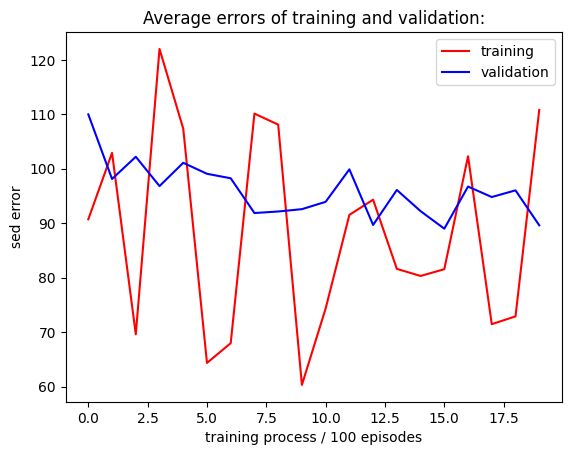

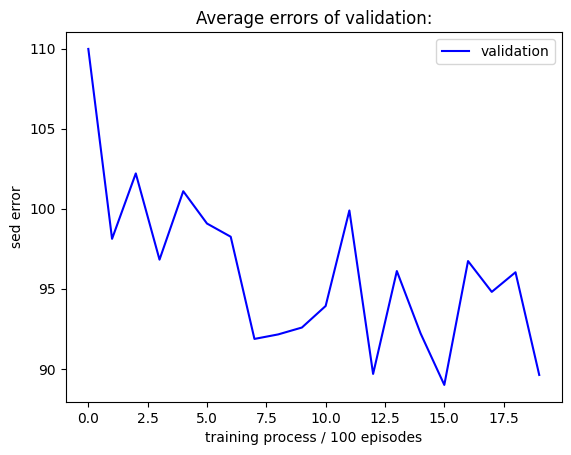

In [5]:
retrain(model_path='save/7.361874613744468_ratio_0.1_sad/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='sed')

In [6]:
test(model_path='save/88.99240689343749_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/88.99240689343749_ratio_0.1_sed/======'
======loading test data======
It cost 4.525292873382568s
training from last checkpoint save/88.99240689343749_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/88.99240689343749_ratio_0.1_sed/trained_model.ckpt
Effectiveness: 72.8138
Training elapsed time = 21.3147s
Effectiveness: 74.8765
Training elapsed time = 18.5418s
Effectiveness: 69.0976
Training elapsed time = 17.4403s


======loading train data======
It cost 10.328646421432495s.
training from last checkpoint save/7.361874613744468_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/7.361874613744468_ratio_0.1_sad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


round 0 episode 100: Training error: 31.22052086229516, Validation error: 62.48550836526673
Save model with error 62.48550836526673
==>current best model is 62.48550836526673 with ratio 0.1
It costs 218.27200174331665s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 0 episode 200: Training error: 34.14011148957579, Validation error: 55.90544999798224
Save model with error 55.90544999798224
==>current best model is 55.90544999798224 with ratio 0.1
It costs 219.49249243736267s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 1 episode 100: Training error: 50.40819746741934, Validation error: 51.40489511654804
Save model with error 51.40489511654804
==>current best model is 51.40489511654804 with ratio 0.1
It costs 222.24016118049622s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 1 episode 200: Training error: 29.786568931003398, Validation error: 53.45737207319409
==>current best model is 51.40489511654804 with ratio 0.1
It costs 214.76307368278503s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 2 episode 100: Training error: 22.616372161856642, Validation error: 54.95701380604564
==>current best model is 51.40489511654804 with ratio 0.1
It costs 240.17247462272644s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 2 episode 200: Training error: 45.81438830894583, Validation error: 47.915571226701594
Save model with error 47.915571226701594
==>current best model is 47.915571226701594 with ratio 0.1
It costs 196.56878304481506s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 3 episode 100: Training error: 36.746399228662504, Validation error: 56.2931240013649
==>current best model is 47.915571226701594 with ratio 0.1
It costs 210.3984076976776s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 3 episode 200: Training error: 24.134384638517435, Validation error: 53.233919668332234
==>current best model is 47.915571226701594 with ratio 0.1
It costs 218.72723937034607s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


round 4 episode 100: Training error: 43.3220877541361, Validation error: 50.93177602525574
==>current best model is 47.915571226701594 with ratio 0.1
It costs 213.51103448867798s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


round 4 episode 200: Training error: 24.680536684411983, Validation error: 43.80642128389596
Save model with error 43.80642128389596
==>current best model is 43.80642128389596 with ratio 0.1
It costs 216.86461114883423s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 5 episode 100: Training error: 32.695851860404126, Validation error: 50.388652937479
==>current best model is 43.80642128389596 with ratio 0.1
It costs 212.40752506256104s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 5 episode 200: Training error: 26.55458055309684, Validation error: 52.58601162758198
==>current best model is 43.80642128389596 with ratio 0.1
It costs 227.35282588005066s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 6 episode 100: Training error: 37.00643719308495, Validation error: 46.42046562530422
==>current best model is 43.80642128389596 with ratio 0.1
It costs 210.69258737564087s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 6 episode 200: Training error: 24.59520059877402, Validation error: 49.9950794555783
==>current best model is 43.80642128389596 with ratio 0.1
It costs 224.75185799598694s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


round 7 episode 100: Training error: 39.58855643015319, Validation error: 49.97480085879598
==>current best model is 43.80642128389596 with ratio 0.1
It costs 197.29763293266296s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 7 episode 200: Training error: 26.598860933010915, Validation error: 53.84573229551083
==>current best model is 43.80642128389596 with ratio 0.1
It costs 241.5087695121765s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 8 episode 100: Training error: 44.77506579455046, Validation error: 54.117962466960954
==>current best model is 43.80642128389596 with ratio 0.1
It costs 227.34616470336914s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 8 episode 200: Training error: 23.587276571911147, Validation error: 54.25824522440371
==>current best model is 43.80642128389596 with ratio 0.1
It costs 217.04211258888245s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 9 episode 100: Training error: 34.60200207745106, Validation error: 50.72721830914671
==>current best model is 43.80642128389596 with ratio 0.1
It costs 204.65209698677063s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 9 episode 200: Training error: 24.332900953059458, Validation error: 44.8602504235988
==>current best model is 43.80642128389596 with ratio 0.1
It costs 253.5121259689331s
Training elapsed time = %s 4387.574985742569


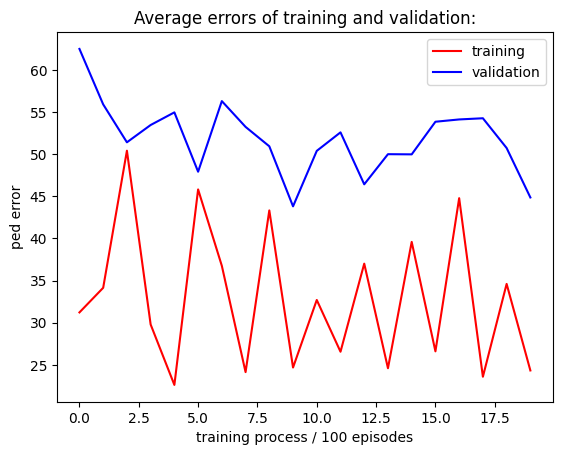

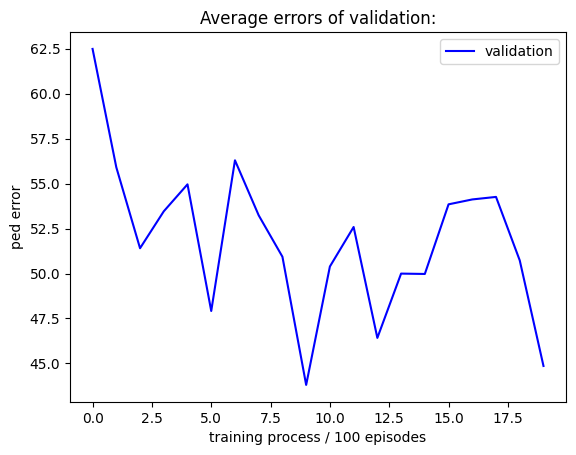

In [7]:
retrain(model_path='save/7.361874613744468_ratio_0.1_sad/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='ped')

In [8]:
test(model_path='save/43.80642128389596_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/43.80642128389596_ratio_0.1_ped/======'
======loading test data======
It cost 3.2288918495178223s
training from last checkpoint save/43.80642128389596_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/43.80642128389596_ratio_0.1_ped/trained_model.ckpt
Effectiveness: 30.3378
Training elapsed time = 13.4855s
Effectiveness: 28.9257
Training elapsed time = 12.9475s
Effectiveness: 29.6437
Training elapsed time = 13.1388s


======loading train data======
It cost 11.972833156585693s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save/7.361874613744468_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/7.361874613744468_ratio_0.1_sad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 0 episode 100: Training error: 1.8742641559241031, Validation error: 1.7104749214298962
Save model with error 1.7104749214298962
==>current best model is 1.7104749214298962 with ratio 0.1
It costs 192.7458086013794s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 0 episode 200: Training error: 1.7799222166061737, Validation error: 1.714905405614964
==>current best model is 1.7104749214298962 with ratio 0.1
It costs 197.2079463005066s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 1 episode 100: Training error: 1.807669282296898, Validation error: 1.7046716663290162
Save model with error 1.7046716663290162
==>current best model is 1.7046716663290162 with ratio 0.1
It costs 200.0085470676422s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 1 episode 200: Training error: 1.8476771575125586, Validation error: 1.682032315915766
Save model with error 1.682032315915766
==>current best model is 1.682032315915766 with ratio 0.1
It costs 200.6401572227478s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 2 episode 100: Training error: 1.9253563677560583, Validation error: 1.6698065047808146
Save model with error 1.6698065047808146
==>current best model is 1.6698065047808146 with ratio 0.1
It costs 192.75494122505188s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 2 episode 200: Training error: 1.7968061766502388, Validation error: 1.687073447404329
==>current best model is 1.6698065047808146 with ratio 0.1
It costs 199.8912603855133s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 3 episode 100: Training error: 1.9839612525527426, Validation error: 1.6552914658517766
Save model with error 1.6552914658517766
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 197.56639432907104s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 3 episode 200: Training error: 1.6620630344967435, Validation error: 1.6937269961387986
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 192.71652793884277s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 4 episode 100: Training error: 1.7521951227941779, Validation error: 1.691686604361823
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 206.03597354888916s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 4 episode 200: Training error: 1.8942074376538813, Validation error: 1.692973285659882
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 183.70628547668457s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 5 episode 100: Training error: 1.732864978254288, Validation error: 1.7216880643985766
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 192.26590394973755s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 5 episode 200: Training error: 1.901314583729693, Validation error: 1.6815115654114539
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 188.52272081375122s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 6 episode 100: Training error: 1.8574985341440942, Validation error: 1.6712441923815506
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 194.99556875228882s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


round 6 episode 200: Training error: 1.8130115265962936, Validation error: 1.6679280128131875
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 188.17130637168884s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 7 episode 100: Training error: 1.8431579327914465, Validation error: 1.6759264500908129
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 192.7497742176056s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


round 7 episode 200: Training error: 1.8076236503451395, Validation error: 1.678668942928102
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 188.43440508842468s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


round 8 episode 100: Training error: 1.754405850350536, Validation error: 1.7052940946788335
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 176.8340926170349s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 8 episode 200: Training error: 1.8504231859939069, Validation error: 1.6677474142417468
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 206.14414978027344s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


round 9 episode 100: Training error: 1.7615852472150118, Validation error: 1.6588533270497374
==>current best model is 1.6552914658517766 with ratio 0.1
It costs 184.1255660057068s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 9 episode 200: Training error: 1.8303681626792285, Validation error: 1.6532924097441462
Save model with error 1.6532924097441462
==>current best model is 1.6532924097441462 with ratio 0.1
It costs 197.71066117286682s
Training elapsed time = %s 3873.2289979457855


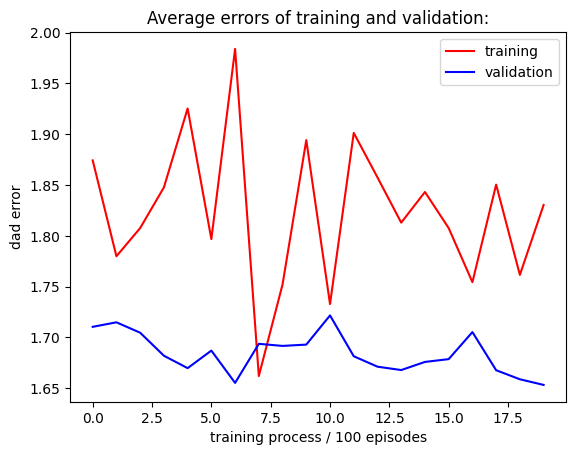

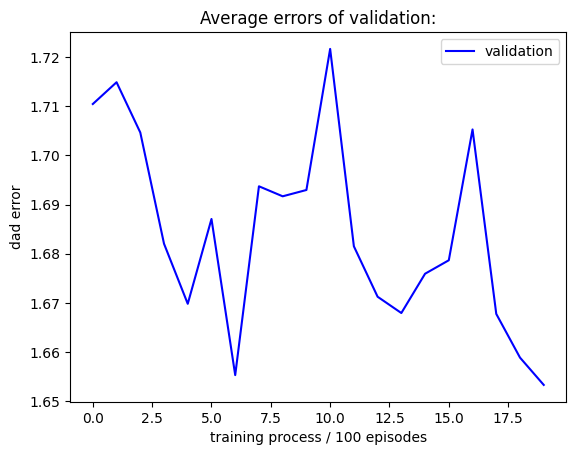

In [4]:
retrain(model_path='save/7.361874613744468_ratio_0.1_sad/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======loading train data======
It cost 11.827136278152466s.
training from last checkpoint save/1.6242221170182525_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6242221170182525_ratio_0.1_dad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 0 episode 100: Training error: 1.755688128332216, Validation error: 1.657359841451469
Save model with error 1.657359841451469
==>current best model is 1.657359841451469 with ratio 0.1
It costs 188.76354384422302s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 0 episode 200: Training error: 1.808224006963884, Validation error: 1.6503312012247204
Save model with error 1.6503312012247204
==>current best model is 1.6503312012247204 with ratio 0.1
It costs 199.66882395744324s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 1 episode 100: Training error: 1.7687753437146125, Validation error: 1.652662903998882
==>current best model is 1.6503312012247204 with ratio 0.1
It costs 194.44321036338806s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 1 episode 200: Training error: 1.7868538757785388, Validation error: 1.6280097071050244
Save model with error 1.6280097071050244
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 187.9822027683258s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 2 episode 100: Training error: 1.80615504055239, Validation error: 1.6705706559166311
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 193.18425679206848s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 2 episode 200: Training error: 1.7711871260875132, Validation error: 1.6479078401807894
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 188.5683388710022s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 3 episode 100: Training error: 1.849947583219961, Validation error: 1.6567930272448212
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 187.17097973823547s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 3 episode 200: Training error: 1.70622221672467, Validation error: 1.6527340561062807
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 194.0581090450287s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 4 episode 100: Training error: 1.7182898801872182, Validation error: 1.6325711137505141
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 184.38250470161438s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 4 episode 200: Training error: 1.8380776743811595, Validation error: 1.6652507880818408
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 197.34984827041626s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 5 episode 100: Training error: 1.770981820486352, Validation error: 1.6597414865854647
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 187.53668236732483s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 5 episode 200: Training error: 1.8038692946253219, Validation error: 1.664130700195144
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 192.64890718460083s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 6 episode 100: Training error: 1.7061676019454868, Validation error: 1.6429859342447475
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 183.23437762260437s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 6 episode 200: Training error: 1.860267832131399, Validation error: 1.651726385757607
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 197.39680004119873s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 7 episode 100: Training error: 1.820940102684905, Validation error: 1.649873362319474
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 192.46300673484802s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 7 episode 200: Training error: 1.7463673928228312, Validation error: 1.655296993916104
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 189.69456458091736s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 8 episode 100: Training error: 1.7718725108715387, Validation error: 1.639378068819597
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 193.20666599273682s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 8 episode 200: Training error: 1.7802035272888161, Validation error: 1.6345412203004348
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 185.6727602481842s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 9 episode 100: Training error: 1.702472067125469, Validation error: 1.638850919335618
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 200.36288285255432s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 9 episode 200: Training error: 1.867909451798377, Validation error: 1.6421506055679862
==>current best model is 1.6280097071050244 with ratio 0.1
It costs 181.6387174129486s
Training elapsed time = %s 3819.4292051792145


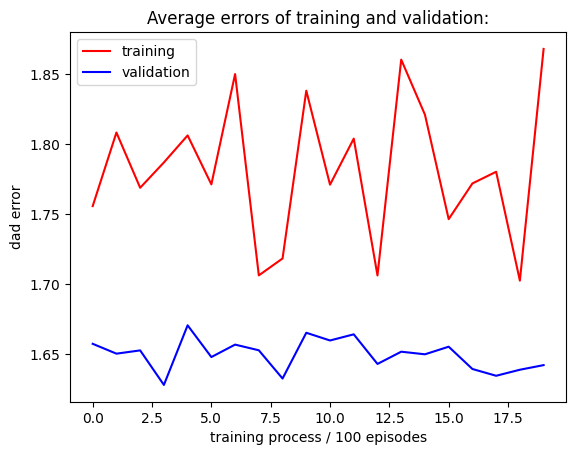

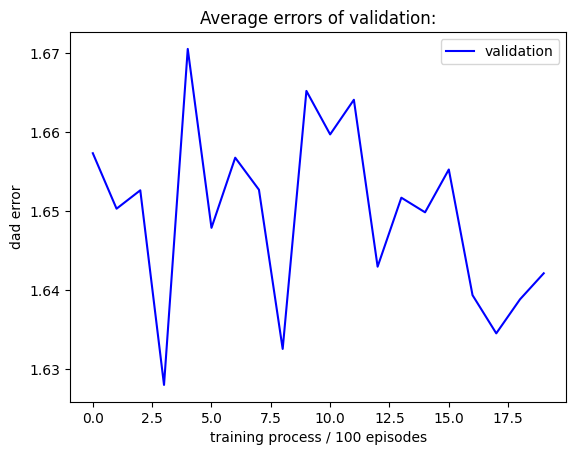

In [5]:
retrain(model_path='save/1.6242221170182525_ratio_0.1_dad/',traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, label='dad')

In [14]:
test(model_path='save/1.6532924097441462_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.6532924097441462_ratio_0.1_dad/======'
======loading test data======
It cost 0.5279138088226318s
training from last checkpoint save/1.6532924097441462_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6532924097441462_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.9498
Training elapsed time = 19.3129s
Effectiveness: 1.9250
Training elapsed time = 19.6091s
Effectiveness: 1.9426
Training elapsed time = 19.6983s


In [7]:
test(model_path='save/1.6280097071050244_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.6280097071050244_ratio_0.1_dad/======'
======loading test data======
It cost 0.5295445919036865s
training from last checkpoint save/1.6280097071050244_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6280097071050244_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.9361
Training elapsed time = 12.4921s
Effectiveness: 1.9504
Training elapsed time = 12.9235s
Effectiveness: 1.9311
Training elapsed time = 12.4887s


In [8]:
test(model_path='save/1.6280097071050244_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/1.6280097071050244_ratio_0.1_dad/======'
======loading test data======
It cost 0.4785153865814209s
training from last checkpoint save/1.6280097071050244_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.6280097071050244_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 6.9461
Training elapsed time = 30.0424s
Effectiveness: 6.9323
Training elapsed time = 29.7537s
Effectiveness: 6.9333
Training elapsed time = 28.3788s


In [12]:
test_err(model_path='save/6.12439007436741_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3)

======Start testing the model at'save/6.12439007436741_ratio_0.1_sad/======'
======loading test data======
It cost 0.7932412624359131s
training from last checkpoint save/6.12439007436741_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.12439007436741_ratio_0.1_sad/trained_model.ckpt
Effectiveness of different errors: sed:111.3572, ped:30.6501, dad:1.9391, sad:6.9474
Testing elapsed time = 39.2410s, 28.1760s, 29.8129s, 66.8065s
Effectiveness of different errors: sed:111.9145, ped:35.4465, dad:1.9437, sad:6.8897
Testing elapsed time = 37.1582s, 28.7291s, 30.1079s, 66.6781s
Effectiveness of different errors: sed:112.6407, ped:32.0330, dad:1.9543, sad:6.9717
Testing elapsed time = 39.1460s, 28.9320s, 29.6150s, 68.2463s


In [15]:
test(model_path='save/6.12439007436741_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/6.12439007436741_ratio_0.1_sad/======'
======loading test data======
It cost 0.8343970775604248s
training from last checkpoint save/6.12439007436741_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.12439007436741_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 1.9361
Training elapsed time = 22.0079s
Effectiveness: 1.9341
Training elapsed time = 19.6504s
Effectiveness: 1.9623
Training elapsed time = 19.6563s
